In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from scipy.special import boxcox1p

from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
%matplotlib inline

# ф-ии

In [7]:
def corr(data, target):
    correlation = data.corr()
    corr_with_target = correlation[target].sort_values(ascending = False)
    print(corr_with_target)
    fig, axes = plt.subplots(figsize = (14,12))
    plt.title("Correlation of Numeric Features with target", y=1, size=16)
    sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

# Чтение данных

In [8]:
os.listdir("data")

['data_n.csv', 'UnlabeledWiDS2021.csv']

In [9]:
data = pd.read_csv("data/UnlabeledWiDS2021.csv")

In [10]:
print(data.shape)
data.head()

(10234, 180)


Unnamed: 0  encounter_id  hospital_id  age  bmi  elective_surgery  \
0           1        144740        10141   72  NaN                 0   
1           2        141990        10141   86  NaN                 0   
2           3        142038        10141   72  NaN                 0   
3           4        138628        10141   66  NaN                 0   
4           5        141682        10141   89  NaN                 0   

   ethnicity gender    height hospital_admit_source      icu_admit_source  \
0  Caucasian      F 152.40000                 Floor  Accident & Emergency   
1  Caucasian      F 175.30000  Emergency Department  Accident & Emergency   
2  Caucasian      F 162.60000                 Floor                 Floor   
3  Caucasian      M 177.80000                 Floor                 Floor   
4  Caucasian      M 170.20000          Direct Admit  Accident & Emergency   

   icu_id icu_stay_type      icu_type  pre_icu_los_days  readmission_status  \
0      82         admit  Med-Surg ICU           0.01528                   0   
1      82         admit  Med-Surg ICU           0.00000                   0   
2      82         admit  Med-Surg ICU           0.00347                   0   
3      82         admit  Med-Surg ICU           0.88403                   0   
4      82         admit  Med-Surg ICU           0.01319                   0   

   weight  albumin_apache  apache_2_diagnosis  apache_3j_diagnosis  \
0     NaN         2.80000           110.00000            104.01000   
1     NaN             NaN           117.00000            106.01000   
2     NaN         3.20000           302.00000            109.01000   
3     NaN             NaN           113.00000            501.05000   
4     NaN         3.40000           117.00000            106.01000   

   apache_post_operative  arf_apache  bilirubin_apache  bun_apache  \
0                      0           0           1.90000    44.00000   
1                      0           0               NaN    19.00000   
2                      0           0           0.90000    24.00000   
3                      0           0               NaN         NaN   
4                      0           0           0.40000    26.00000   

   creatinine_apache  fio2_apache  gcs_eyes_apache  gcs_motor_apache  \
0            1.49000          NaN          4.00000           6.00000   
1            0.92000          NaN          4.00000           6.00000   
2            0.77000          NaN          4.00000           6.00000   
3                NaN          NaN          4.00000           6.00000   
4            1.50000          NaN          4.00000           6.00000   

   gcs_unable_apache  gcs_verbal_apache  glucose_apache  heart_rate_apache  \
0            0.00000            5.00000        97.00000           38.00000   
1            0.00000            5.00000        73.00000          116.00000   
2            0.00000            5.00000        84.00000          104.00000   
3            0.00000            4.00000             NaN          110.00000   
4            0.00000            5.00000        99.00000           34.00000   

   hematocrit_apache  intubated_apache  map_apache  paco2_apache  \
0           39.90000                 0    54.00000           NaN   
1                NaN                 0    41.00000           NaN   
2           34.80000                 0   117.00000           NaN   
3                NaN                 0    61.00000           NaN   
4           33.00000                 0   136.00000           NaN   

   paco2_for_ph_apache  pao2_apache  ph_apache  resprate_apache  \
0                  NaN          NaN        NaN         31.00000   
1                  NaN          NaN        NaN         53.00000   
2                  NaN          NaN        NaN         38.00000   
3                  NaN          NaN        NaN         56.00000   
4                  NaN          NaN        NaN         35.00000   

   sodium_apache  temp_apache  urineoutput_apache  ventilated_apache  \
0   

In [11]:
data = data.drop(columns = "Unnamed: 0")

In [12]:
data = data.rename({"solid_tumor_with_metastasis": "target"}, axis=1)

In [13]:
data.columns

Index(['encounter_id', 'hospital_id', 'age', 'bmi', 'elective_surgery',
       'ethnicity', 'gender', 'height', 'hospital_admit_source',
       'icu_admit_source',
       ...
       'h1_arterial_po2_min', 'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min',
       'aids', 'cirrhosis', 'hepatic_failure', 'immunosuppression', 'leukemia',
       'lymphoma', 'target'],
      dtype='object', length=179)

In [14]:
def isna_sum(x):
    return x.isna().sum()

In [15]:
def quantile_99(x):
    return x.quantile(0.99)
def quantile_1(x):
    return x.quantile(0.01)

In [16]:
def max_q(x):
    return x

In [17]:
def CV(x):
    return x.std() / x.mean()

In [18]:
data.agg(["max", quantile_99, "min", quantile_1, "nunique",  isna_sum, CV,  "dtype"])

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


encounter_id hospital_id      age      bmi elective_surgery  \
max               146000       10199       96 69.94400                1   
quantile_99 145893.67000 10198.00000 94.00000 60.50000          1.00000   
min               135000       10001       18 14.90000                0   
quantile_1  135107.66000 10004.00000 19.00000 16.00000          0.00000   
nunique            10234         190       79      464                2   
isna_sum               0           0        0     1015                0   
CV               0.02265     0.00565  0.28402  0.28653          1.99937   
dtype              int64       int64    int64  float64            int64   

            ethnicity  gender    height hospital_admit_source  \
max               NaN     NaN 195.60000                   NaN   
quantile_99       NaN     NaN 193.00000                   NaN   
min               NaN     NaN 137.00000                   NaN   
quantile_1        NaN     NaN 142.20000                   NaN   
nunique             6       2       207                    10   
isna_sum          204       5       301                  2733   
CV                NaN     NaN   0.06383                   NaN   
dtype          object  object   float64                object   

            icu_admit_source     icu_id icu_stay_type   icu_type  \
max                      NaN       1111      transfer       SICU   
quantile_99              NaN 1108.00000           NaN        NaN   
min                      NaN         82         admit  CCU-CTICU   
quantile_1               NaN   90.00000           NaN        NaN   
nunique                    5        302             3          8   
isna_sum                  25          0             0          0   
CV                       NaN    0.44867           NaN        NaN   
dtype                 object      int64        object     object   

            pre_icu_los_days readmission_status    weight albumin_apache  \
max                 65.94583                  0 188.00900        4.50000   
quantile_99         10.65258            0.00000 166.87500        4.40000   
min                 -0.20833                  0  38.10000        1.10000   
quantile_1           0.00000            0.00000  41.00000        1.20000   
nunique                 2656                  1      1084             35   
isna_sum                   0                  0       908           6055   
CV                   2.90127                NaN   0.29485        0.24742   
dtype                float64              int64   float64        float64   

            apache_2_diagnosis apache_3j_diagnosis apache_post_operative  \
max                  308.00000          2201.05000                     1   
quantile_99          308.00000          1902.01750               1.00000   
min                  101.00000             0.10000                     0   
quantile_1           102.00000           102.01000               0.00000   
nunique                     44                 343                     2   
isna_sum                   170                 108                     0   
CV                     0.45789             0.83662               1.88490   
dtype                  float64             float64                 int64   

            arf_apache bilirubin_apache bun_apache creatinine_apache  \
max                  1         53.80000  128.14000           9.96200   
quantile_99    1.00000          9.47700  108.00000           8.20900   
min                  0          0.10000    4.00000           0.30950   
quantile_1     0.00000          0.18460    4.00000           0.36000   
nunique              2              165        175               565   
isna_sum             0             6310       2061              2043   
CV             7.13822          1.94730    0.81499           0.98255   
dtype            int64          float64    float64           float64   

            fio2_apache gcs_eyes_apache gcs_motor_apache gcs_unable_apache  \
max             1.00000         4.00000 

In [19]:
ind_del = []
count = 0
for i in data:
    if data[i].dtype != "object":
        print("sign: ",i)
        h = data[i].loc[quantile_99(data[i]) < data[i]].shape[0]
        print("higher: ", h)
        ind_h = list(data[i].loc[quantile_99(data[i]) < data[i]].index)
        l = data[i].loc[quantile_1(data[i]) > data[i]].shape[0]
        print("below: ", l)
        ind_l = list(data[i].loc[quantile_1(data[i]) > data[i]].index)
        [ind_del.append(j) for j in ind_h]
        [ind_del.append(j) for j in ind_l]
        count += h
        count += l
len(ind_del), count

sign:  encounter_id
higher:  103
below:  103
sign:  hospital_id
higher:  77
below:  81
sign:  age
higher:  61
below:  81
sign:  bmi
higher:  92
below:  88
sign:  elective_surgery
higher:  0
below:  0
sign:  height
higher:  42
below:  95
sign:  icu_id
higher:  94
below:  92
sign:  pre_icu_los_days
higher:  103
below:  40
sign:  readmission_status
higher:  0
below:  0
sign:  weight
higher:  94
below:  92
sign:  albumin_apache
higher:  20
below:  39
sign:  apache_2_diagnosis
higher:  0
below:  62
sign:  apache_3j_diagnosis
higher:  102
below:  86
sign:  apache_post_operative
higher:  0
below:  0
sign:  arf_apache
higher:  0
below:  0
sign:  bilirubin_apache
higher:  40
below:  40
sign:  bun_apache
higher:  78
below:  0
sign:  creatinine_apache
higher:  82
below:  80
sign:  fio2_apache
higher:  0
below:  0
sign:  gcs_eyes_apache
higher:  0
below:  0
sign:  gcs_motor_apache
higher:  0
below:  0
sign:  gcs_unable_apache
higher:  0
below:  0
sign:  gcs_verbal_apache
higher:  0
below:  0
sign:

(16956, 16956)

In [20]:
len(set(ind_del))

5173

In [21]:
data.shape

(10234, 179)

* Во многих столбцах присутствуют значения выше 99 перцентиля и ниже 1, если брать каждый столбец отдельно, то немного, всего индексов с такими значениями 5173 - это половина всего датасета
* было бы правильным сначала найти "нужные" признаки и посмотреть на каждый отдельно
* по стандартному отклонению видно, что большенство данных не сильно разбросаны

In [22]:
categorical = data.dtypes[data.dtypes == "object"].index
numerical = list(set(data.columns) - set(categorical))

print(f"Всего категориальных признаков: {len(categorical)}")
print(f"Всего числовых признаков: {len(numerical)}")

Всего категориальных признаков: 6
Всего числовых признаков: 173


# Числовые переменные
Дескретные признаки

In [23]:
discrete_feature = [
    feature for feature in numerical
    if len(data[feature].unique())< 25
]

print(f"Discrete Variables Count: {len(discrete_feature)}")

Discrete Variables Count: 18


In [19]:
data[discrete_feature].head()

apache_post_operative  arf_apache  hepatic_failure  cirrhosis  \
0                      0           0                0          0   
1                      0           0                0          0   
2                      0           0                0          0   
3                      0           0                0          0   
4                      0           0                0          0   

   immunosuppression  leukemia  gcs_eyes_apache  target  elective_surgery  \
0                  0         0          4.00000       0                 0   
1                  0         0          4.00000       0                 0   
2                  0         0          4.00000       0                 0   
3                  0         0          4.00000       0                 0   
4                  0         0          4.00000       0                 0   

   aids  gcs_unable_apache  intubated_apache  gcs_verbal_apache  lymphoma  \
0     0            0.00000                 0            5.00000         0   
1     0            0.00000                 0            5.00000         0   
2     0            0.00000                 0            5.00000         0   
3     0            0.00000                 0            4.00000         0   
4     0            0.00000                 0            5.00000         0   

   readmission_status  gcs_motor_apache  ventilated_apache  d1_spo2_max  
0                   0           6.00000                  0    100.00000  
1                   0           6.00000                  0    100.00000  
2                   0           6.00000                  0     99.00000  
3                   0           6.00000                  1     99.00000  
4                   0           6.00000                  0    100.00000

Непрерывные признаки

In [20]:
continuous_feature = [
    feature for feature in numerical
    if feature not in discrete_feature
]
print(f"Continuous Feature Count {len(continuous_feature)}")

Continuous Feature Count 155


In [21]:
data[continuous_feature].head()

d1_hematocrit_max  h1_sodium_max  h1_mbp_invasive_min  d1_sodium_min  \
0           42.80000      132.00000                  NaN      130.00000   
1                NaN            NaN                  NaN      144.00000   
2           36.60000      141.00000                  NaN      137.00000   
3           34.30000            NaN                  NaN      136.00000   
4           34.20000      133.00000                  NaN      133.00000   

   d1_platelets_max  d1_bilirubin_min  d1_pao2fio2ratio_max  \
0         173.00000           1.90000                   NaN   
1               NaN               NaN                   NaN   
2         253.00000           0.60000                   NaN   
3         303.00000           1.10000                   NaN   
4         157.00000           0.40000                   NaN   

   paco2_for_ph_apache  map_apache  h1_glucose_max  d1_hemaglobin_min  \
0                  NaN    54.00000       104.00000           14.20000   
1                  NaN    41.00000             NaN                NaN   
2                  NaN   117.00000        84.00000           11.50000   
3                  NaN    61.00000             NaN           10.80000   
4                  NaN   136.00000       149.00000           10.70000   

   d1_arterial_po2_min  d1_sysbp_invasive_min  apache_3j_diagnosis  \
0                  NaN                    NaN            104.01000   
1                  NaN                    NaN            106.01000   
2                  NaN                    NaN            109.01000   
3                  NaN                    NaN            501.05000   
4                  NaN                    NaN            106.01000   

   sodium_apache  d1_diasbp_invasive_max  albumin_apache  d1_mbp_max  \
0      130.00000                     NaN         2.80000   123.00000   
1      142.00000                     NaN             NaN   129.00000   
2      137.00000                     NaN         3.20000   117.00000   
3            NaN                     NaN             NaN   110.00000   
4      133.00000                     NaN         3.40000   136.00000   

   h1_sysbp_min  d1_temp_max  h1_glucose_min  paco2_apache  \
0     116.00000     38.70000       104.00000           NaN   
1     119.00000     36.80000             NaN           NaN   
2     146.00000     36.90000        84.00000           NaN   
3           NaN     37.80000             NaN           NaN   
4     142.00000     36.70000       149.00000           NaN   

   h1_sysbp_noninvasive_min  bun_apache  d1_temp_min  h1_hemaglobin_min  \
0                 116.00000    44.00000     35.60000           14.50000   
1                 119.00000    19.00000     36.40000                NaN   
2                 146.00000    24.00000     35.90000           11.80000   
3                       NaN         NaN     36.60000                NaN   
4                 142.00000    26.00000     35.80000           10.70000   

   d1_heartrate_max  d1_potassium_max  d1_hco3_min  d1_platelets_min  \
0          66.00000           5.70000     23.00000         173.00000   
1         116.00000           3.90000     27.00000               NaN   
2          98.00000           3.60000     31.00000         243.00000   
3         110.00000           4.10000     24.00000         303.00000   
4          58.00000           4.00000     30.00000         154.00000   

   h1_pao2fio2ratio_min  weight  d1_diasbp_max  d1_calcium_max  \
0                   NaN     NaN      104.00000         9.80000   
1                   NaN     NaN      101.00000         8.50000   
2                   NaN     NaN       97.00000         9.10000   
3                   NaN     NaN       77.00000         9.00000   
4                   NaN     NaN       88.00000         8.80000   

   d1_creatinine_min  h1_diasbp_invasive_max  hematocrit_apache  \
0            1.44000                     NaN           39.90000   
1            1.00000                     NaN                NaN   
2            0.77000     

* Дискретных признаков 18, это признаки имеющие малое количество значений, тем самым имеющие определенное кол-во значений для нужной совокупности, в данном случае опухоли или ее отсутствии
* непрерывных признаков 155, признаки как я думаю в случае данного датасета будут иметь возрастающие или убывающие значения для каждой совокупности 

# категориальные признаки

In [22]:
categorical

Index(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
       'icu_stay_type', 'icu_type'],
      dtype='object')

In [23]:
for i in categorical:
    print(f"sign: {i}")
    print(data[i].nunique())
    print(data[i].value_counts())

sign: ethnicity
6
Caucasian           7939
African American     931
Hispanic             471
Other/Unknown        435
Asian                171
Native American       83
Name: ethnicity, dtype: int64
sign: gender
2
M    5525
F    4704
Name: gender, dtype: int64
sign: hospital_admit_source
10
Emergency Department    3845
Floor                   1121
Operating Room          1110
Direct Admit             696
Recovery Room            405
Other Hospital           173
Step-Down Unit (SDU)      99
Other ICU                 23
Chest Pain Center         23
ICU to SDU                 6
Name: hospital_admit_source, dtype: int64
sign: icu_admit_source
5
Accident & Emergency         5974
Operating Room / Recovery    2258
Floor                        1656
Other Hospital                253
Other ICU                      68
Name: icu_admit_source, dtype: int64
sign: icu_stay_type
3
admit       10088
transfer      121
readmit        25
Name: icu_stay_type, dtype: int64
sign: icu_type
8
Med-Surg ICU    55

* в категориальных признаках в каждом мало определений, и видно, что в каждом признаке есть значения сильно преобладающие количеством над другими, исключение пол
* кодировать думаю лучше разреженной матрицей

# целевая переменная

Text(0, 0.5, 'Index')

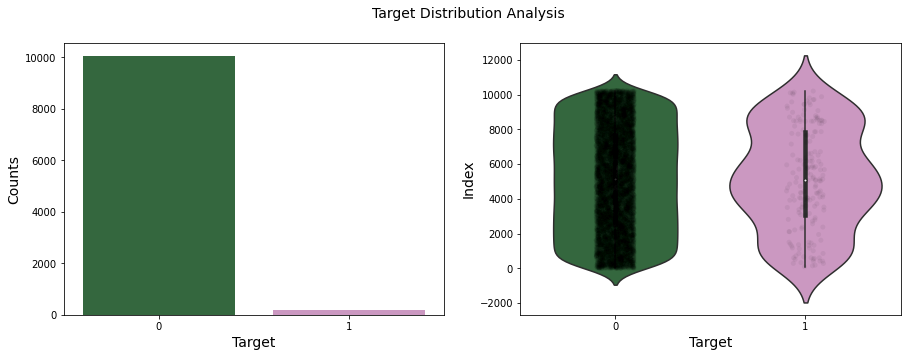

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Target Distribution Analysis", size=14)
# print("Mean-target: {}".format(round(data["target"].mean(), 4)))

sns.countplot(x= data["target"], ax=axes[0], palette="cubehelix")
sns.violinplot(x = data["target"], y = data.index, ax=axes[1], palette="cubehelix")
sns.stripplot(x = data["target"], y = data.index, jitter=True, ax=axes[1], color="black", alpha=0.05)

axes[0].set_xlabel("Target", fontsize=14)
axes[0].set_ylabel("Counts", fontsize=14)
axes[1].set_xlabel("Target", fontsize=14)
axes[1].set_ylabel("Index", fontsize=14)

In [25]:
count_0 = data["target"].value_counts()[0]
count_1 = data["target"].value_counts()[1]

count_0_pr = round(data["target"].value_counts()[0]/data.shape[0] * 100, 2)
count_1_pr = round(data["target"].value_counts()[1]/data.shape[0] * 100, 2)

print("0 : {}, процент от общего датасета: {}%".format(count_0, count_0_pr))
print("1 : {}, процент от общего датасета: {}%".format(count_1, count_1_pr))

0 : 10053, процент от общего датасета: 98.23%
1 : 181, процент от общего датасета: 1.77%


* виден очень сильный дисбаланс классов

* хорошее распределение целевой переменной по всему датасету

# Пропуски

In [26]:
data["age"].std(), data["age"].mean()

(17.85166063435276, 62.85362517099863)

In [27]:
count = 0
list_sign = []
for i in data:
    pr = round(data[i].isna().sum()/ data.shape[0]*100,1)
    print("sign: ",i)
    print("omissions: {}%".format(pr))
    if pr > 50:
        count += 1
        list_sign.append(i)


sign:  encounter_id
omissions: 0.0%
sign:  hospital_id
omissions: 0.0%
sign:  age
omissions: 0.0%
sign:  bmi
omissions: 9.9%
sign:  elective_surgery
omissions: 0.0%
sign:  ethnicity
omissions: 2.0%
sign:  gender
omissions: 0.0%
sign:  height
omissions: 2.9%
sign:  hospital_admit_source
omissions: 26.7%
sign:  icu_admit_source
omissions: 0.2%
sign:  icu_id
omissions: 0.0%
sign:  icu_stay_type
omissions: 0.0%
sign:  icu_type
omissions: 0.0%
sign:  pre_icu_los_days
omissions: 0.0%
sign:  readmission_status
omissions: 0.0%
sign:  weight
omissions: 8.9%
sign:  albumin_apache
omissions: 59.2%
sign:  apache_2_diagnosis
omissions: 1.7%
sign:  apache_3j_diagnosis
omissions: 1.1%
sign:  apache_post_operative
omissions: 0.0%
sign:  arf_apache
omissions: 0.0%
sign:  bilirubin_apache
omissions: 61.7%
sign:  bun_apache
omissions: 20.1%
sign:  creatinine_apache
omissions: 20.0%
sign:  fio2_apache
omissions: 74.6%
sign:  gcs_eyes_apache
omissions: 2.0%
sign:  gcs_motor_apache
omissions: 2.0%
sign:  gc

In [28]:
count

74

<AxesSubplot:>

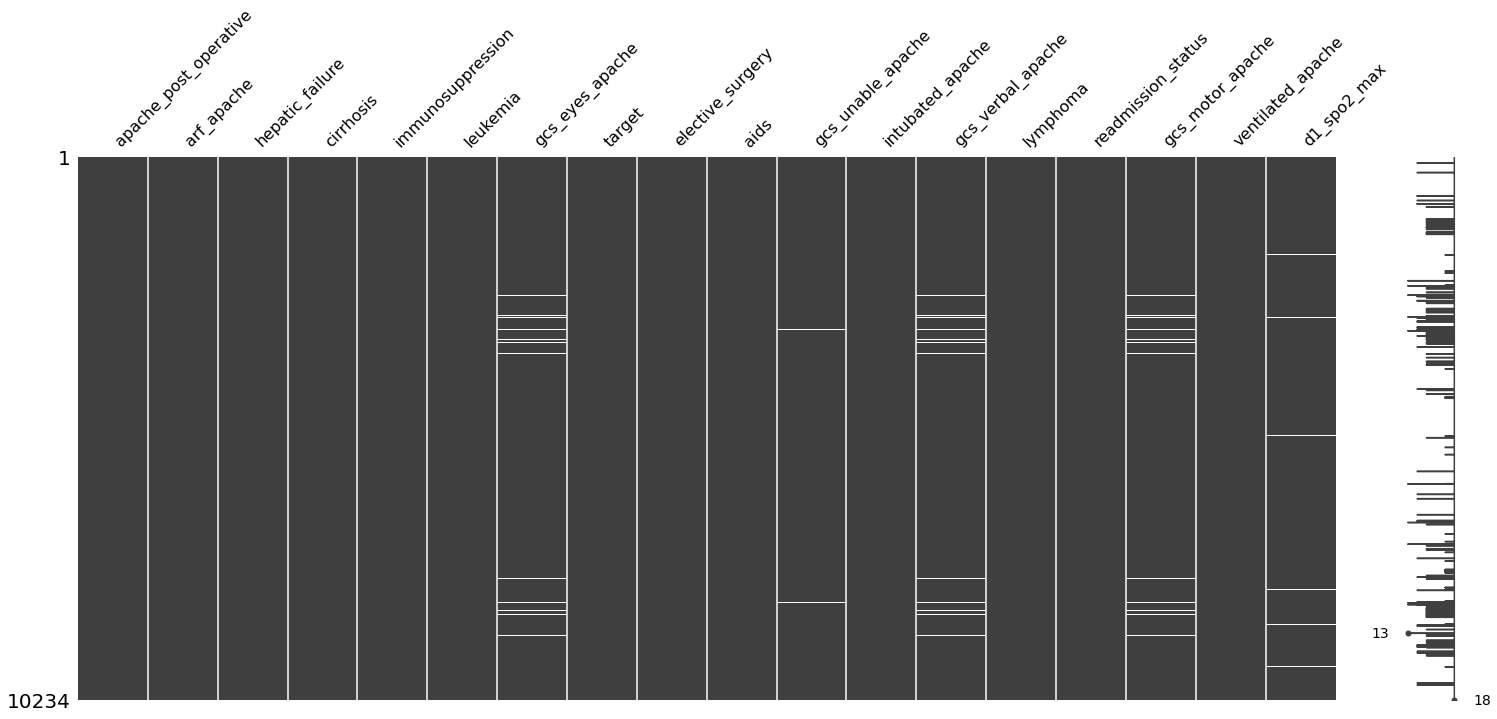

In [29]:
msno.matrix(data[discrete_feature])

<AxesSubplot:>

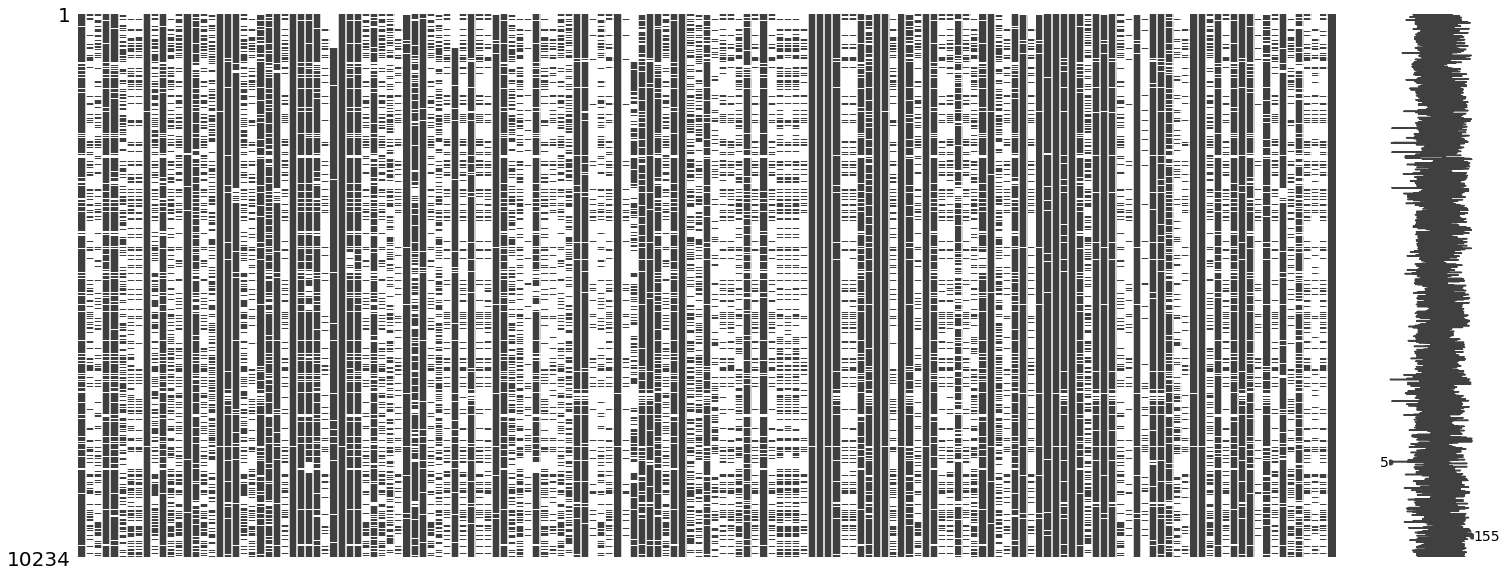

In [30]:
msno.matrix(data[continuous_feature])

In [31]:
list(categorical)

['ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_stay_type',
 'icu_type']

<AxesSubplot:>

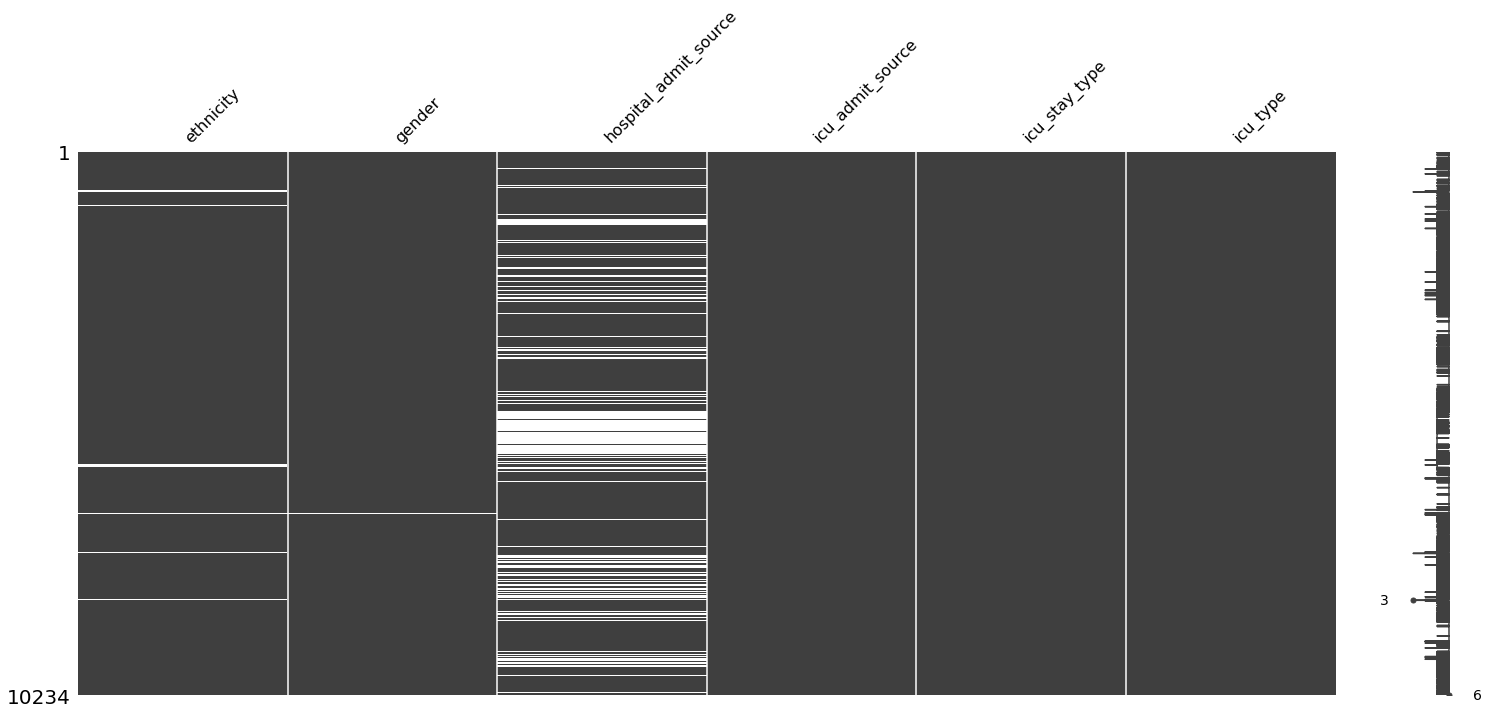

In [32]:
msno.matrix(data[list(categorical)])

* большое кол-во разреженных признаков в непрерывных числовых данных

In [33]:
new_col = [i  for i in data.columns if i not in list_sign]
len(new_col)

105

In [34]:
data_n = data[new_col].copy()

In [35]:
for i in data_n:
#     print(i)
    print(i,": ", data_n[i].isna().sum()/data_n.shape[0]*100)

encounter_id :  0.0
hospital_id :  0.0
age :  0.0
bmi :  9.917920656634747
elective_surgery :  0.0
ethnicity :  1.9933554817275747
gender :  0.048856752003126835
height :  2.941176470588235
hospital_admit_source :  26.705100644909123
icu_admit_source :  0.24428376001563415
icu_id :  0.0
icu_stay_type :  0.0
icu_type :  0.0
pre_icu_los_days :  0.0
readmission_status :  0.0
weight :  8.872386163767834
apache_2_diagnosis :  1.6611295681063125
apache_3j_diagnosis :  1.0553058432675395
apache_post_operative :  0.0
arf_apache :  0.0
bun_apache :  20.13875317568888
creatinine_apache :  19.962868868477624
gcs_eyes_apache :  2.0031268321282
gcs_motor_apache :  2.0031268321282
gcs_unable_apache :  0.5960523744381474
gcs_verbal_apache :  2.0031268321282
glucose_apache :  11.823333984756694
heart_rate_apache :  0.293140512018761
hematocrit_apache :  20.656634746922027
intubated_apache :  0.0
map_apache :  0.5081102208325191
resprate_apache :  0.6253664256400234
sodium_apache :  19.474301348446353


# correlation

In [36]:
categorical_n = data_n.dtypes[data_n.dtypes == "object"].index
numerical_n = list(set(data_n.columns) - set(categorical))

print(f"Всего категориальных признаков: {len(categorical_n)}")
print(f"Всего числовых признаков: {len(numerical_n)}")

Всего категориальных признаков: 6
Всего числовых признаков: 99


In [37]:
discrete_feature_n = [
    feature for feature in numerical_n
    if len(data_n[feature].unique())< 25
]

print(f"Discrete Variables Count: {len(discrete_feature_n)}")

Discrete Variables Count: 18


In [38]:
continuous_feature_n = [
    feature for feature in numerical_n
    if feature not in discrete_feature_n
]
print(f"Continuous Feature Count {len(continuous_feature_n)}")

Continuous Feature Count 81


target                   1.00000
immunosuppression        0.27907
elective_surgery         0.02553
apache_post_operative    0.02192
aids                     0.01953
leukemia                 0.01668
lymphoma                 0.01458
gcs_unable_apache        0.00905
cirrhosis                0.00561
gcs_verbal_apache        0.00545
d1_spo2_max              0.00418
arf_apache              -0.00261
gcs_eyes_apache         -0.00322
hepatic_failure         -0.00610
gcs_motor_apache        -0.00634
intubated_apache        -0.01321
ventilated_apache       -0.01338
readmission_status           NaN
Name: target, dtype: float64


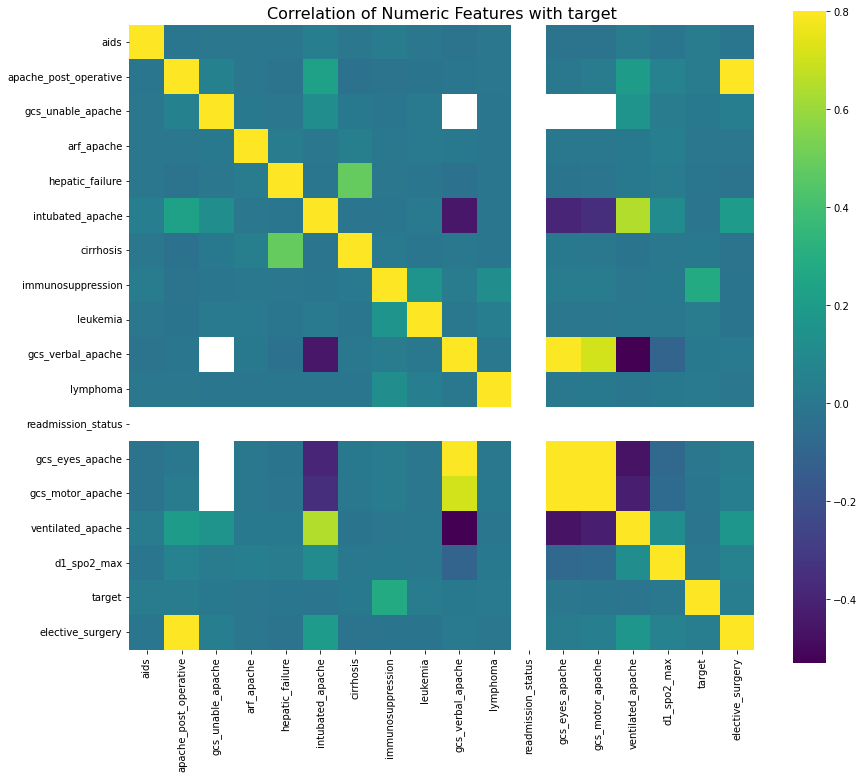

In [39]:
corr(data_n[discrete_feature_n], "target")

target               1.00000
pre_icu_los_days     0.05633
d1_heartrate_max     0.04364
h1_heartrate_max     0.03783
heart_rate_apache    0.03535
                      ...   
d1_hematocrit_min   -0.04770
d1_hemaglobin_min   -0.04946
hematocrit_apache   -0.05121
d1_hematocrit_max   -0.05591
d1_hemaglobin_max   -0.05847
Name: target, Length: 82, dtype: float64


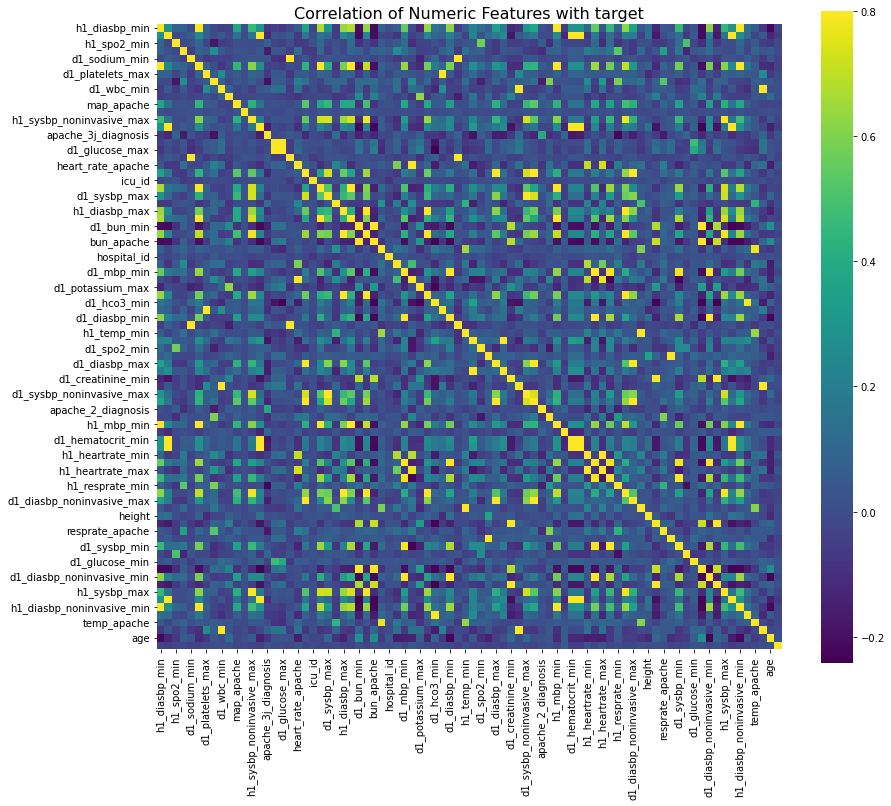

In [40]:
continuous_feature_n.append("target")
corr(data_n[continuous_feature_n], "target")

* слабая линейная корреляция
* присутствуют коррелирующие признаки между собой

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


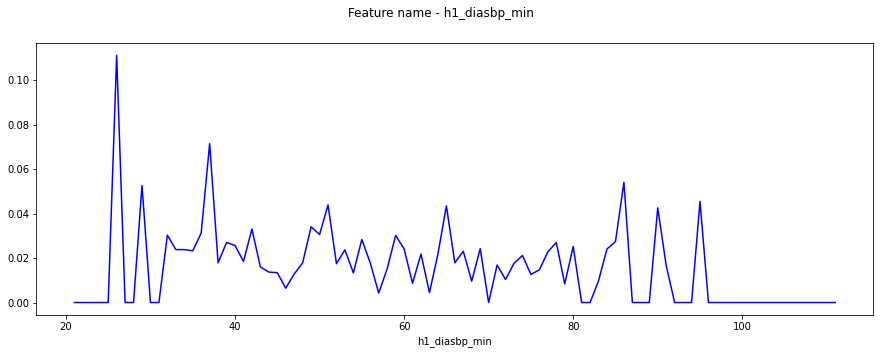

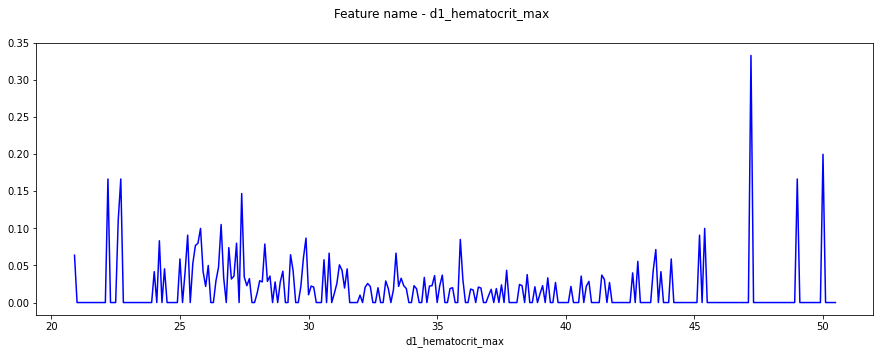

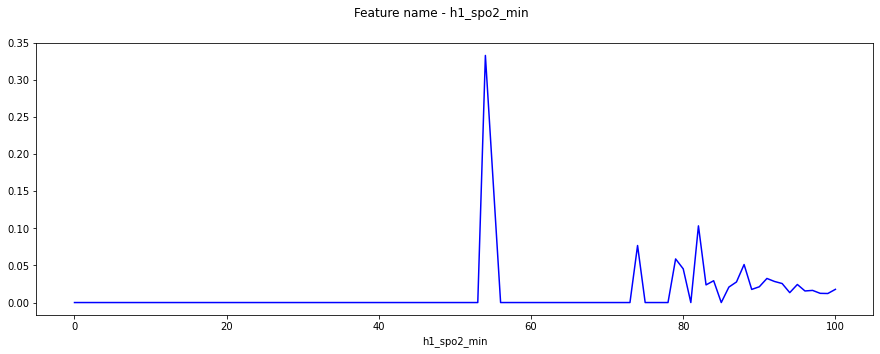

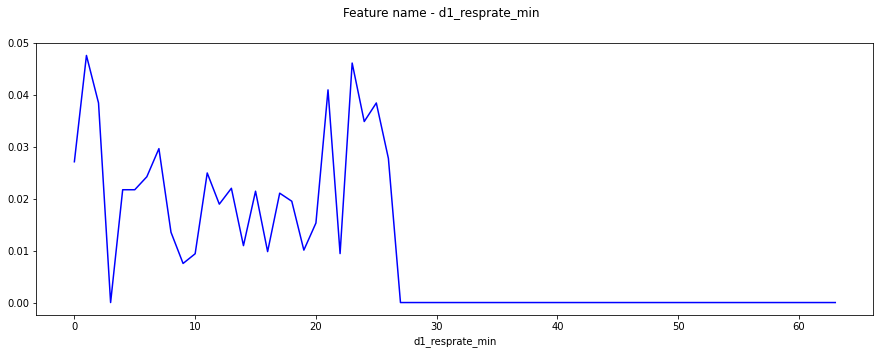

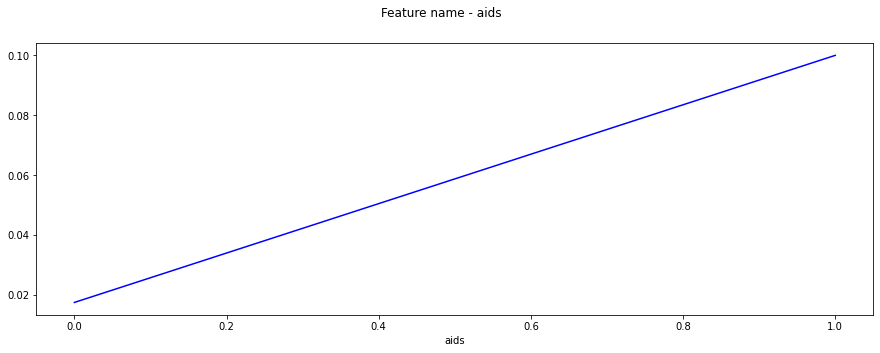

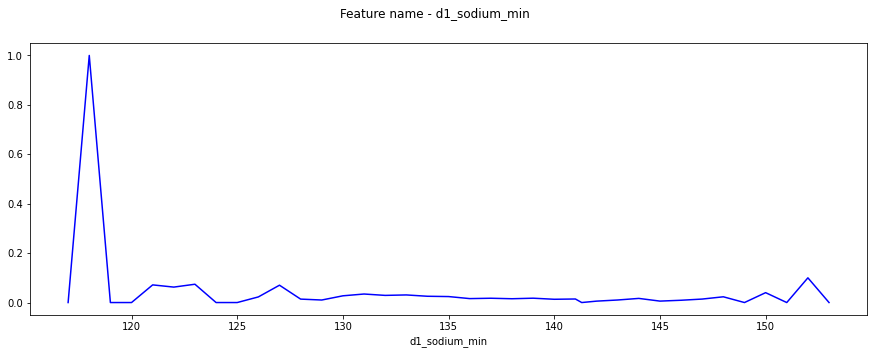

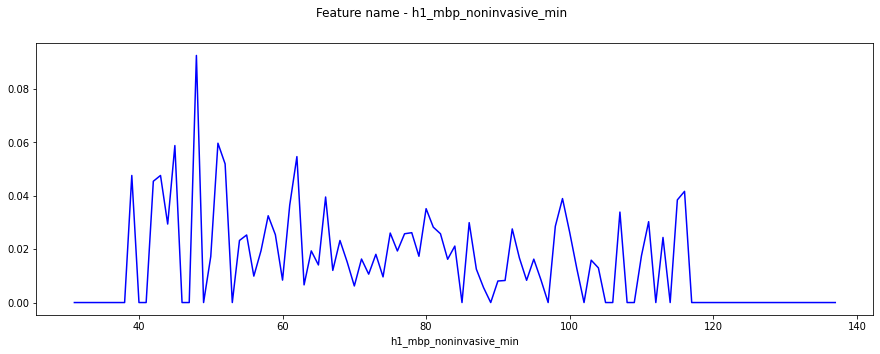

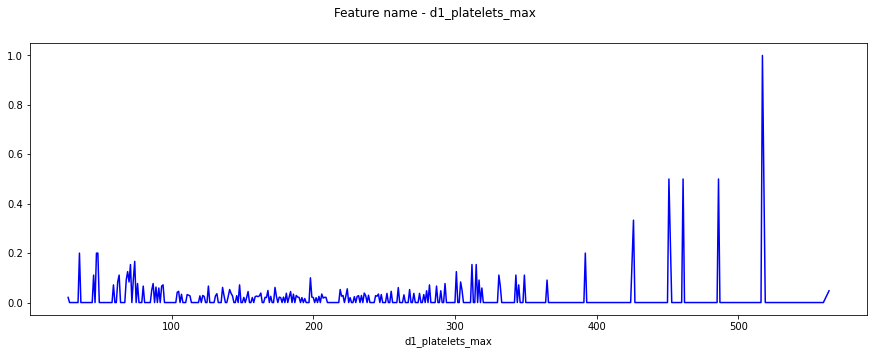

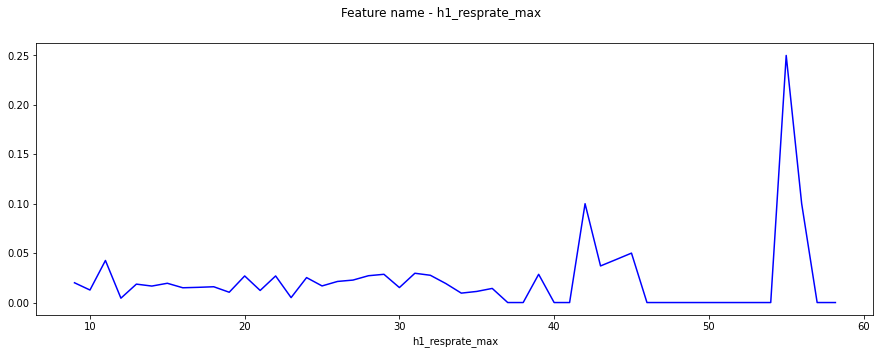

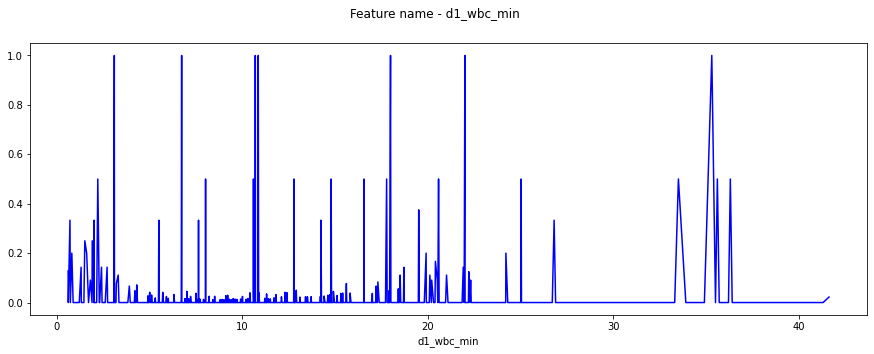

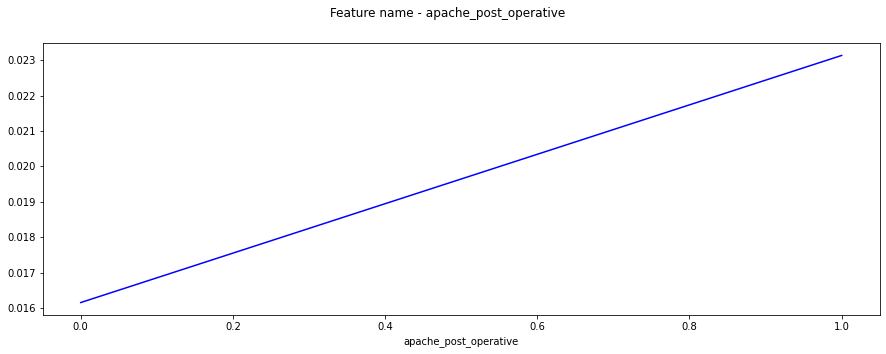

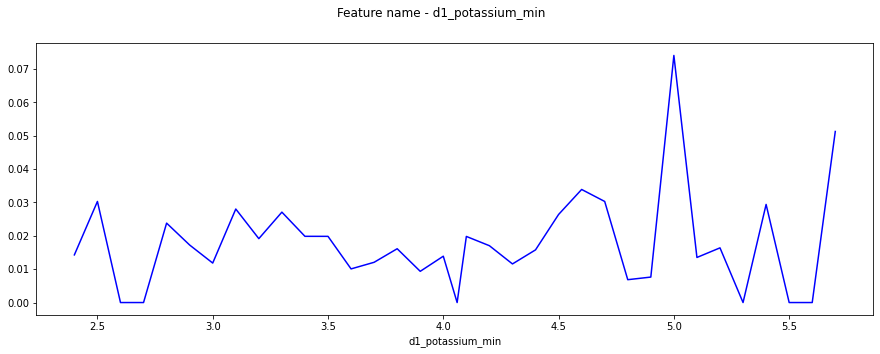

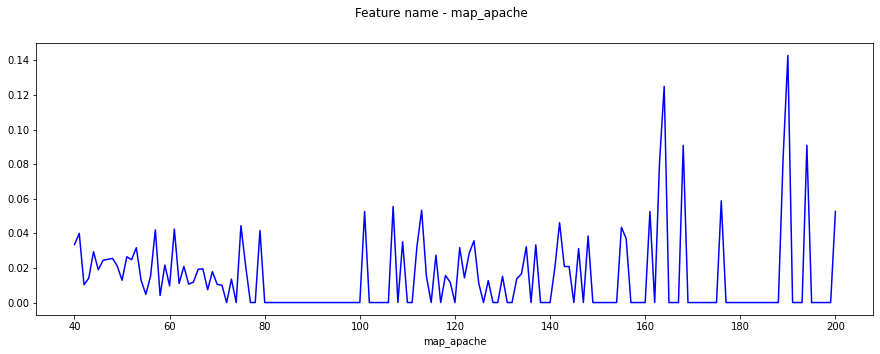

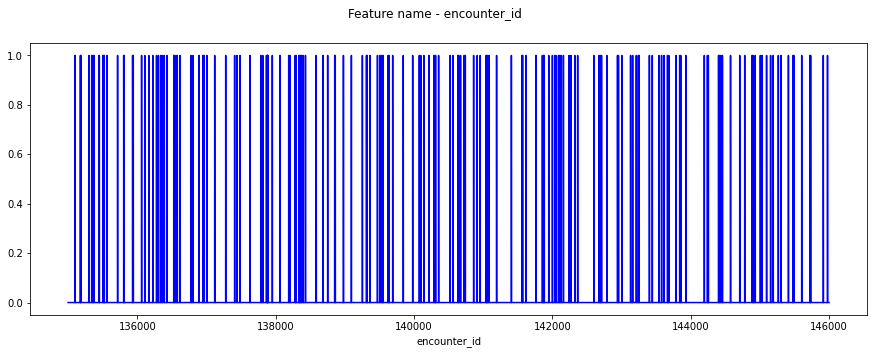

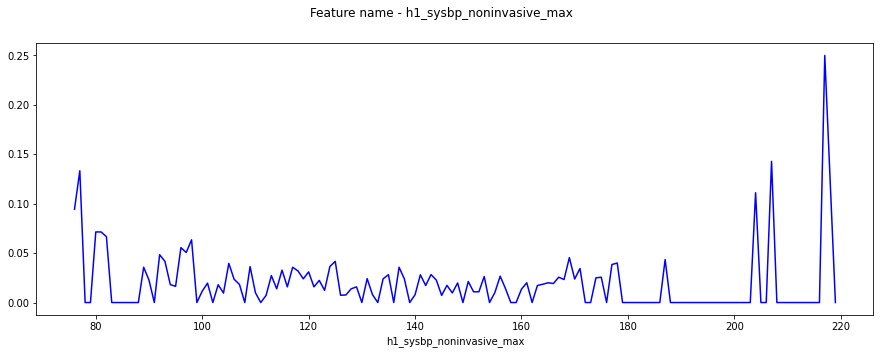

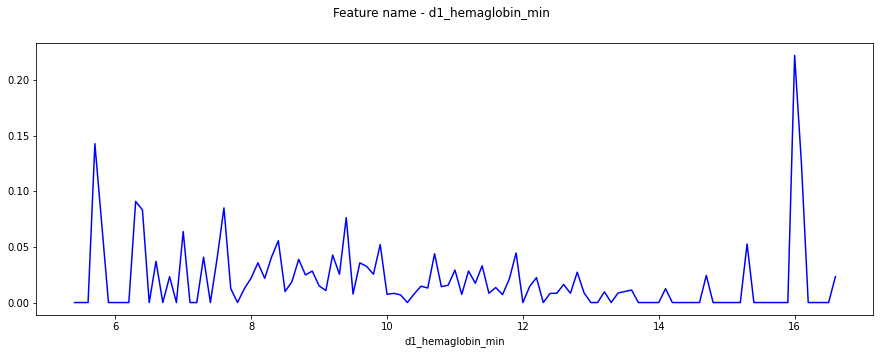

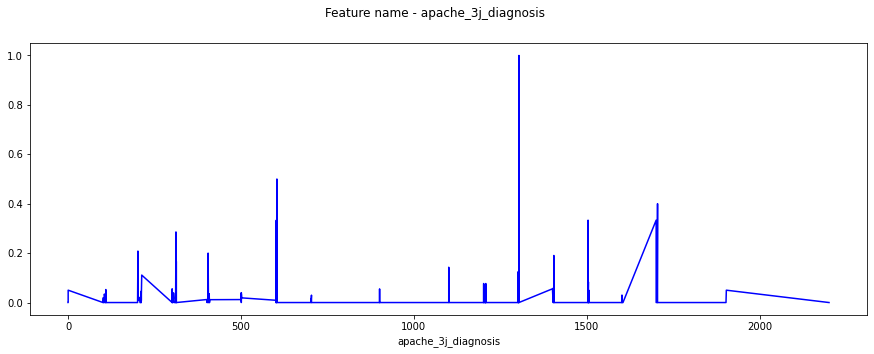

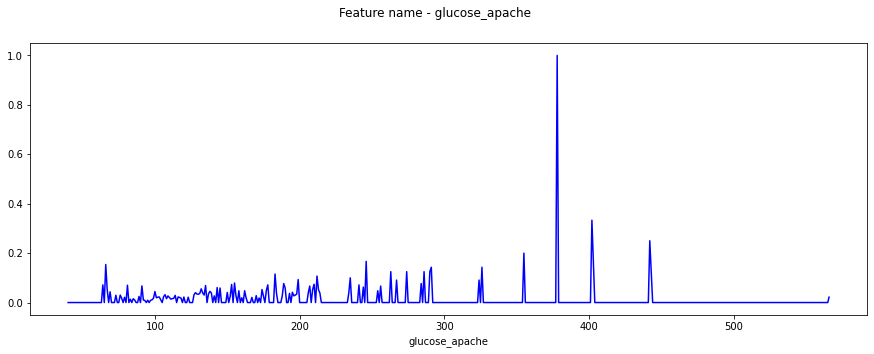

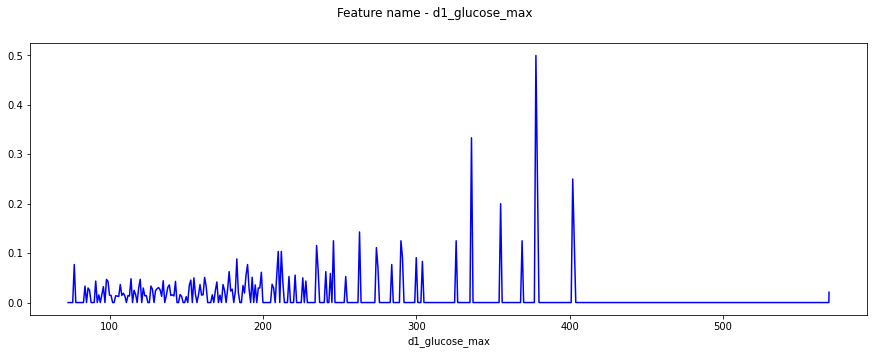

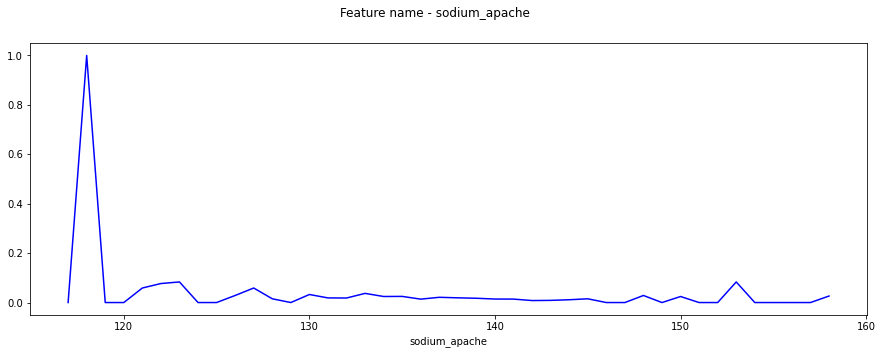

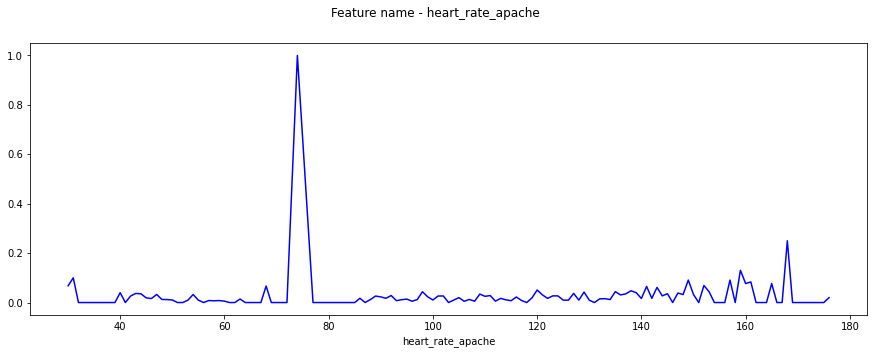

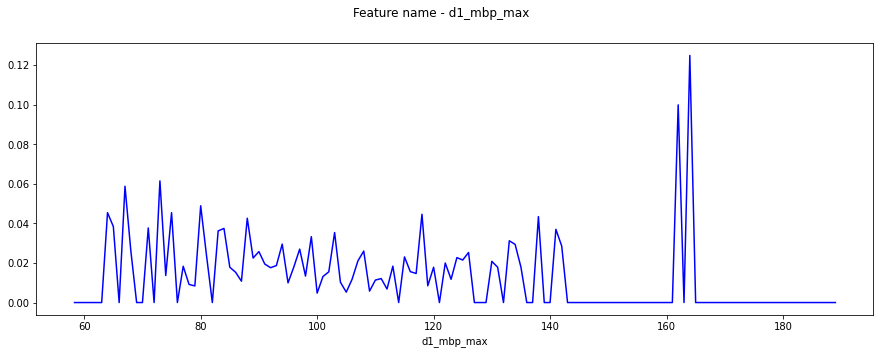

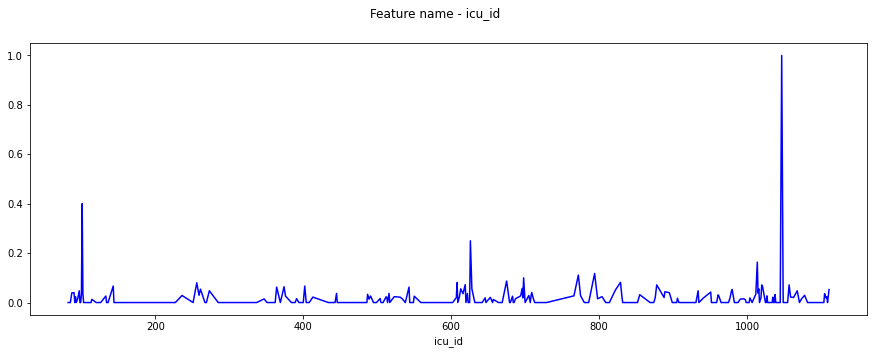

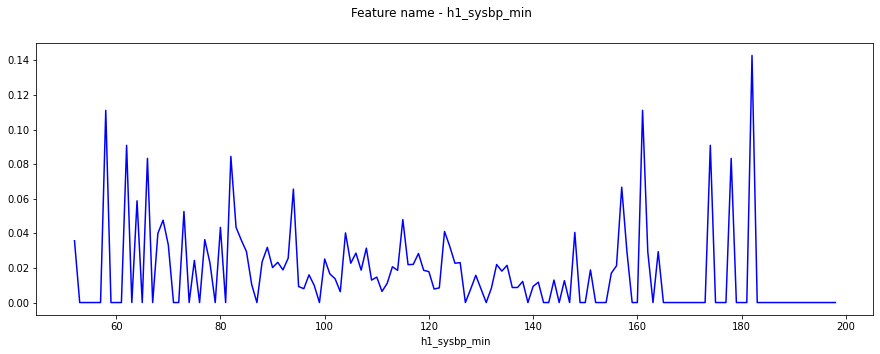

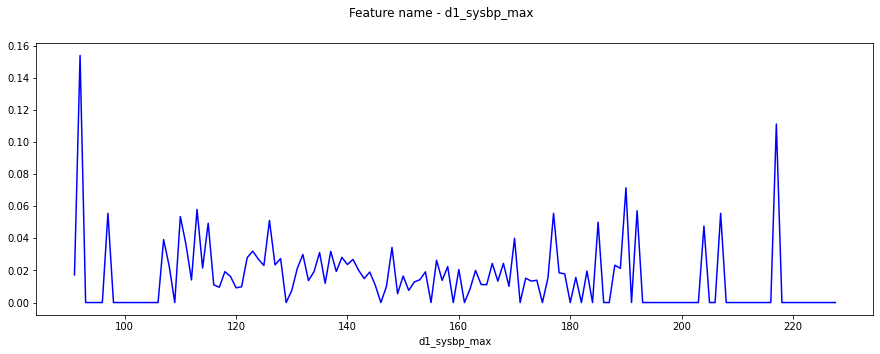

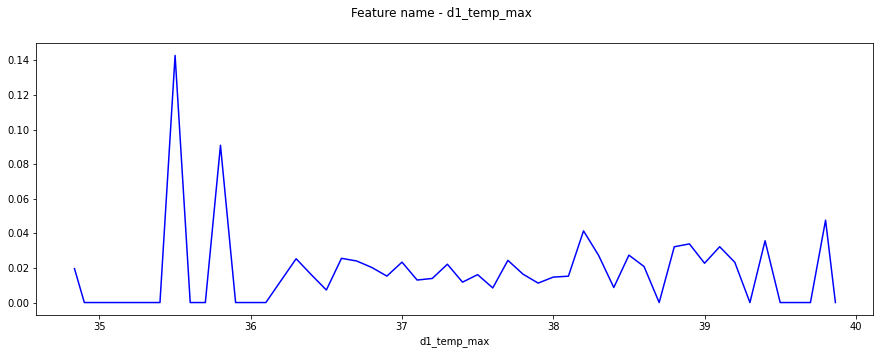

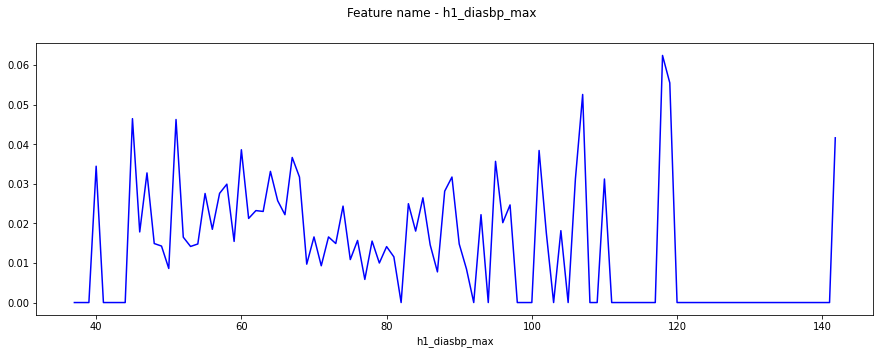

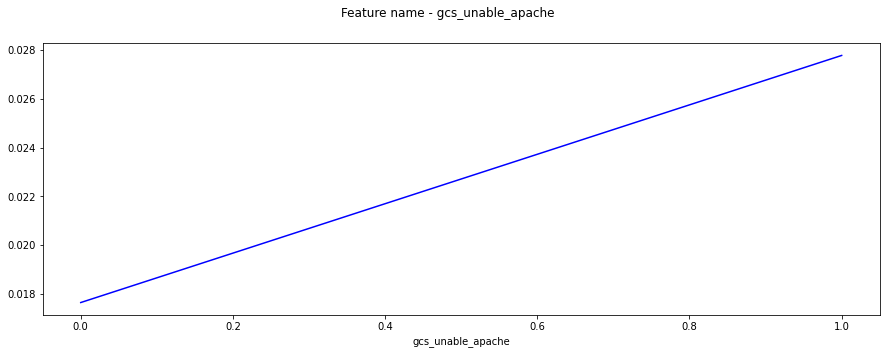

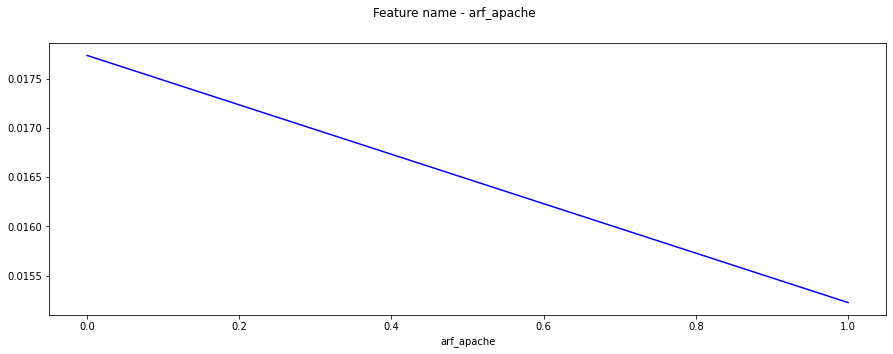

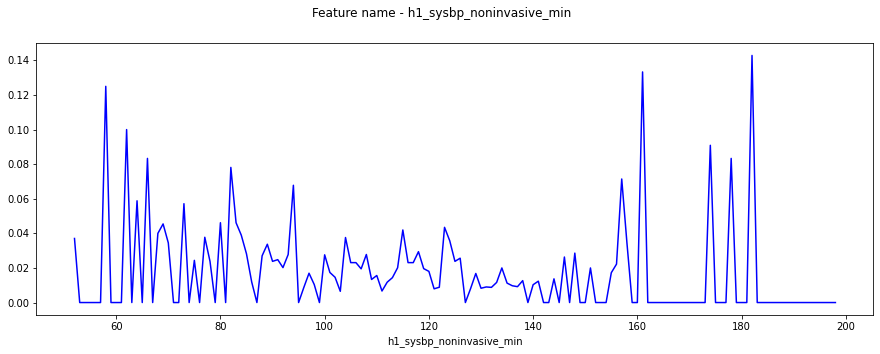

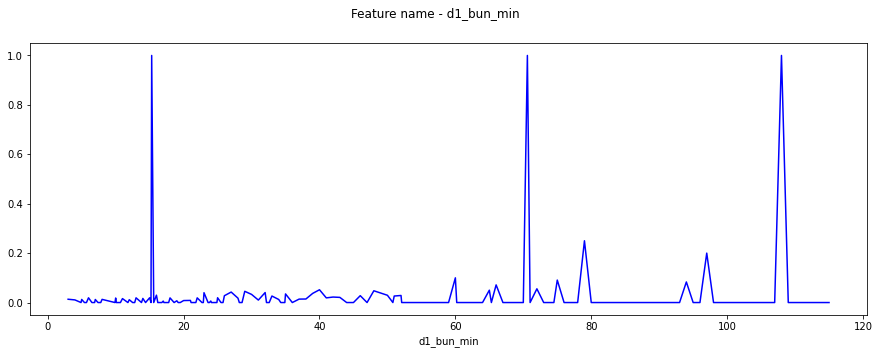

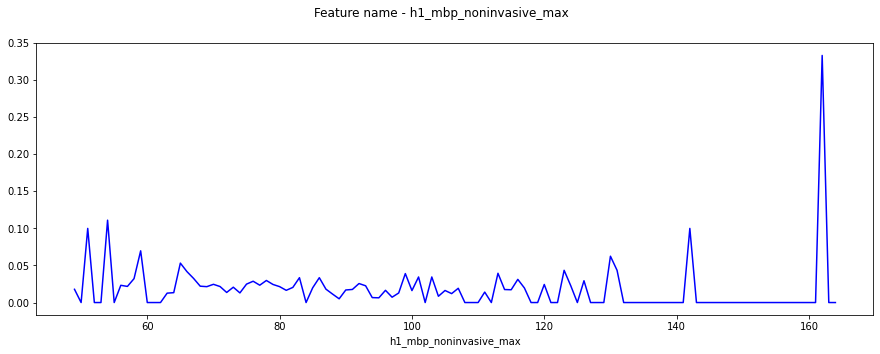

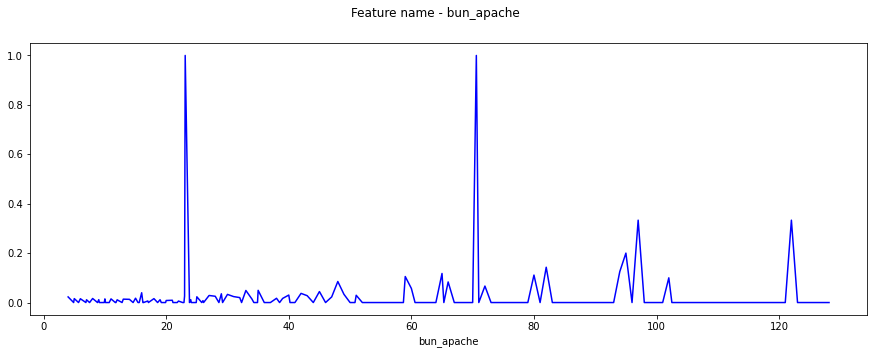

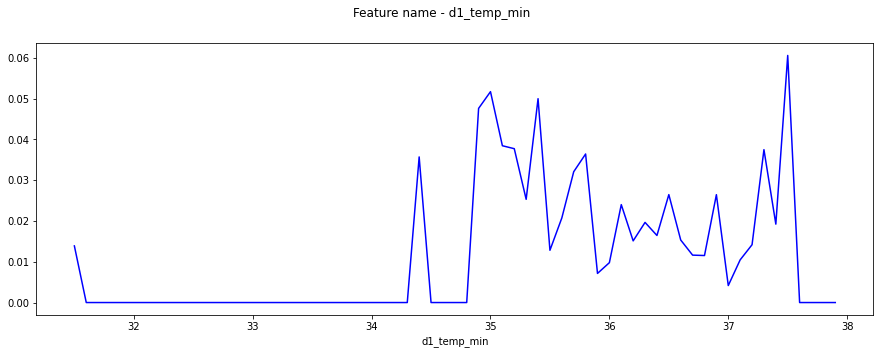

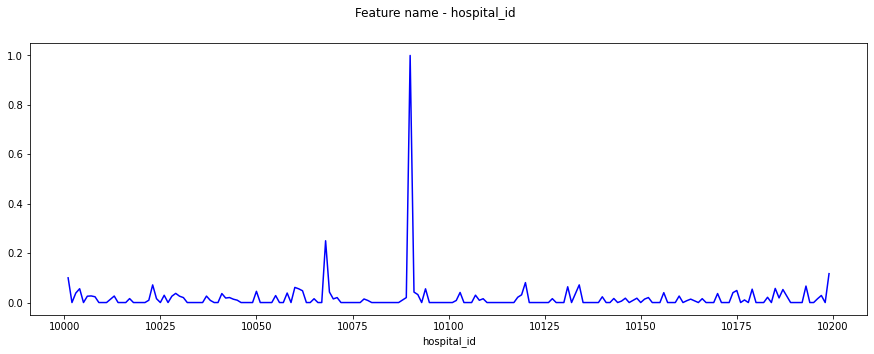

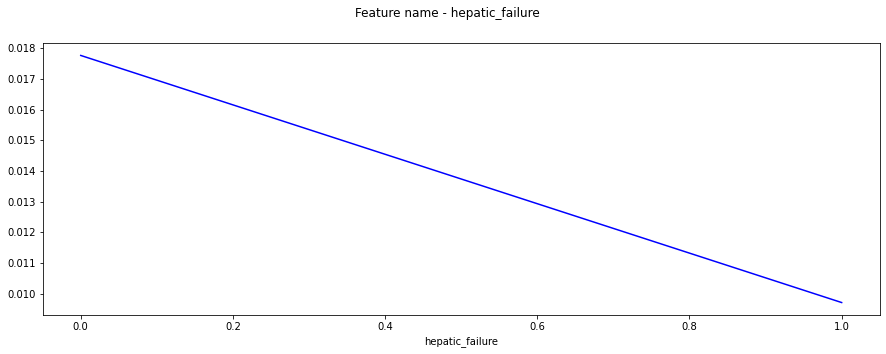

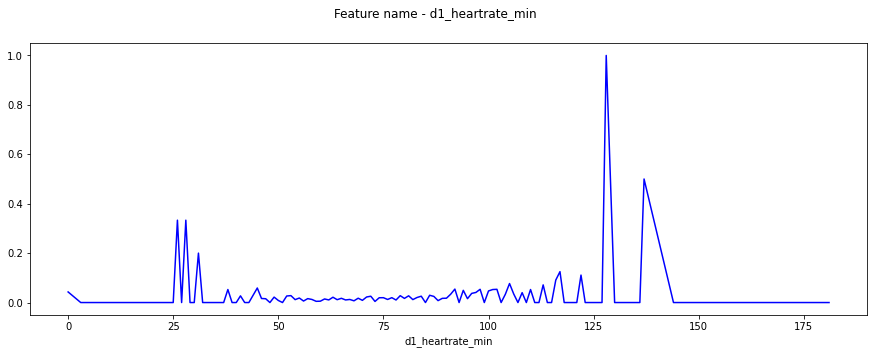

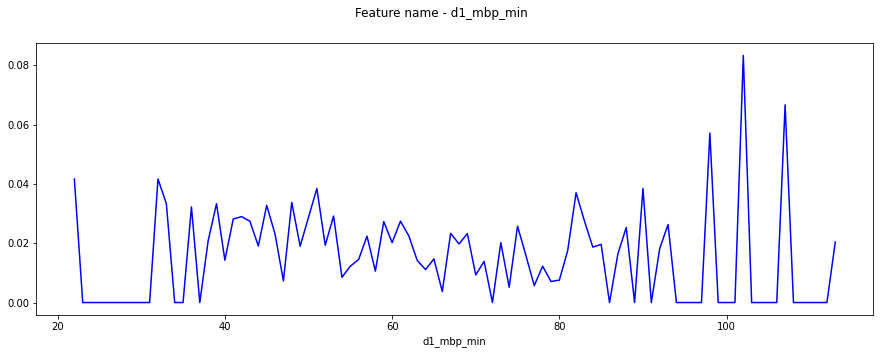

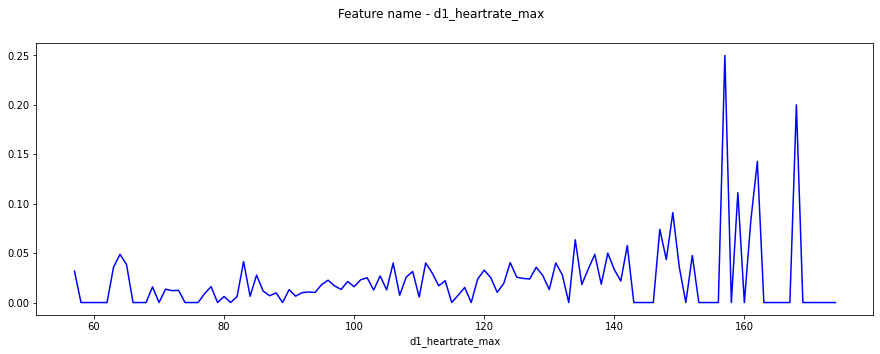

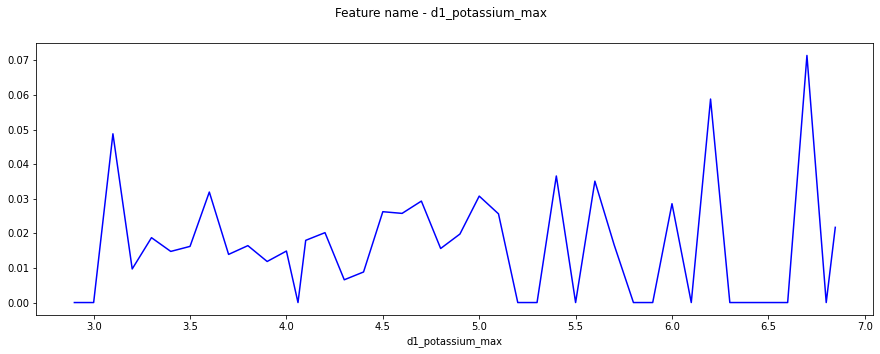

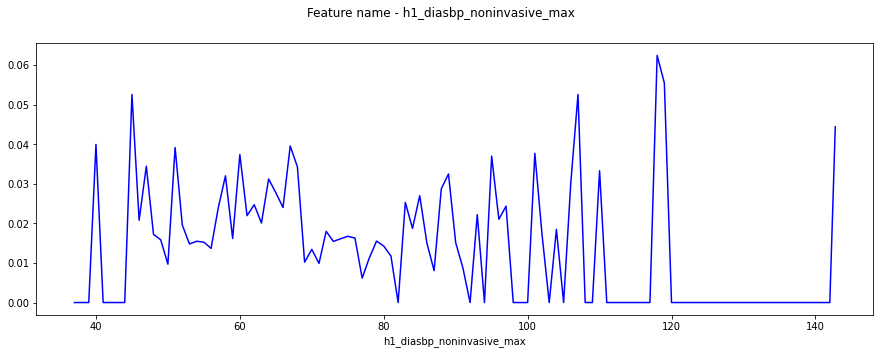

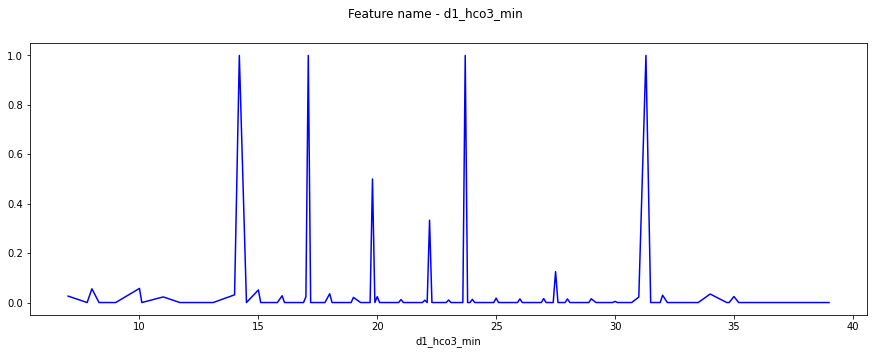

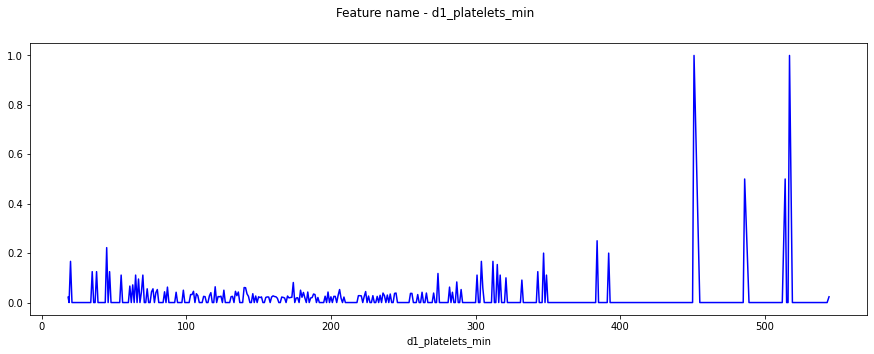

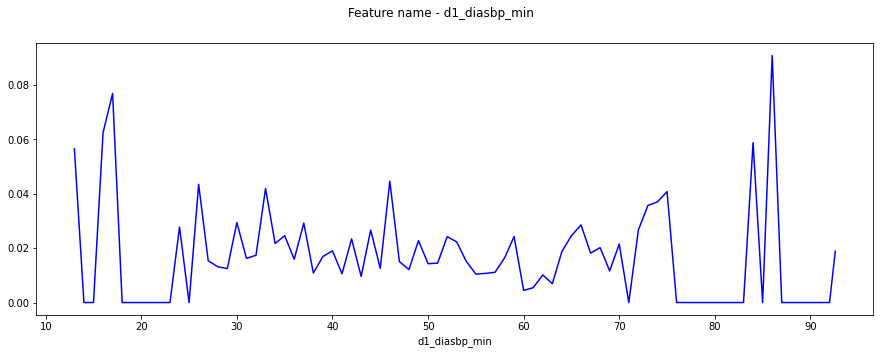

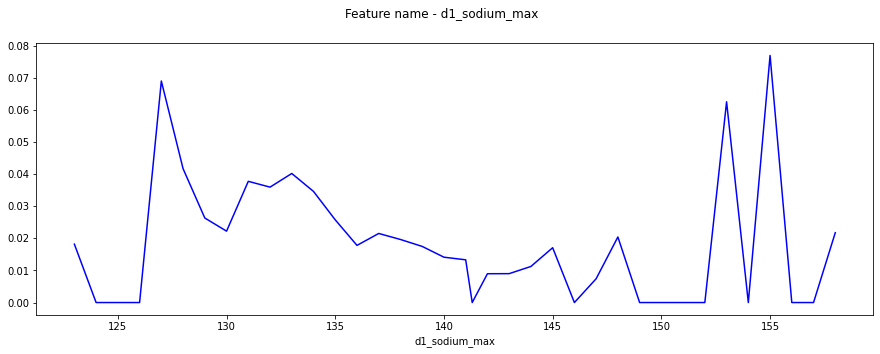

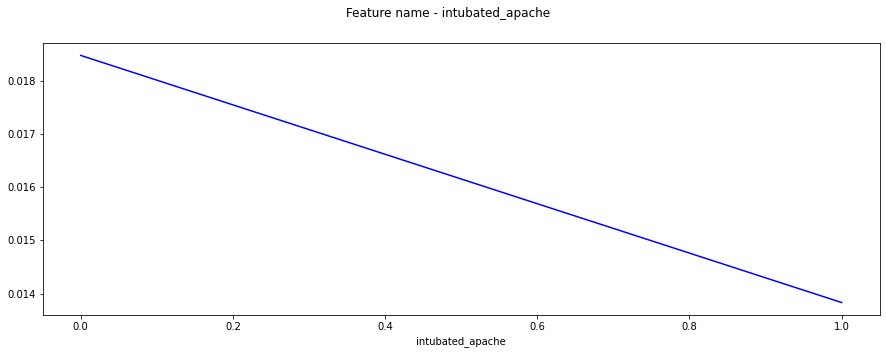

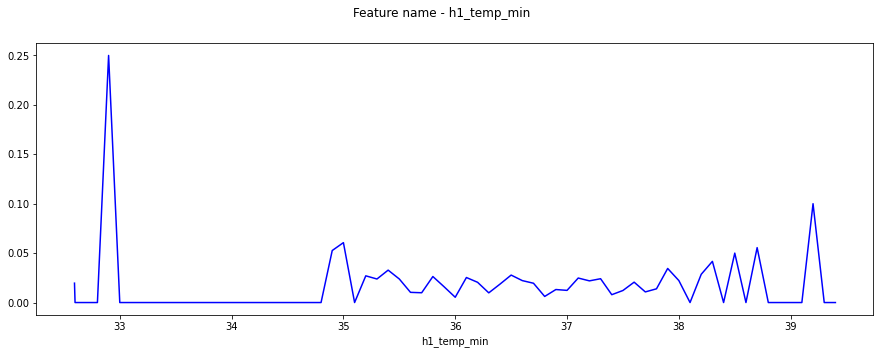

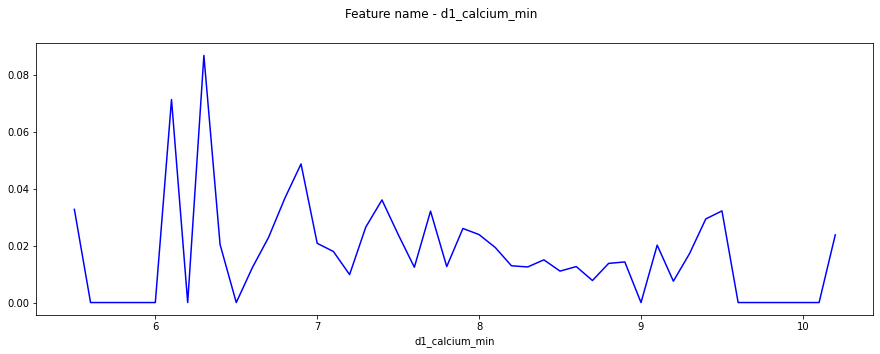

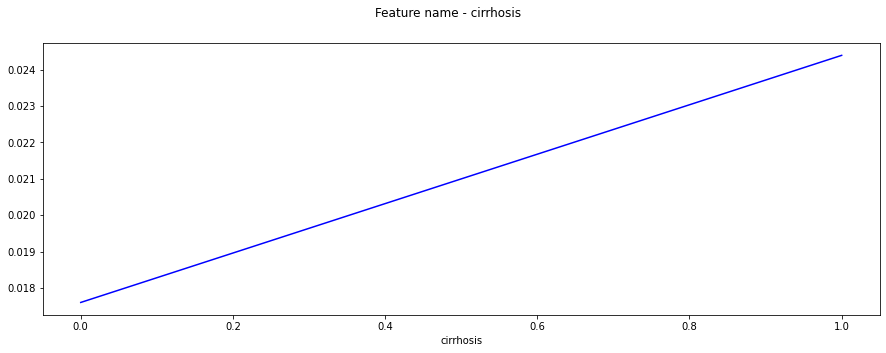

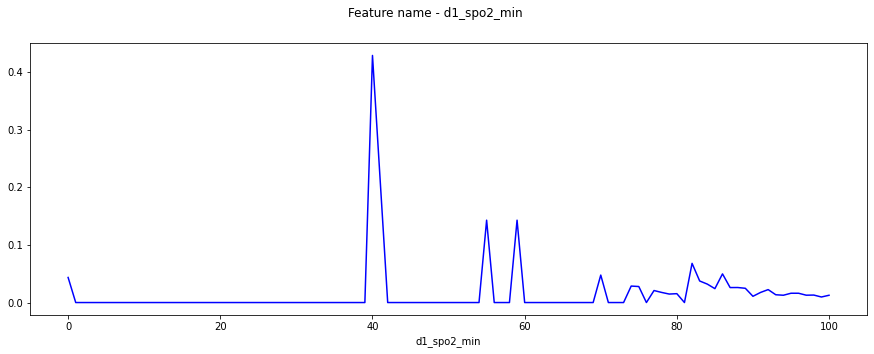

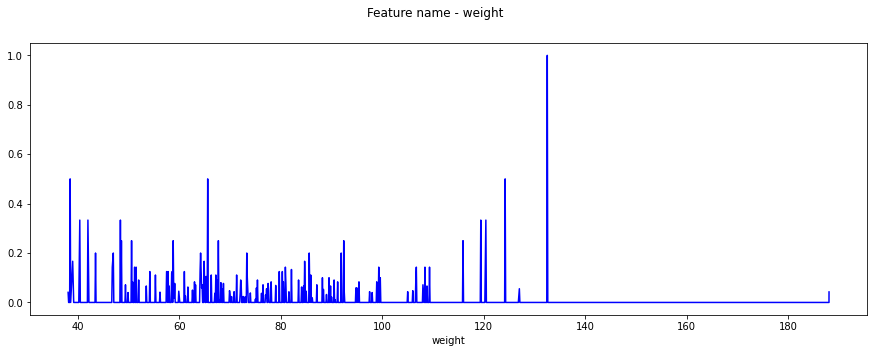

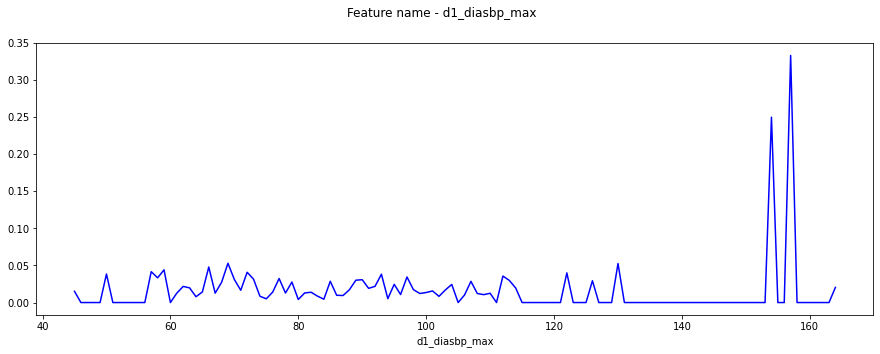

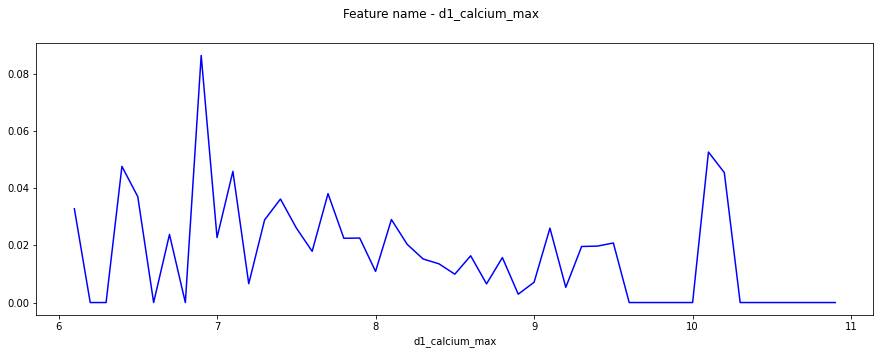

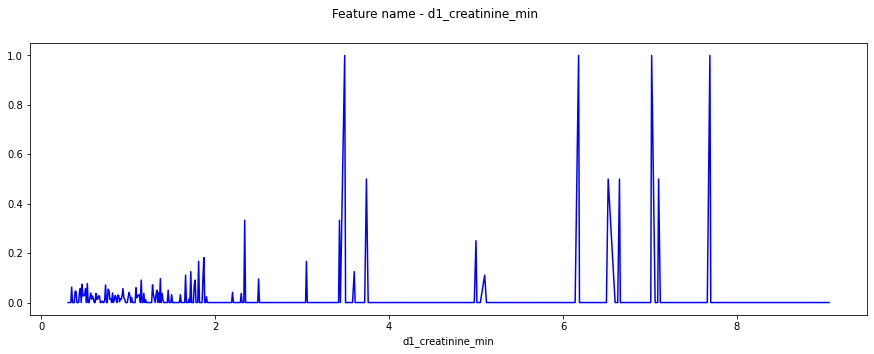

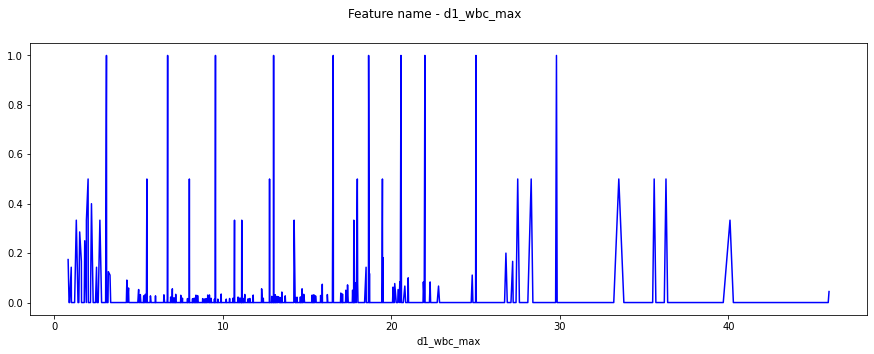

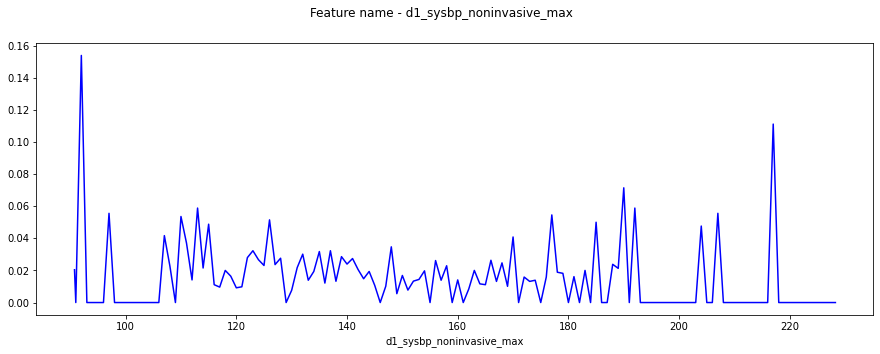

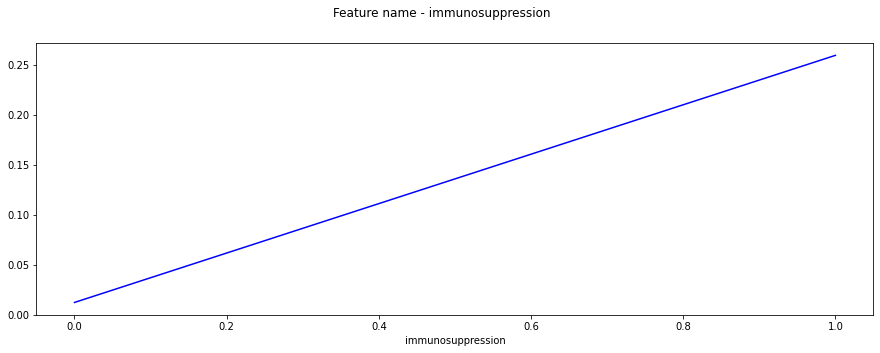

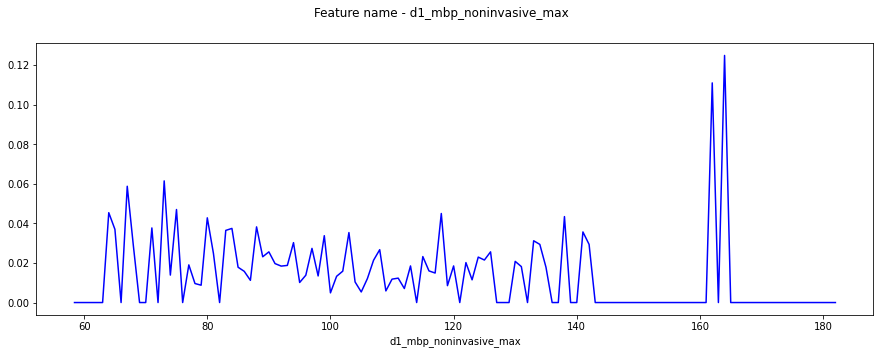

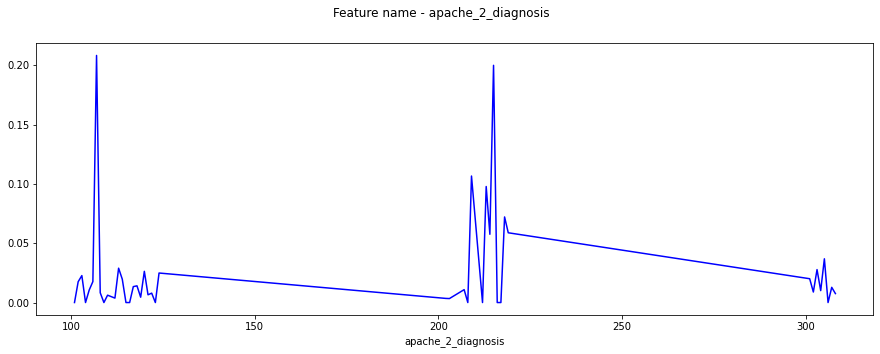

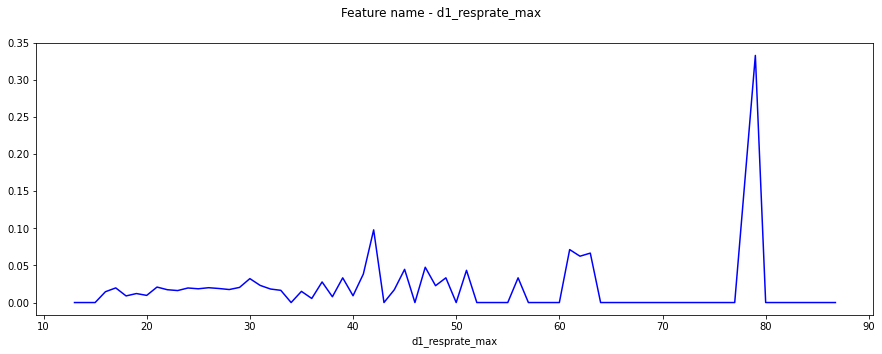

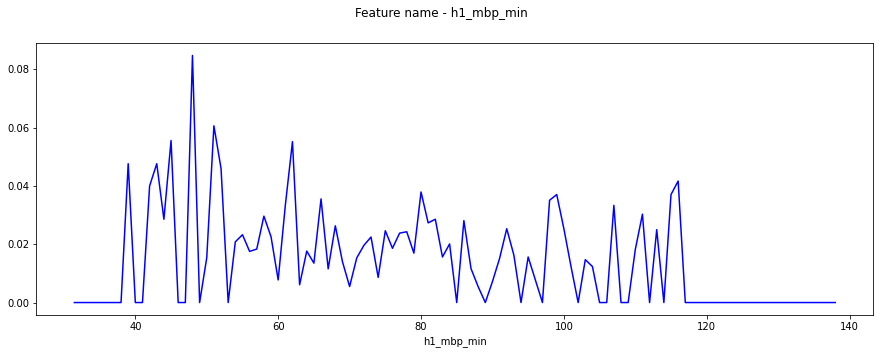

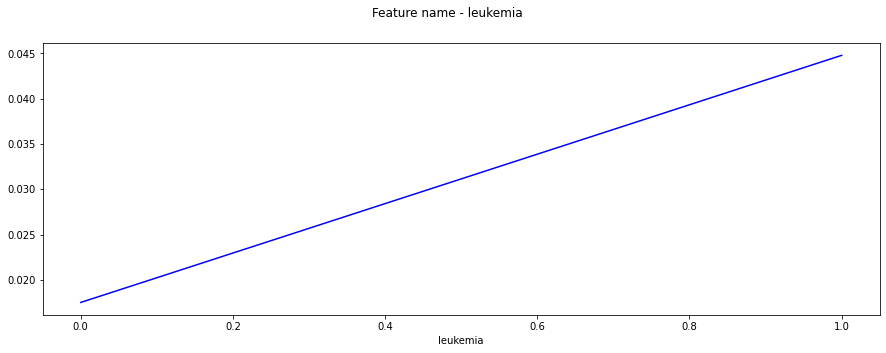

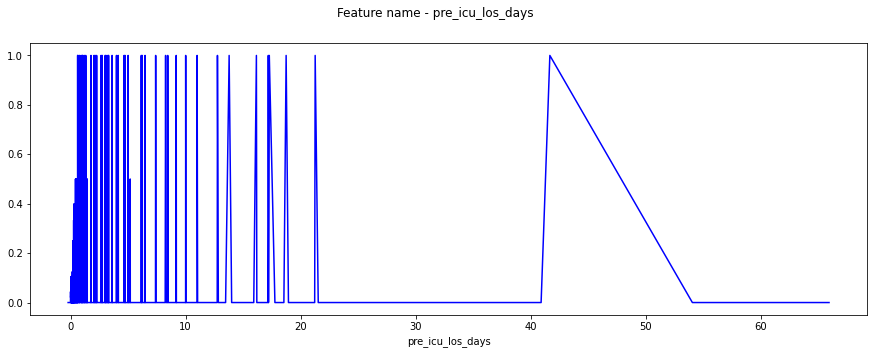

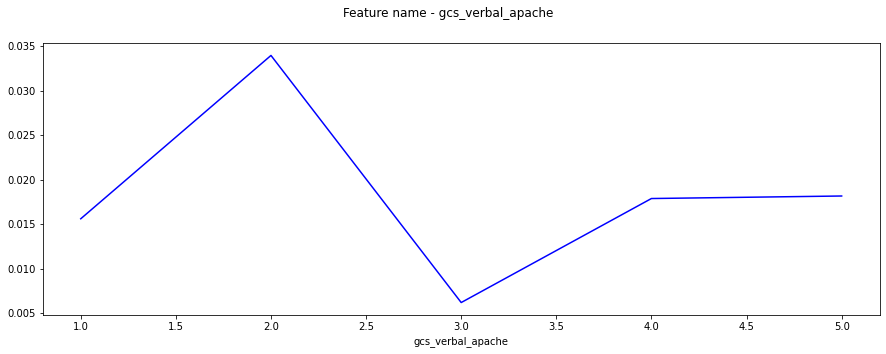

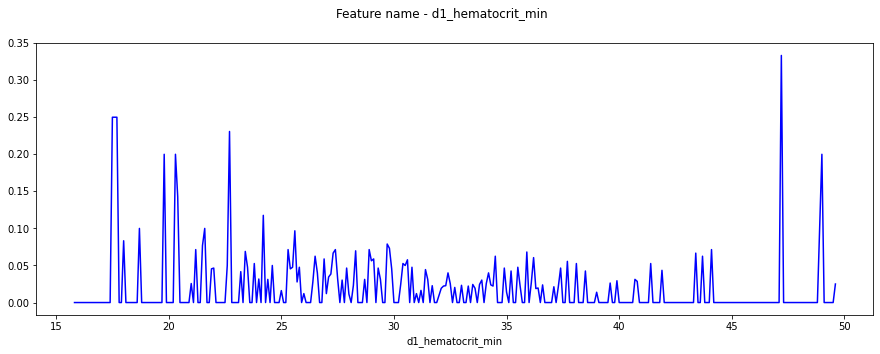

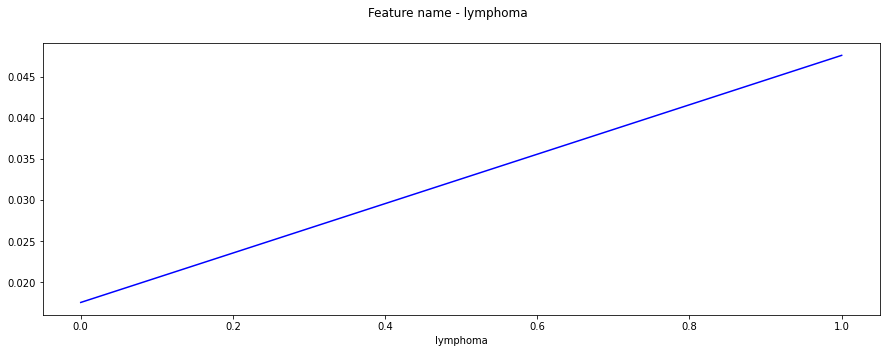

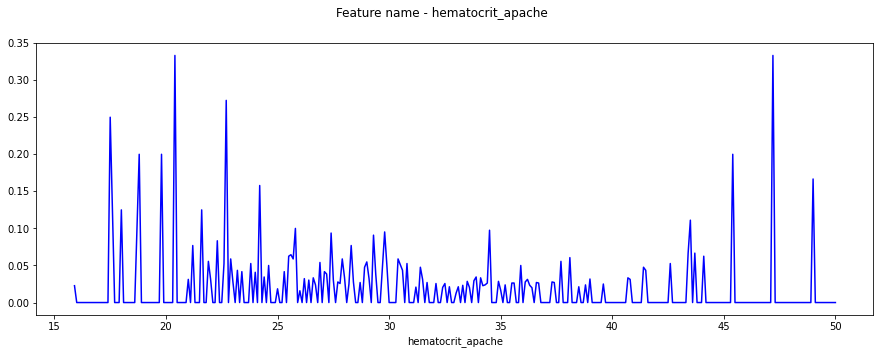

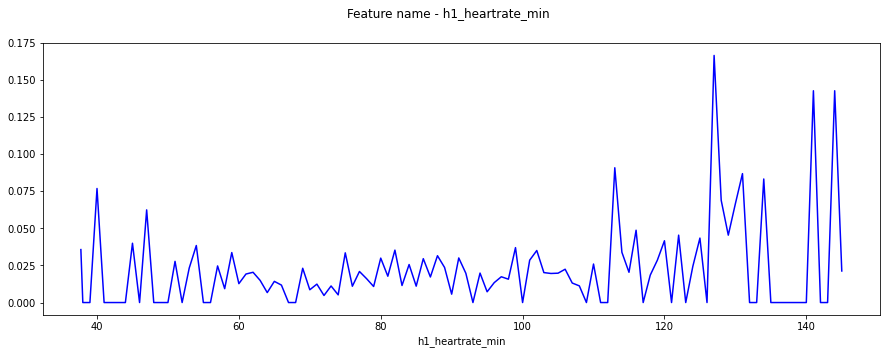

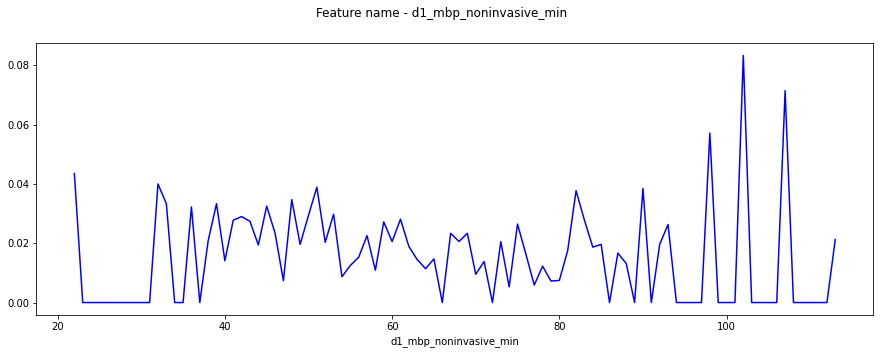

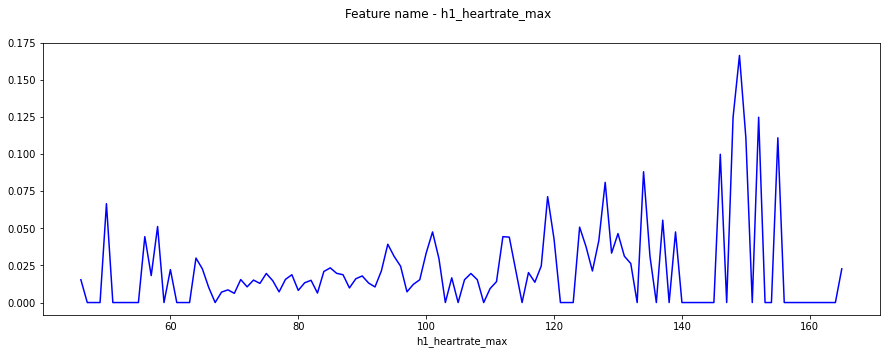

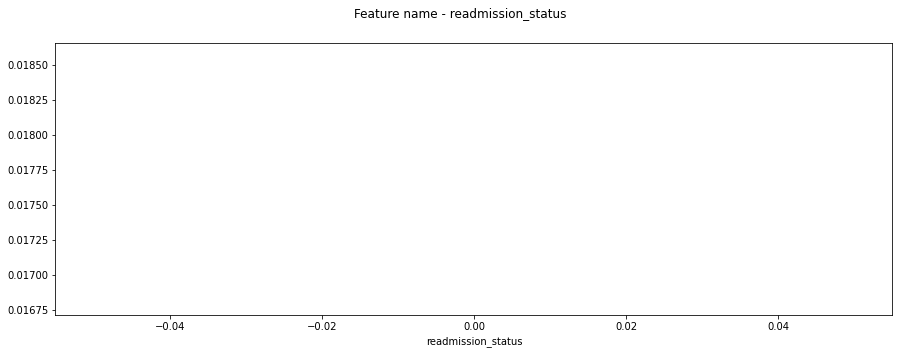

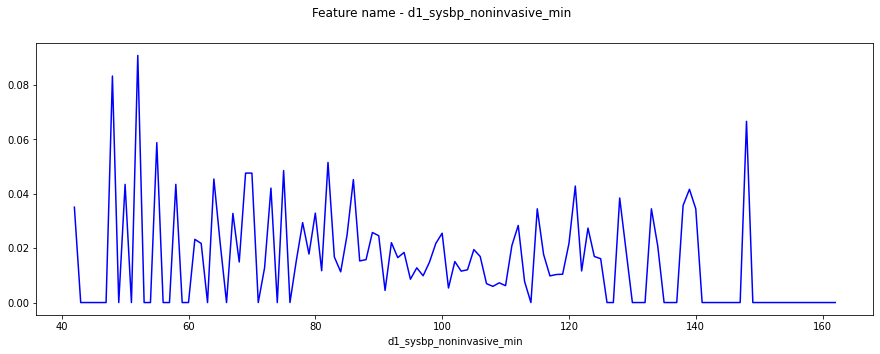

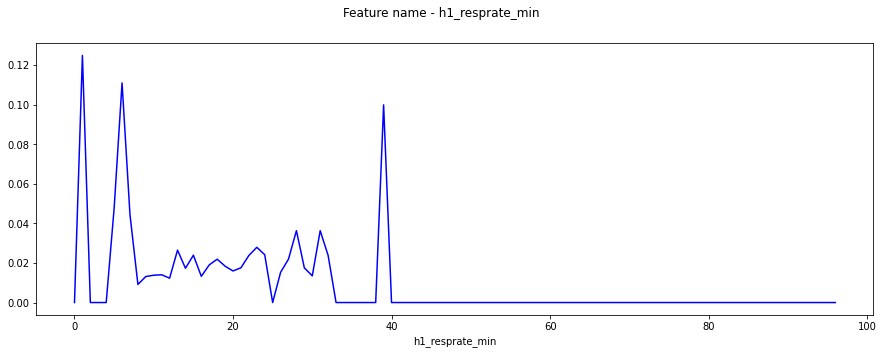

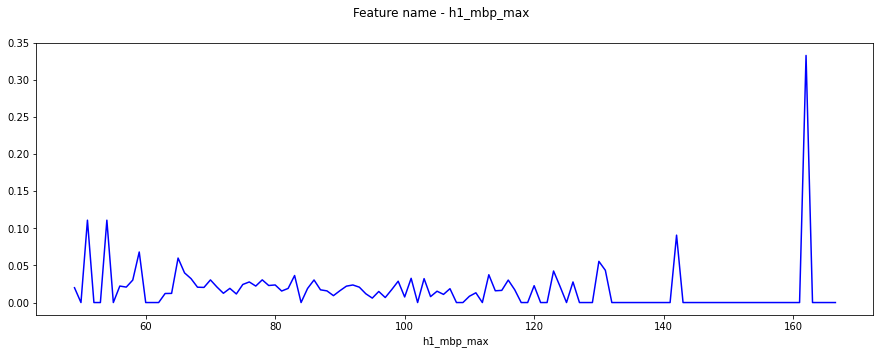

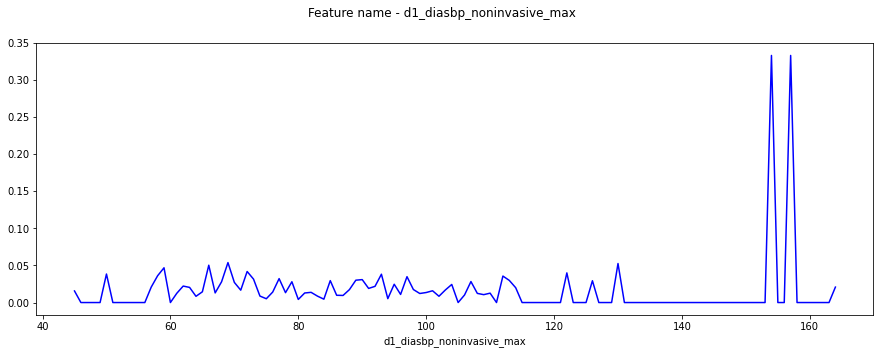

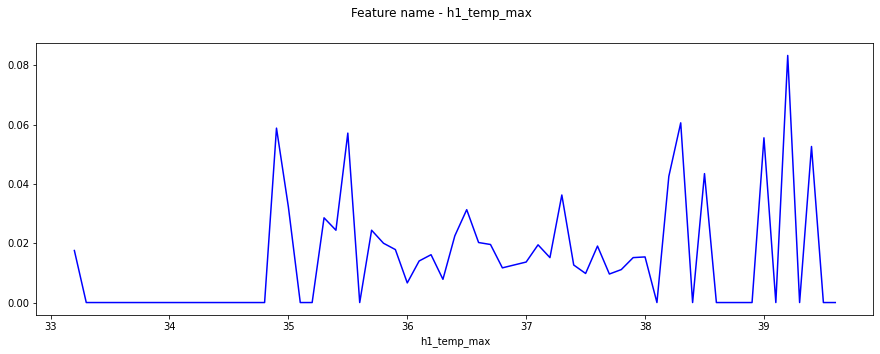

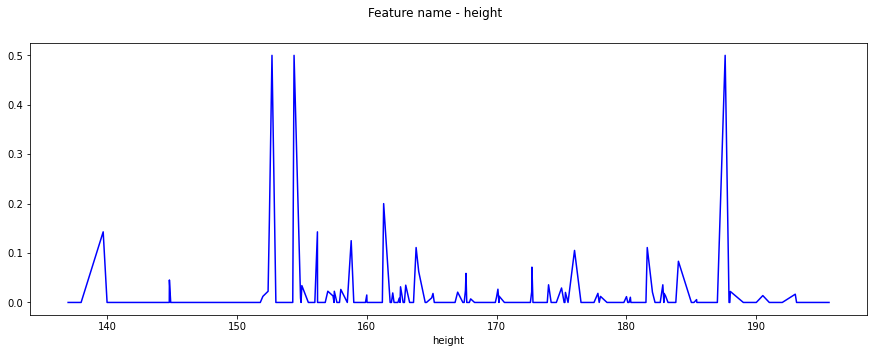

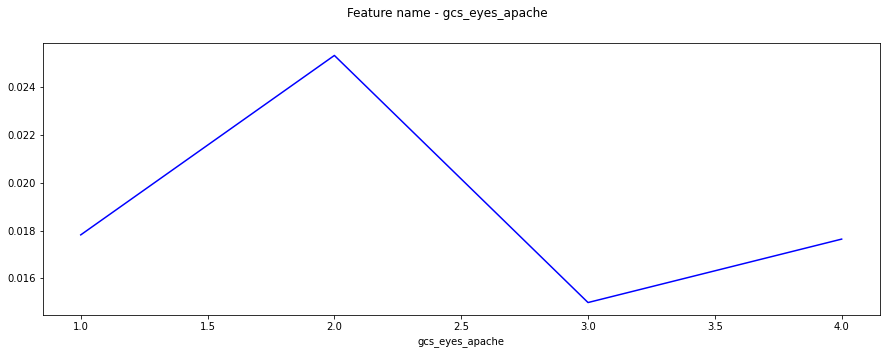

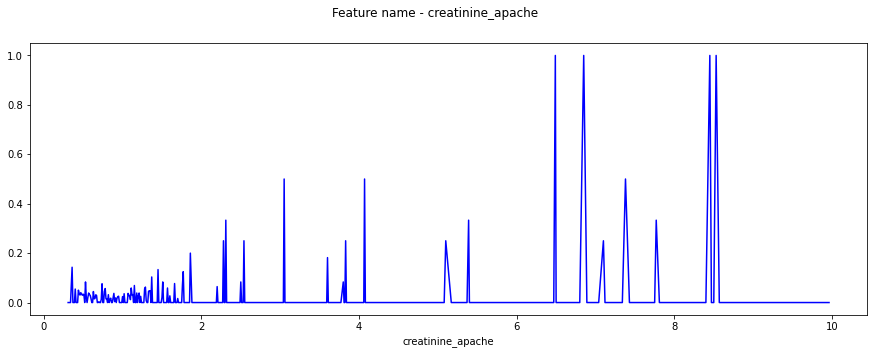

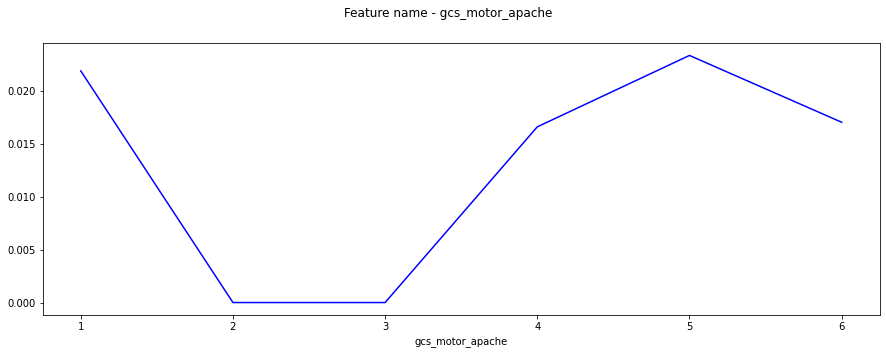

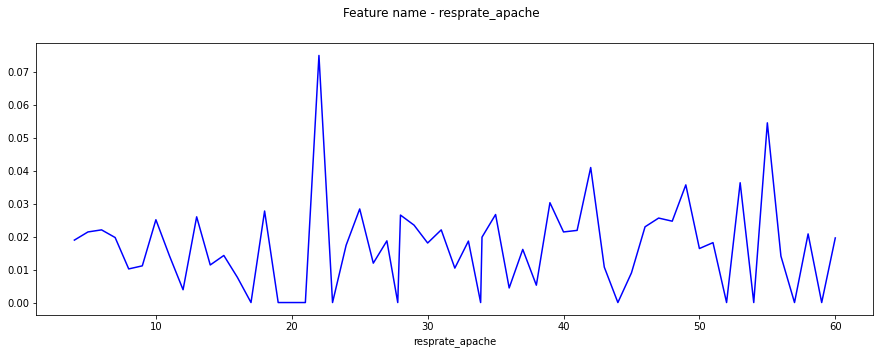

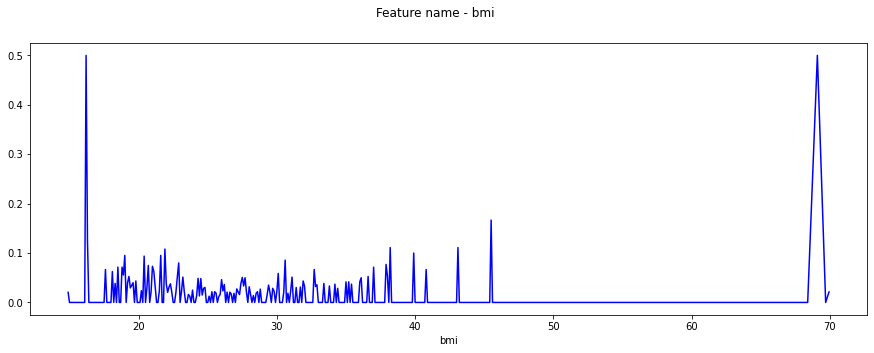

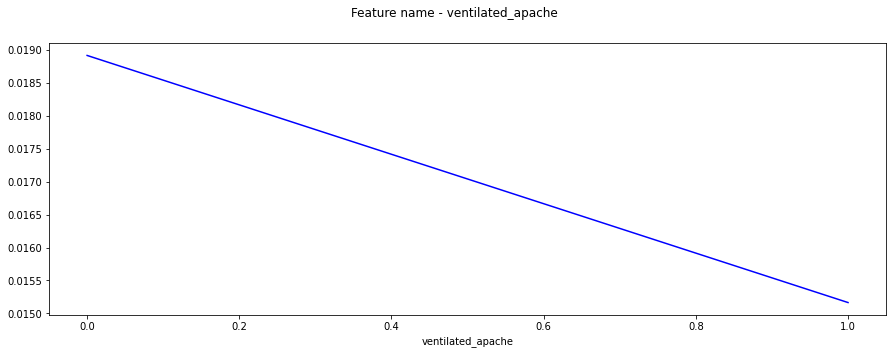

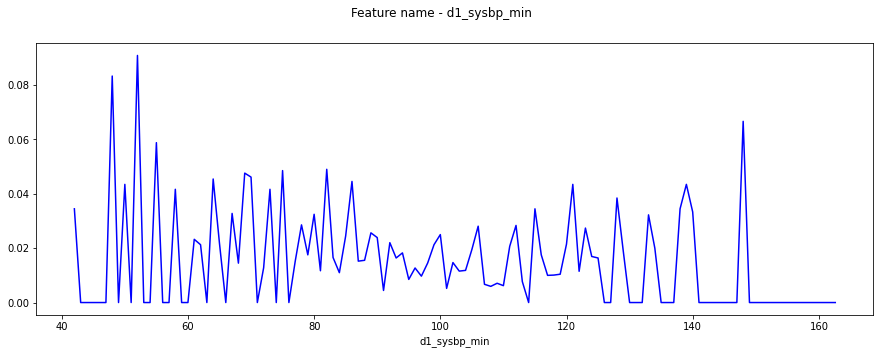

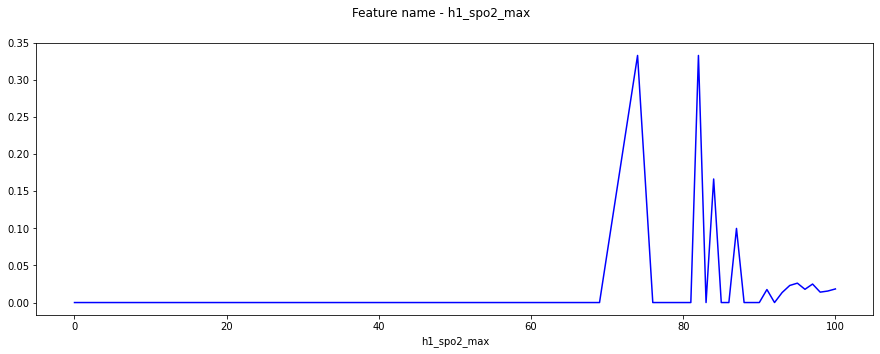

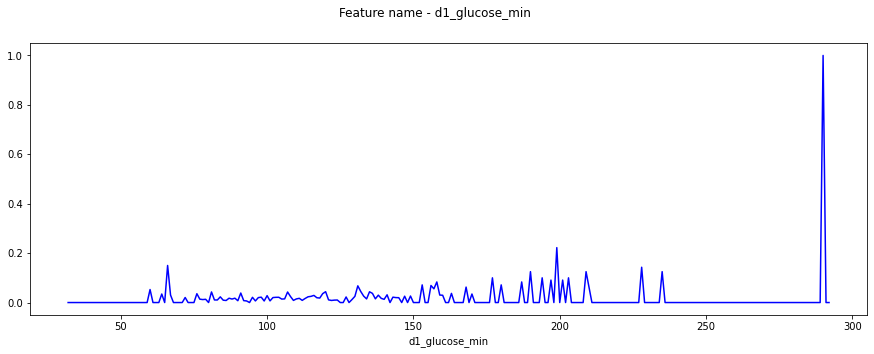

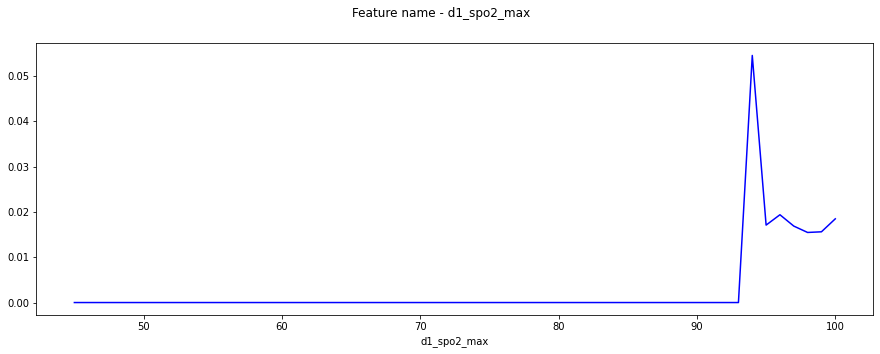

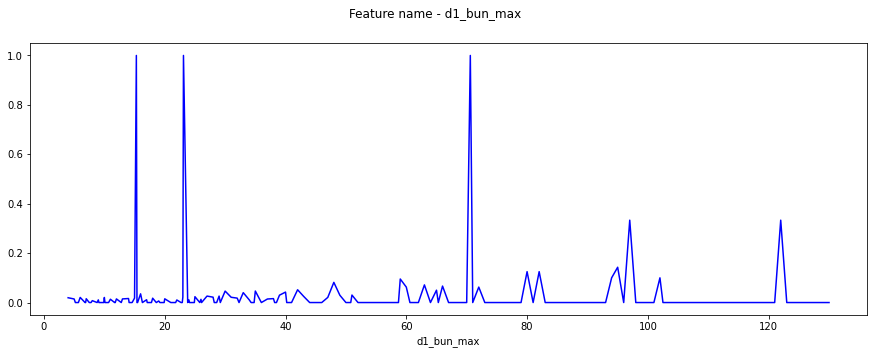

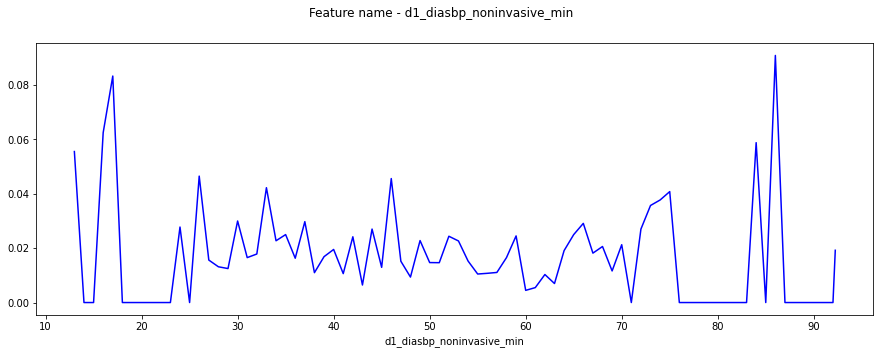

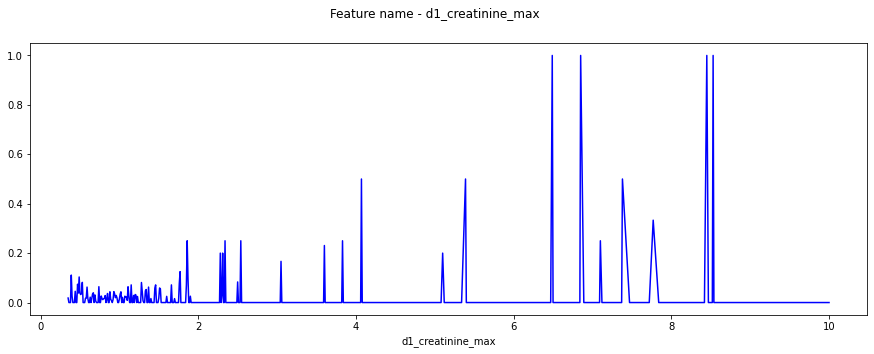

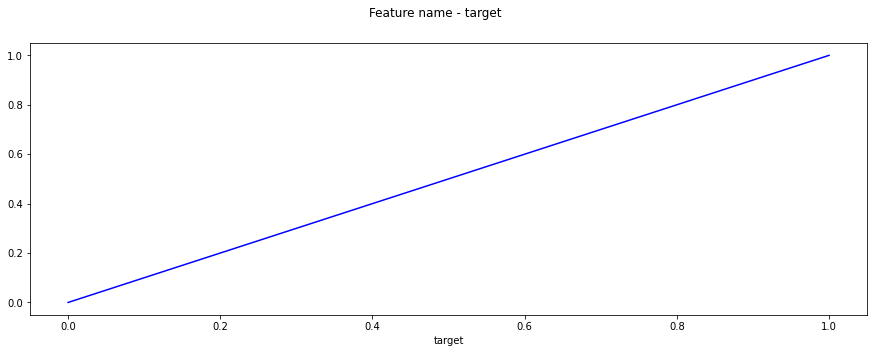

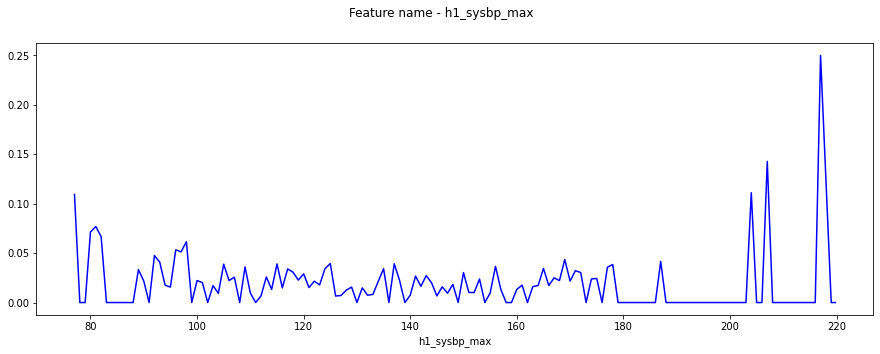

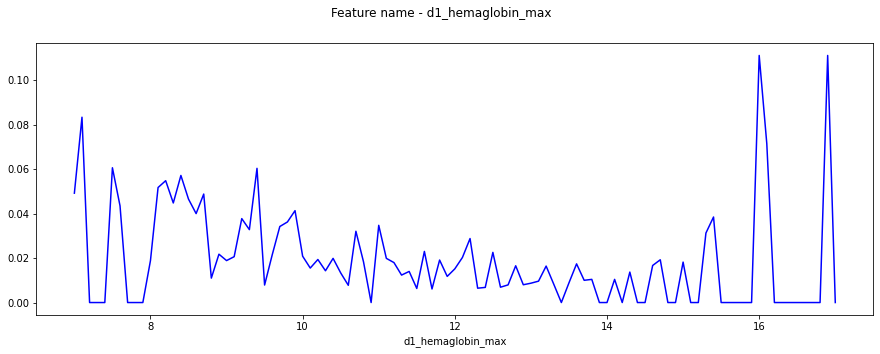

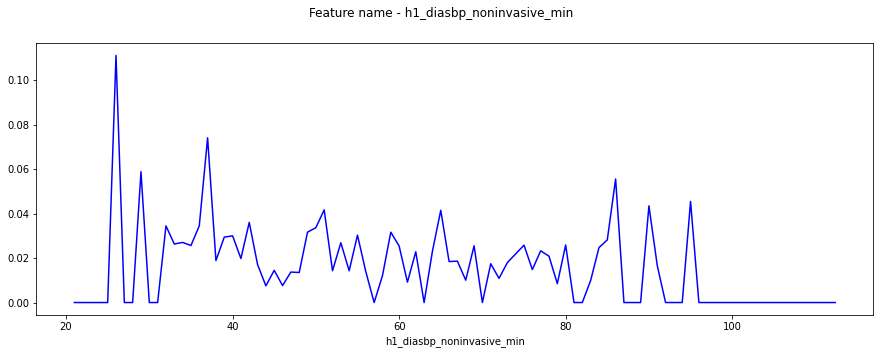

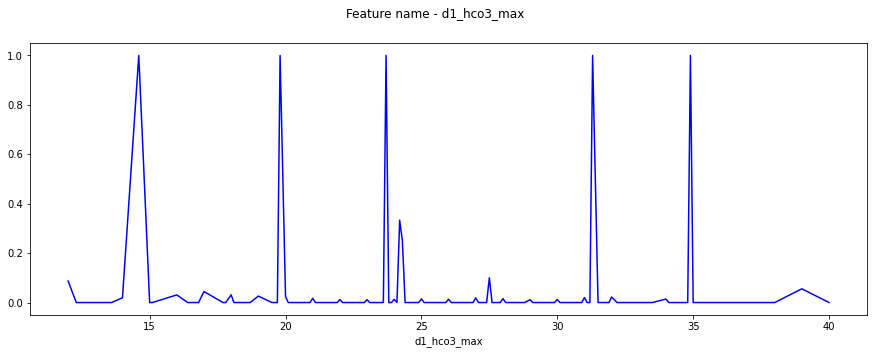

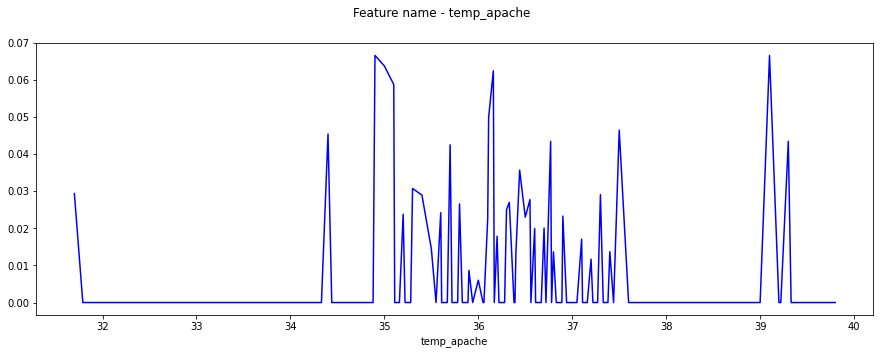

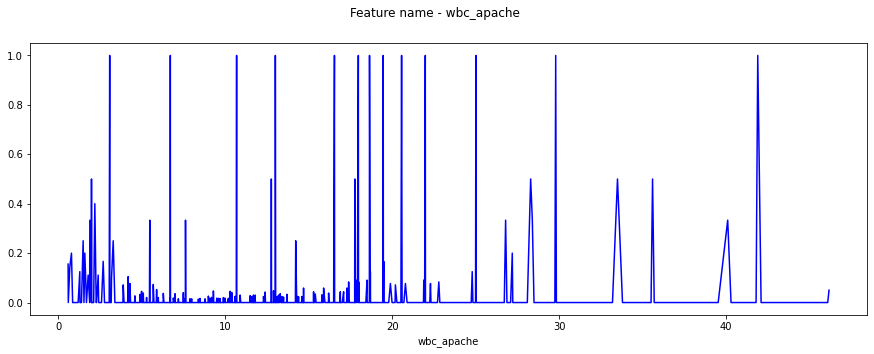

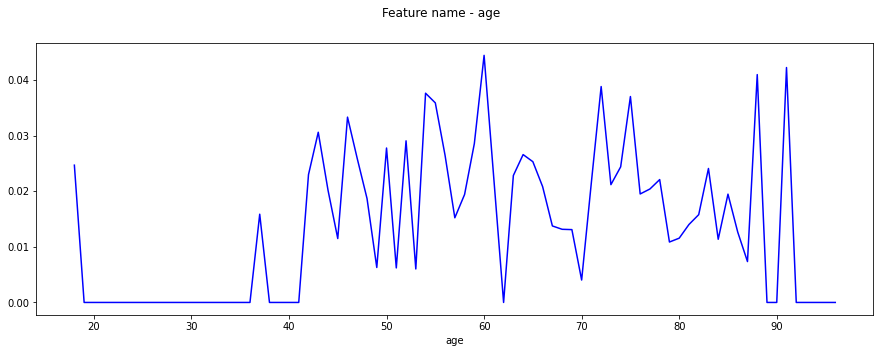

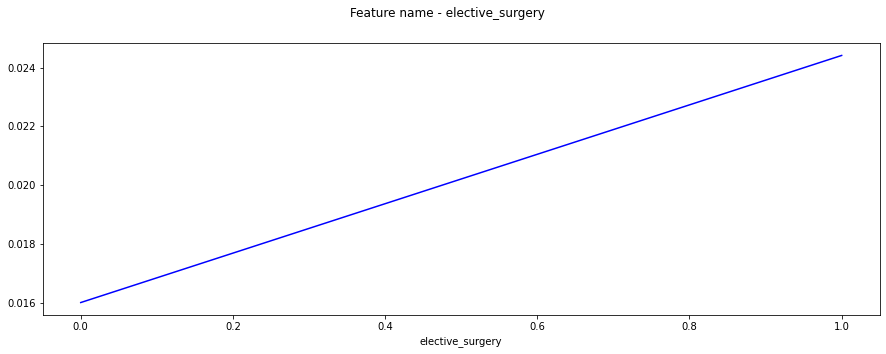

In [41]:
for col in numerical_n:
    fig = plt.figure(figsize=(15, 5))
    plt.suptitle(f"Feature name - {col}")
    data_n.groupby([col])["target"].mean().plot(color="blue")

# boxcox

In [42]:
data_linear = data_n.copy()

In [43]:
col_continue = []
for i in data_n[numerical_n]:
    if data_n[i].nunique() > 2 and data_n[i].min() >= 0:
        col_continue.append(i)

In [44]:
col_2 = []
for i in data_n[numerical_n]:
    if data_n[i].nunique() == 2:
        col_2.append(i)

In [45]:
data_linear = data_linear[col_continue]

In [46]:
# for i in data_linear:
#     data_linear[i] = data_linear[i].fillna(data_linear[i].median())

In [47]:
data_linear = data_linear + 1

In [48]:


# data_n = data_n.drop("target", axis=1)
# numerical_n.remove("target")
for i in data_linear:
#     print(i, (data_linear[i] < 0).sum())
    data_linear[i] = stats.boxcox(data_linear[i])[0]


In [49]:
col_2

['aids',
 'apache_post_operative',
 'gcs_unable_apache',
 'arf_apache',
 'hepatic_failure',
 'intubated_apache',
 'cirrhosis',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'ventilated_apache',
 'target',
 'elective_surgery']

In [50]:
data_linear[col_2] = data_n[col_2]

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


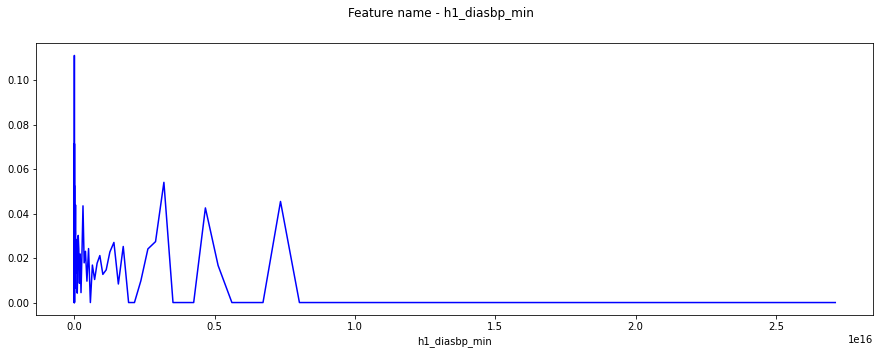

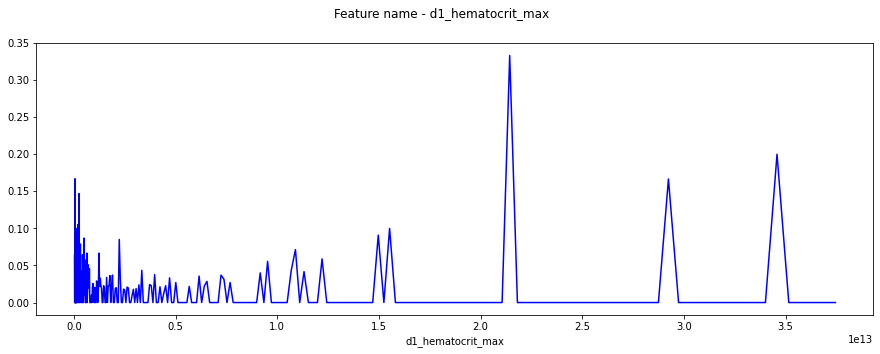

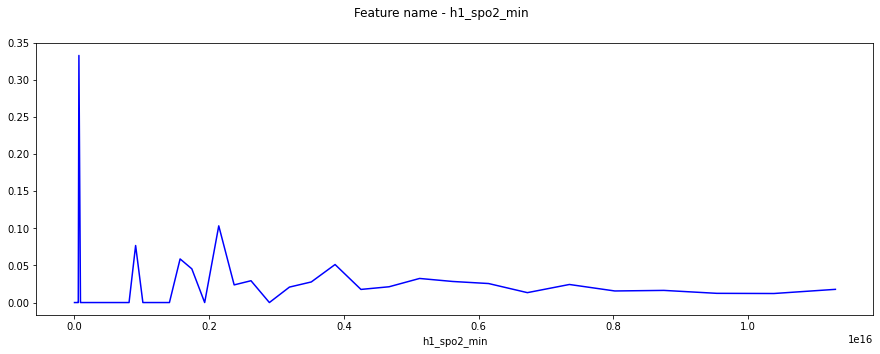

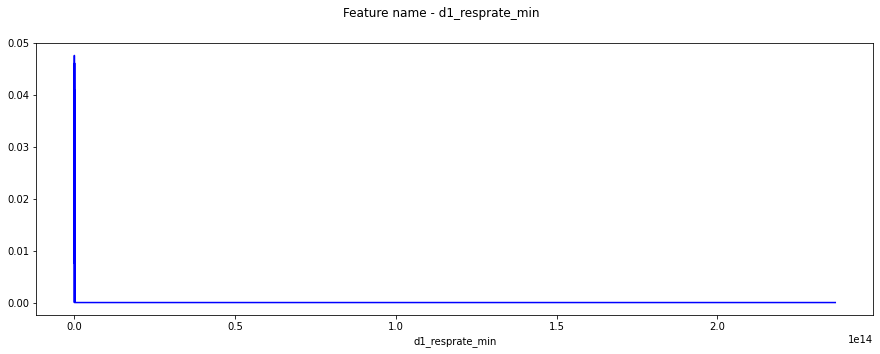

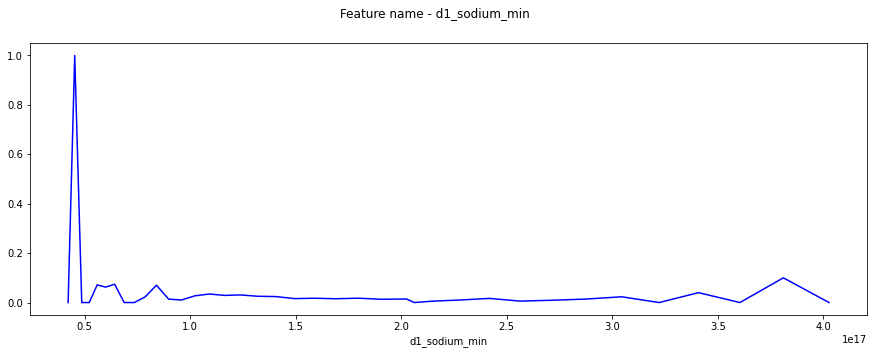

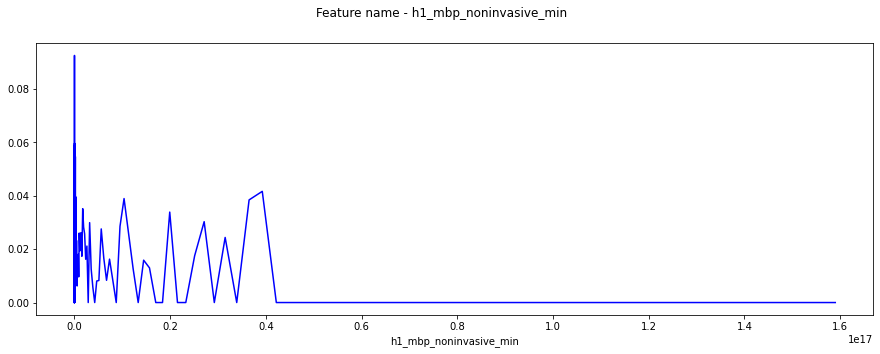

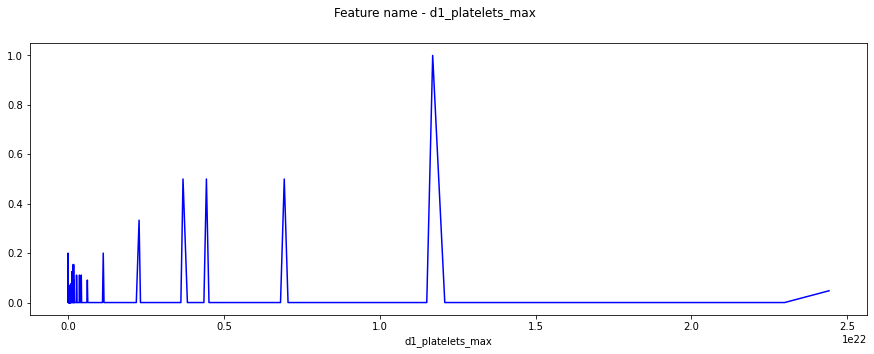

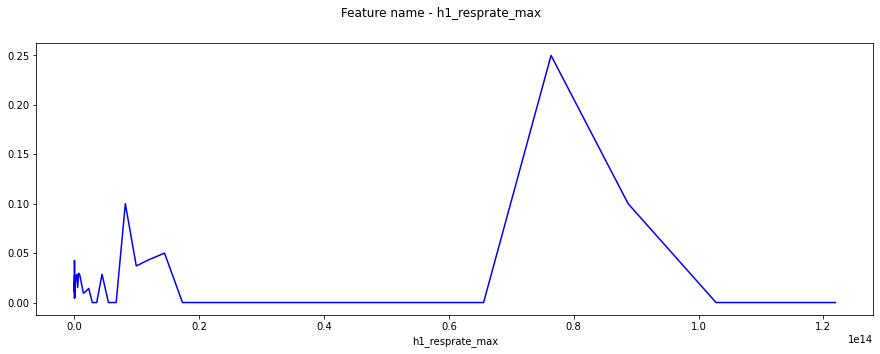

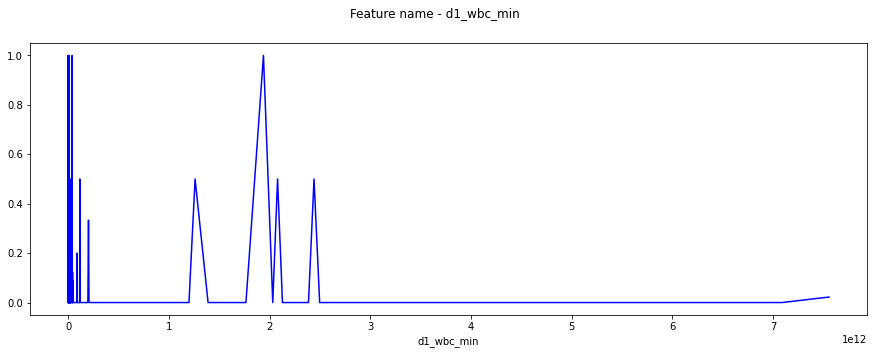

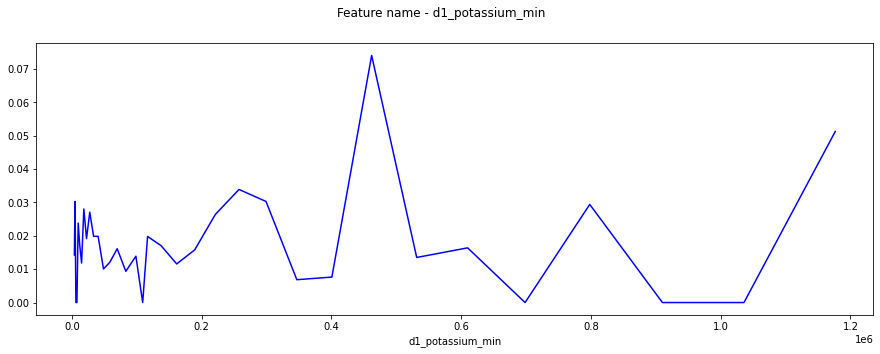

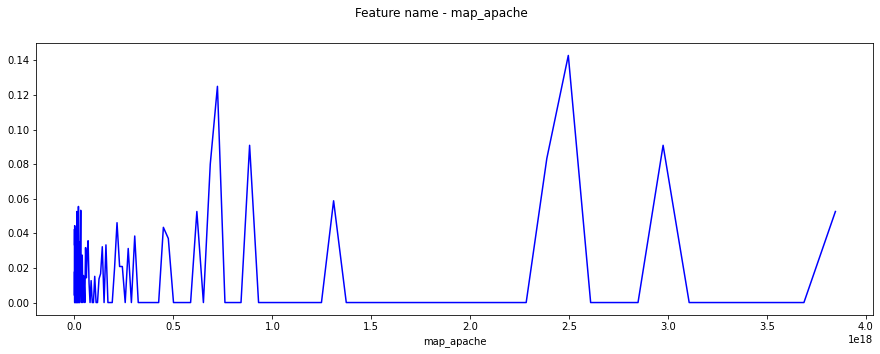

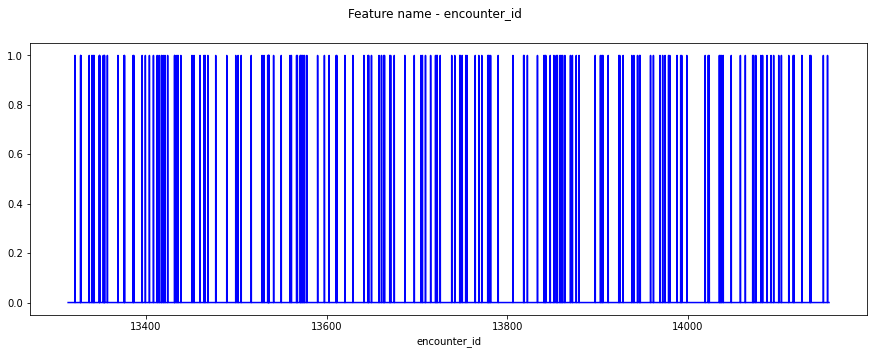

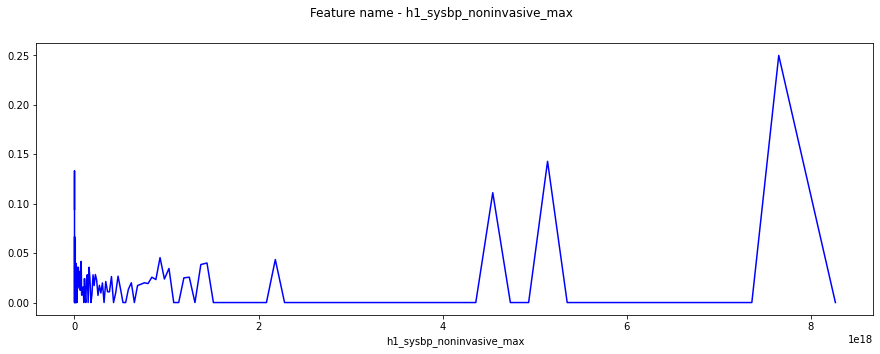

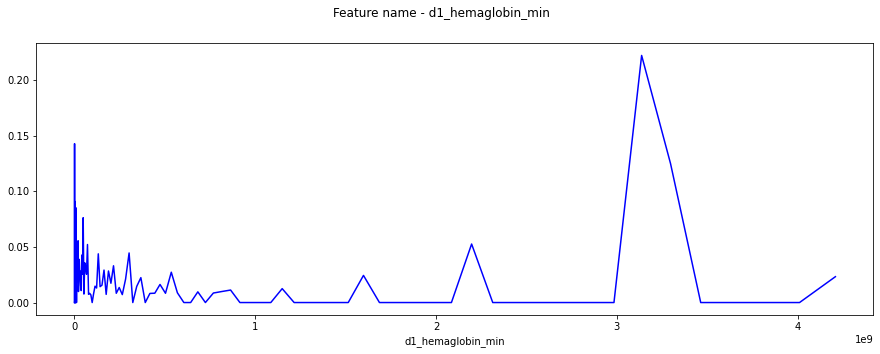

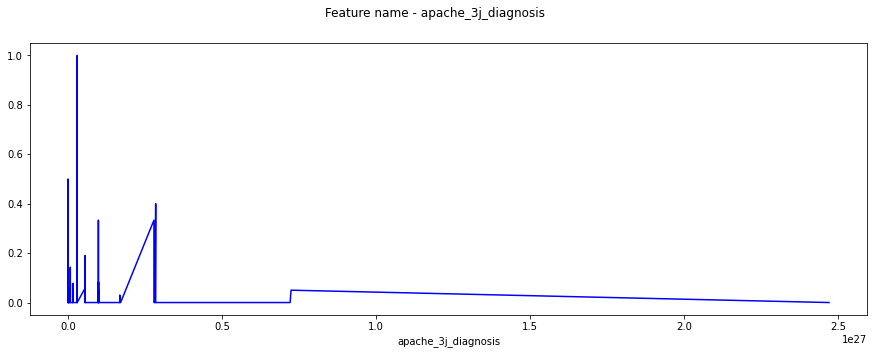

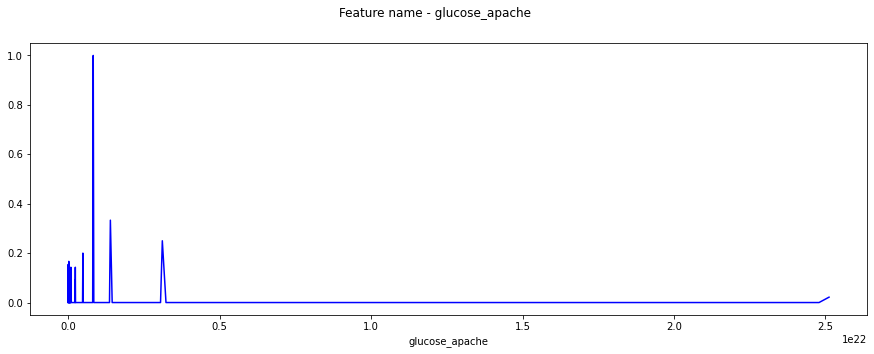

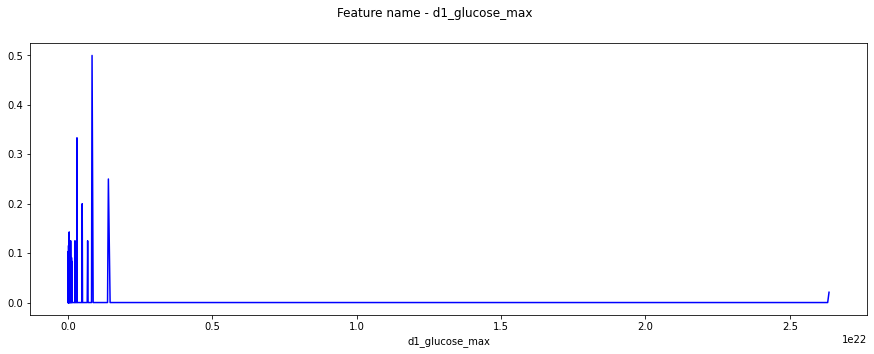

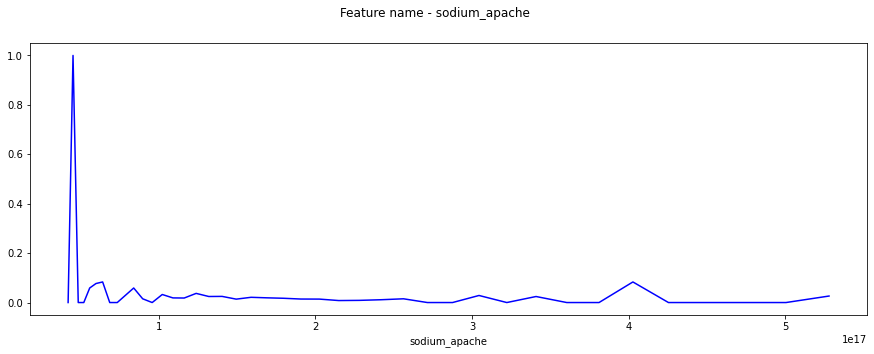

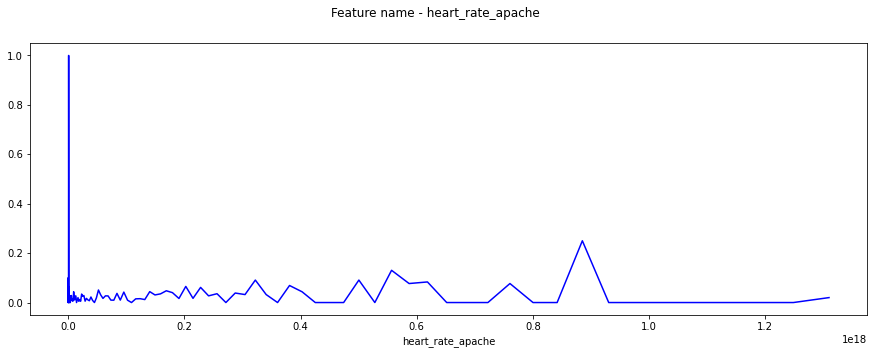

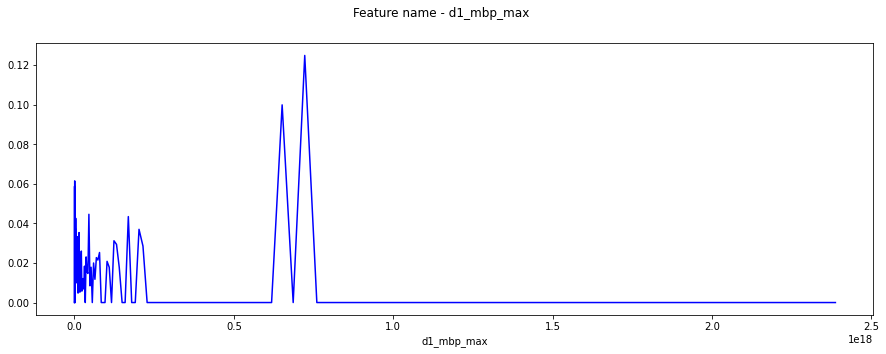

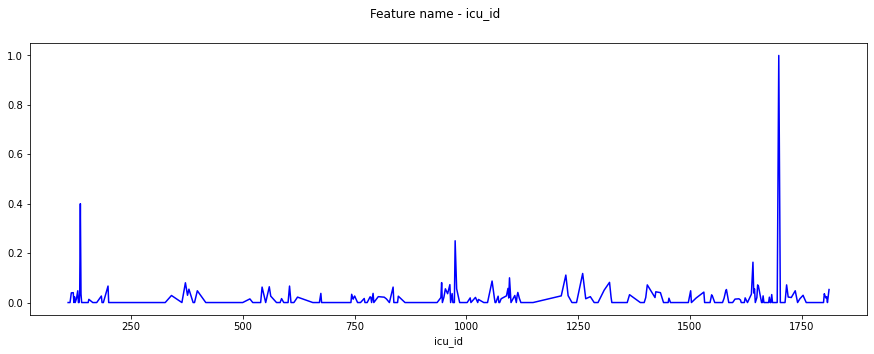

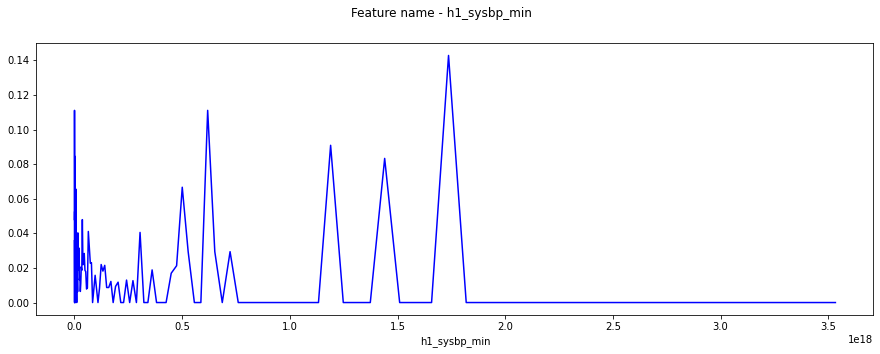

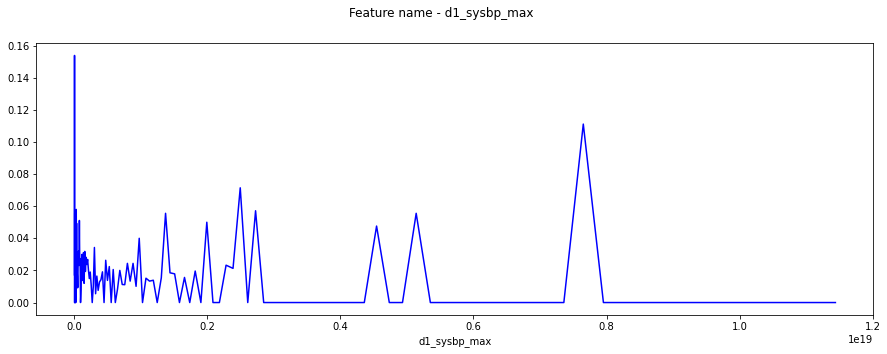

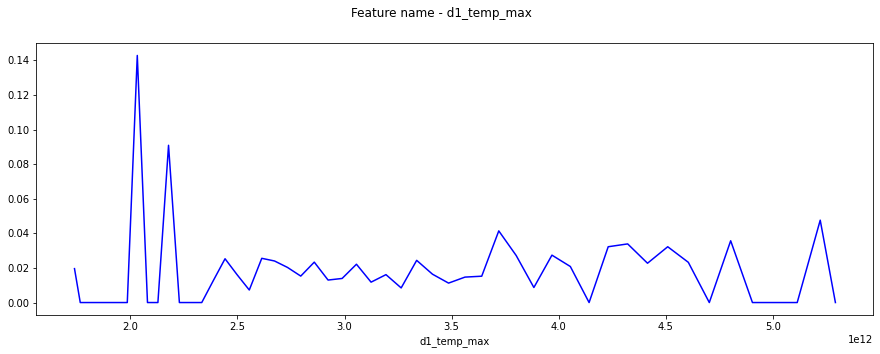

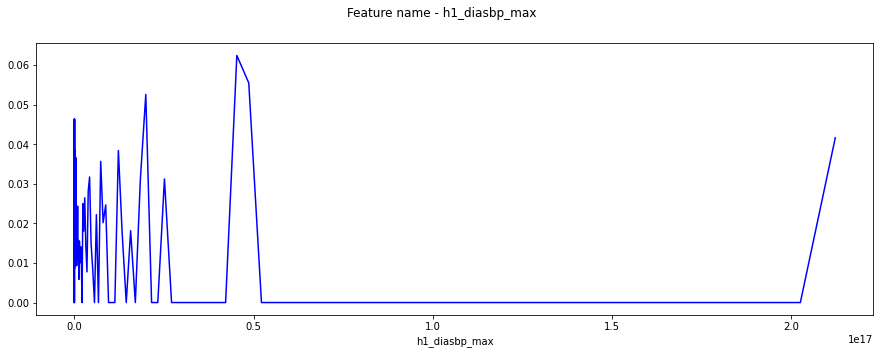

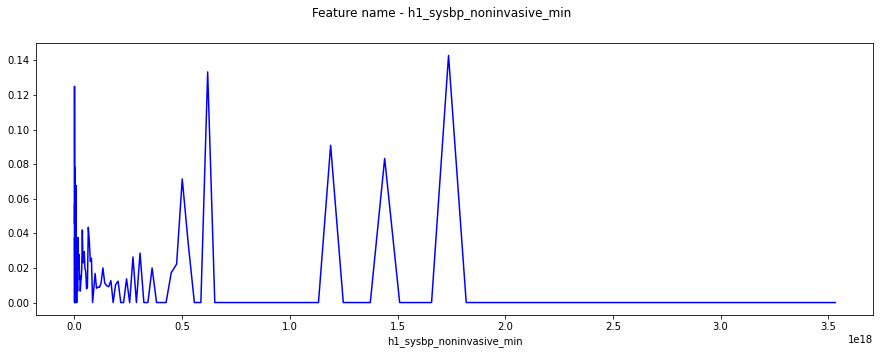

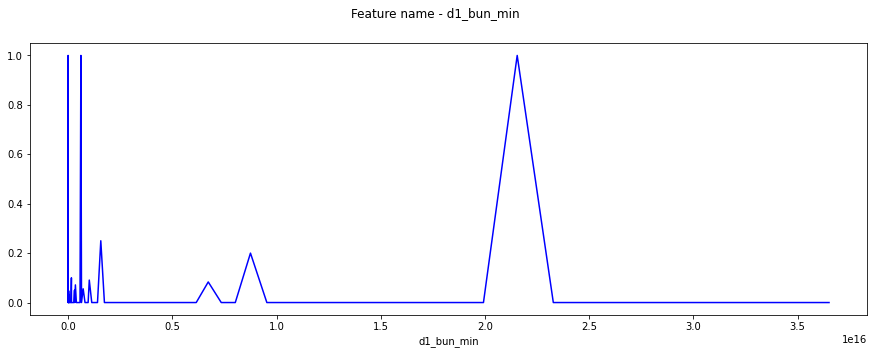

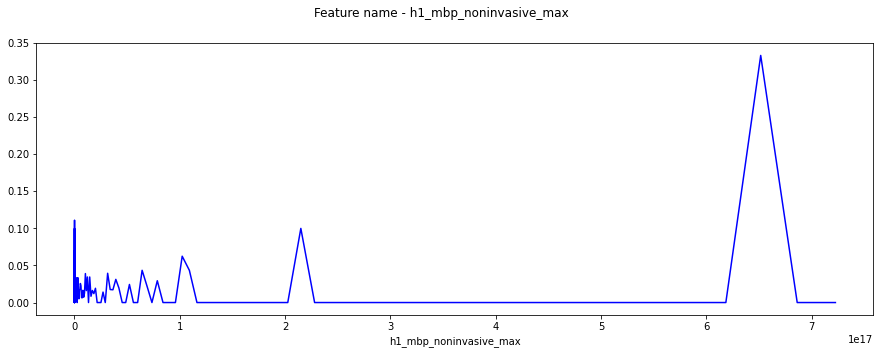

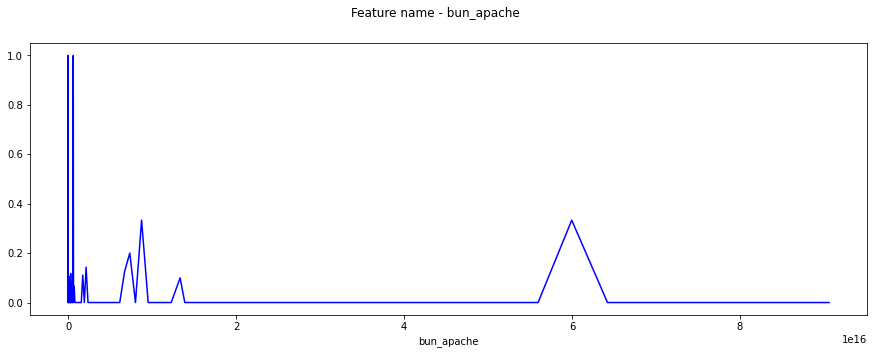

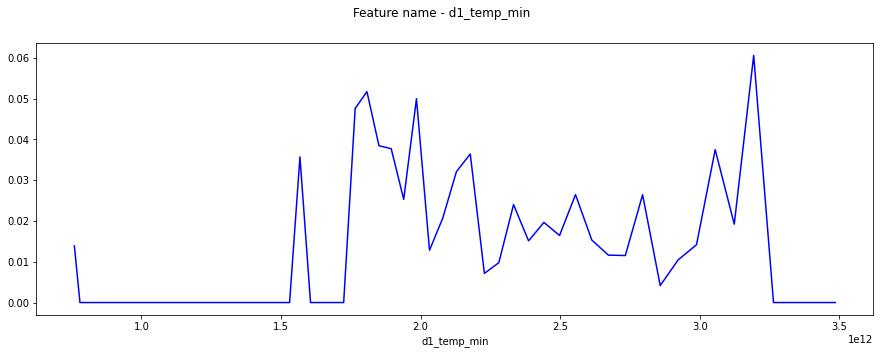

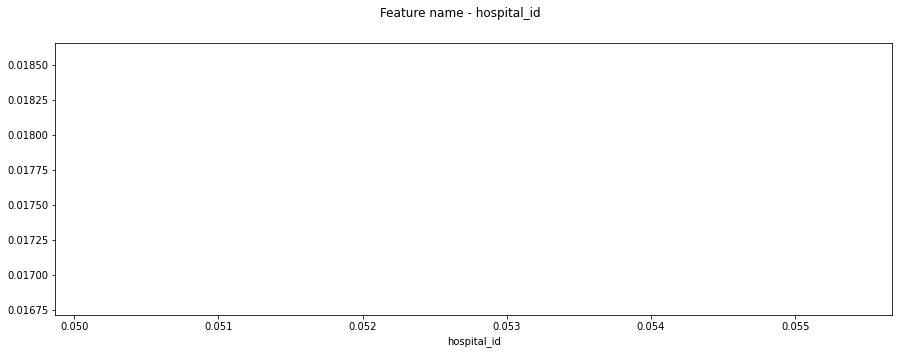

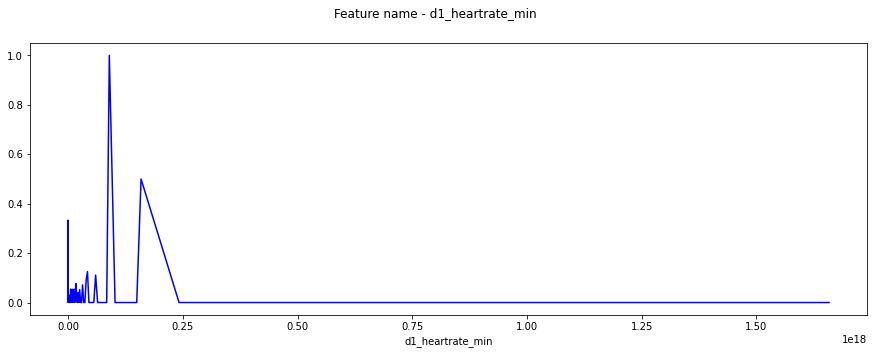

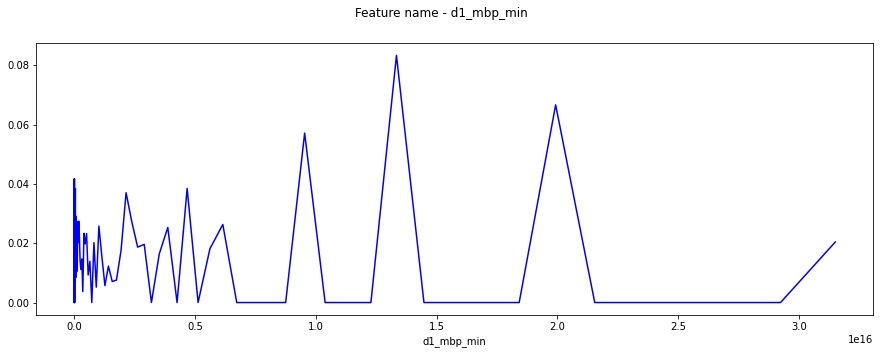

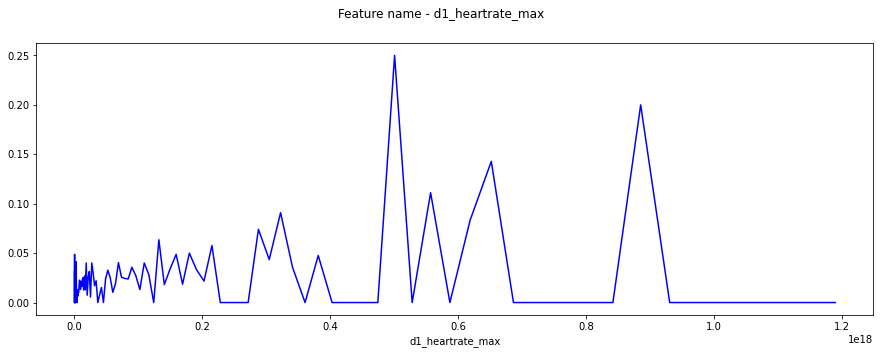

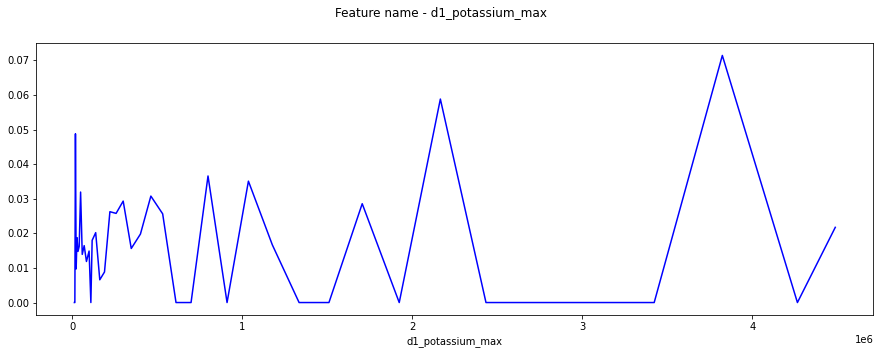

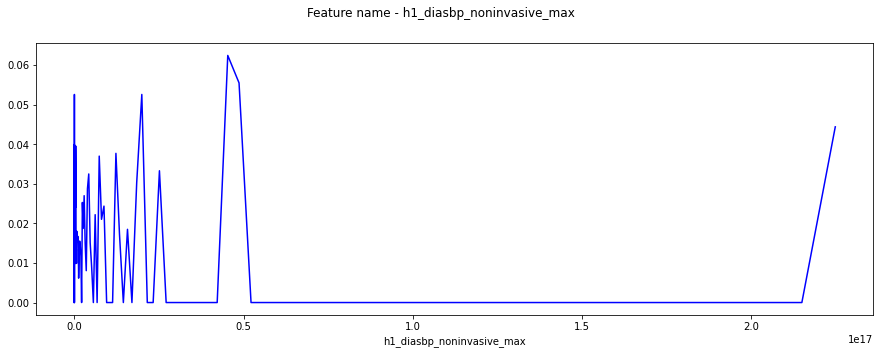

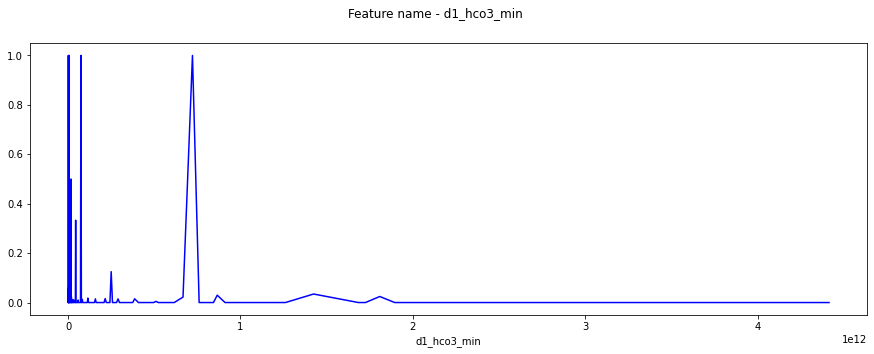

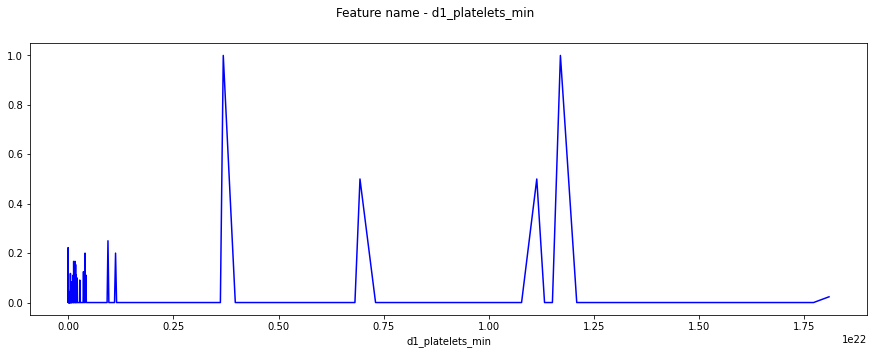

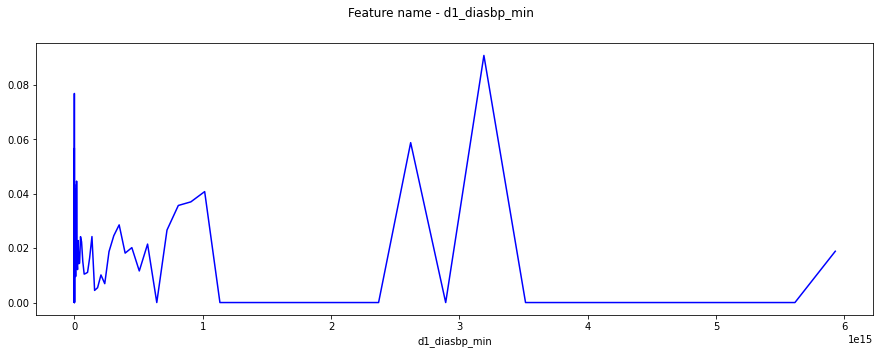

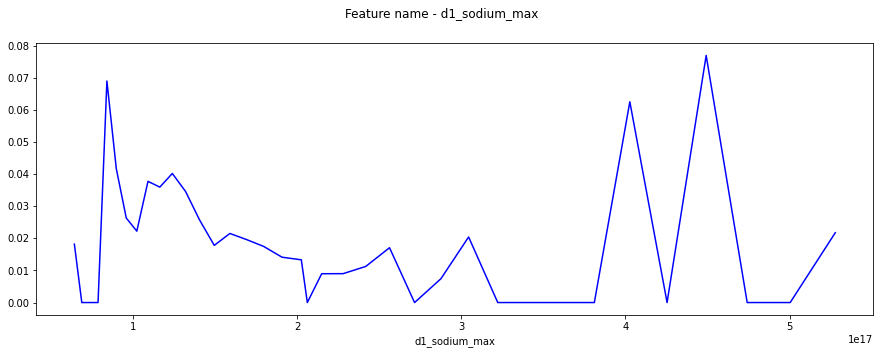

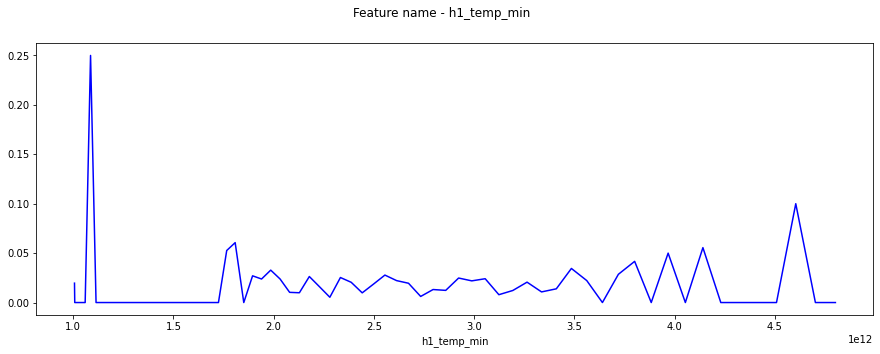

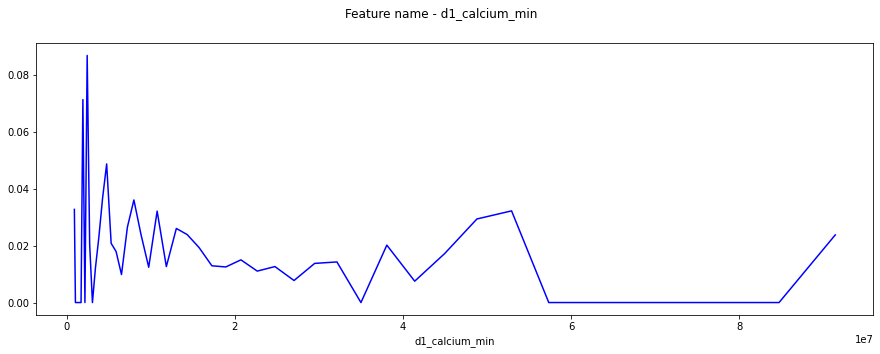

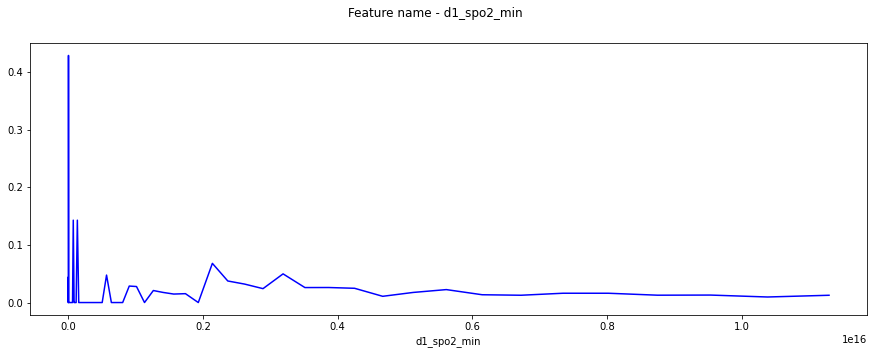

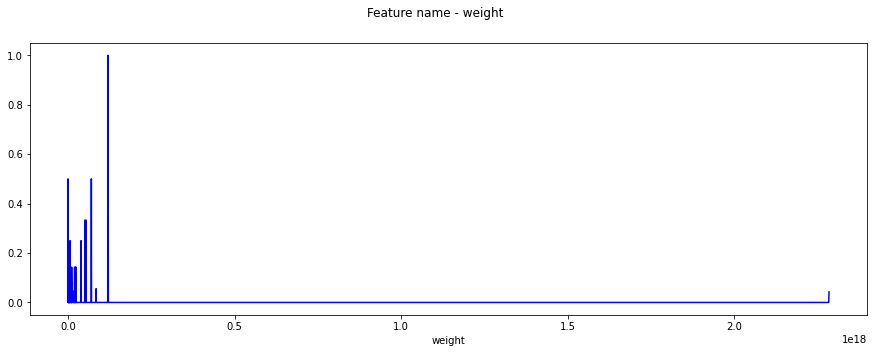

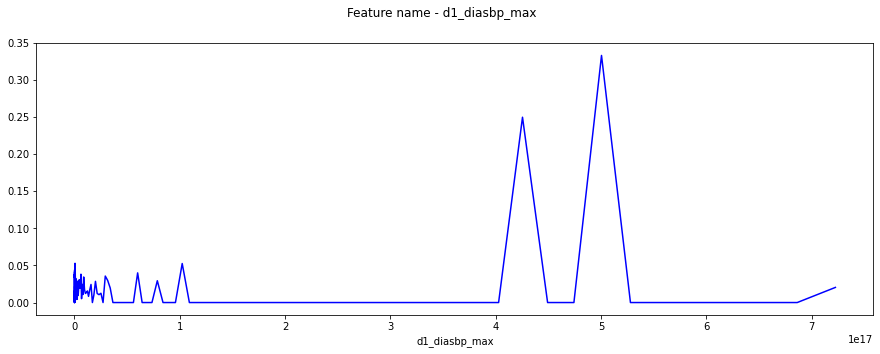

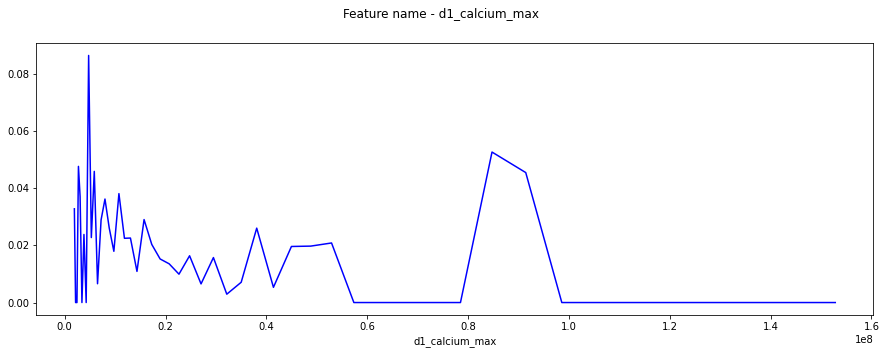

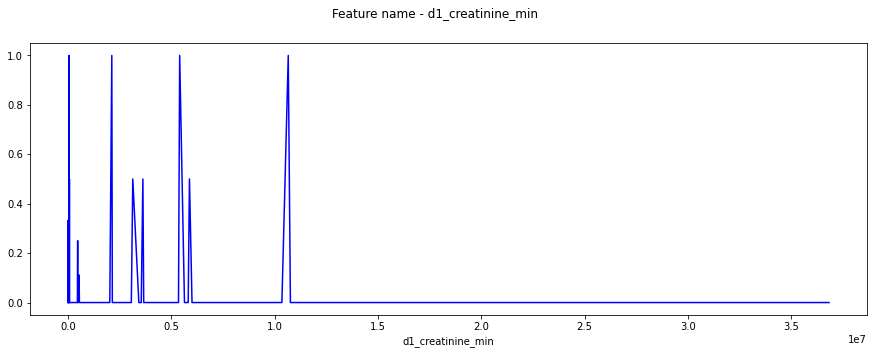

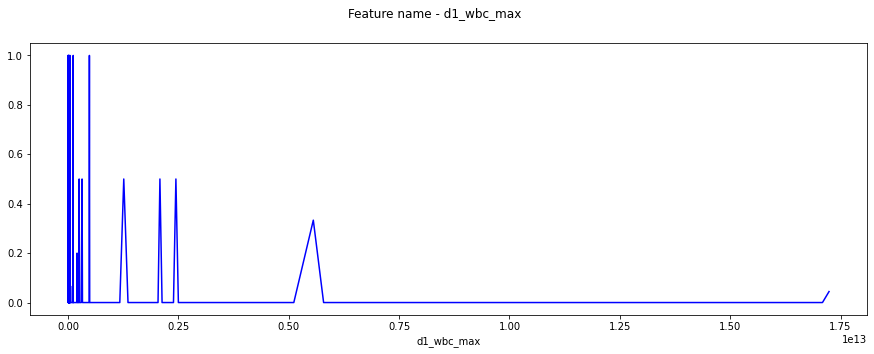

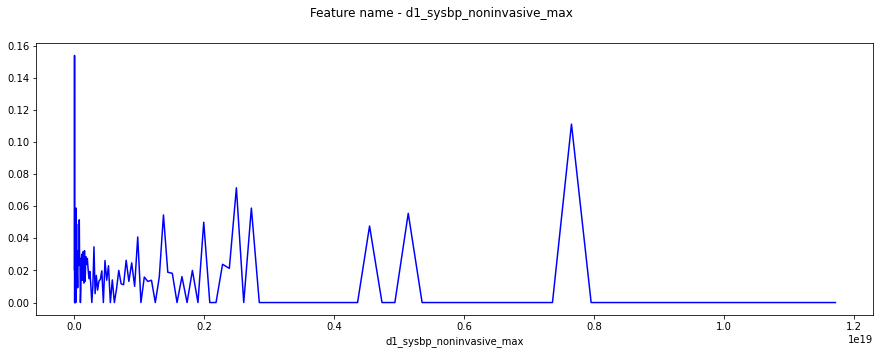

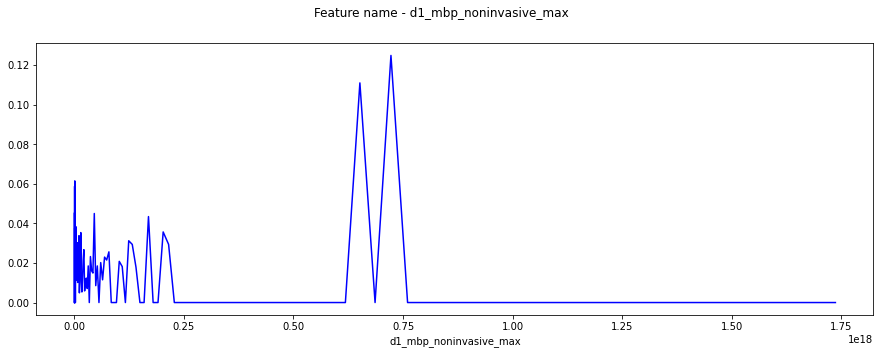

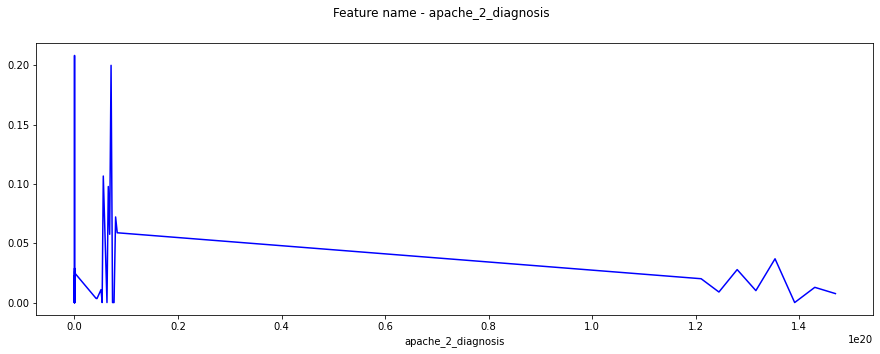

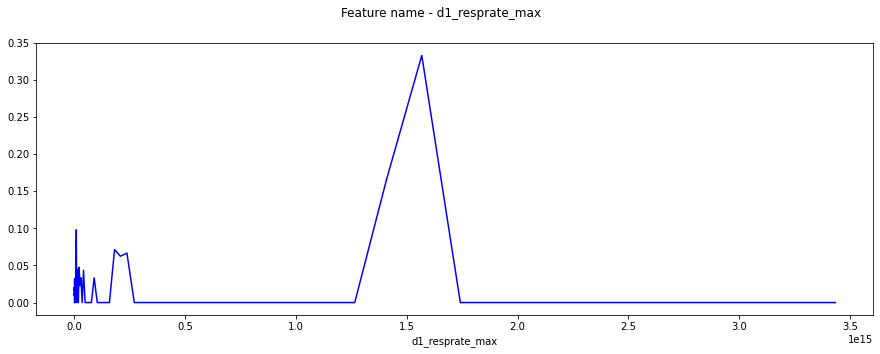

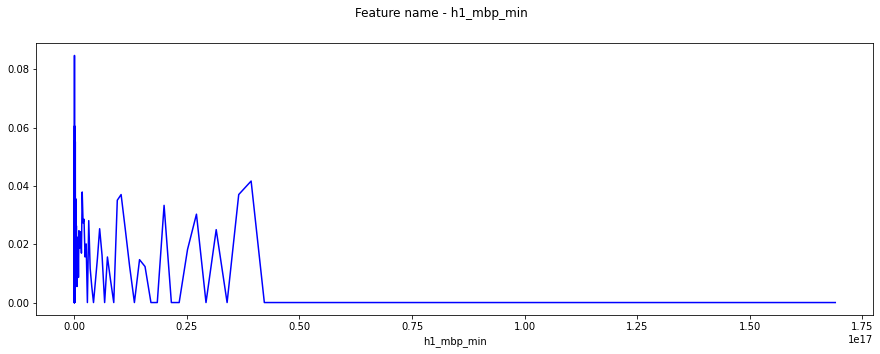

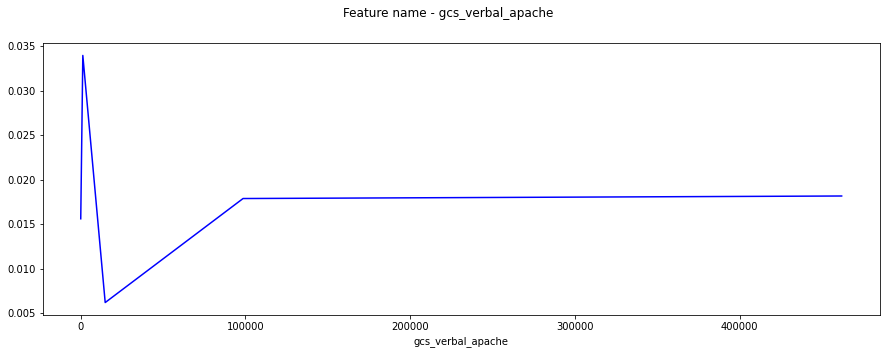

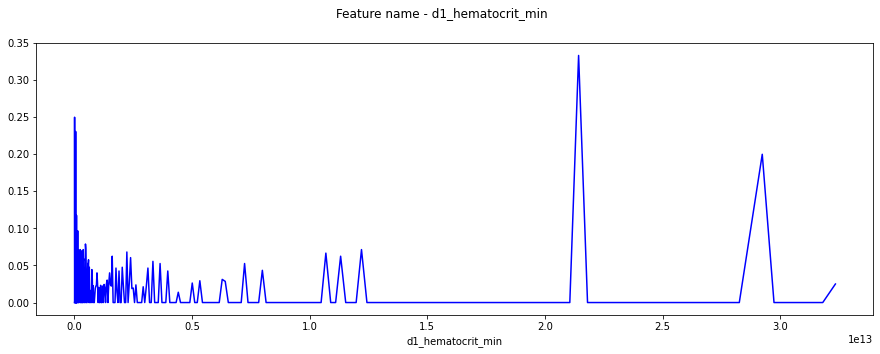

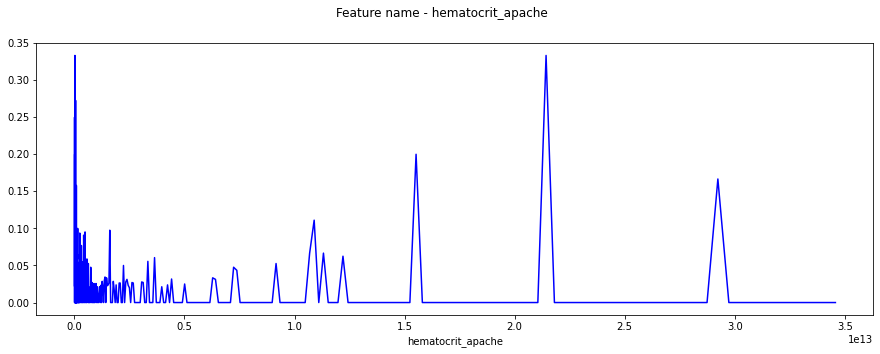

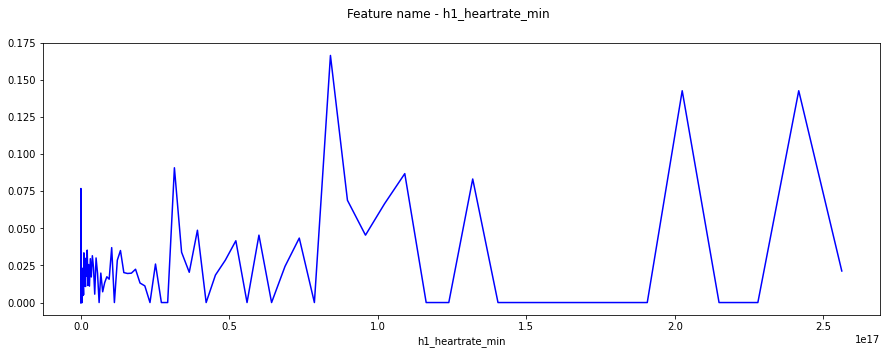

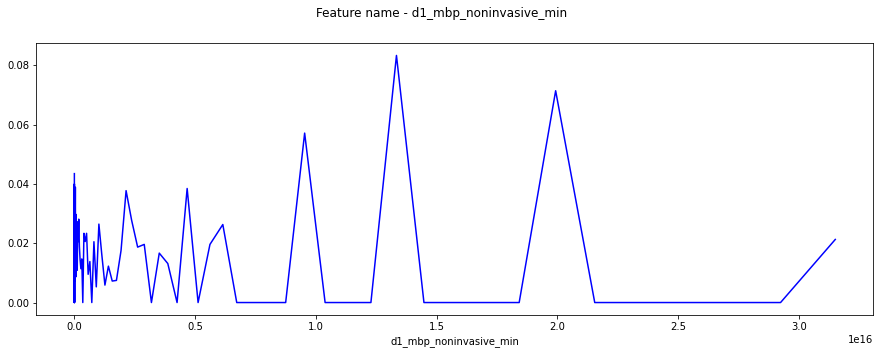

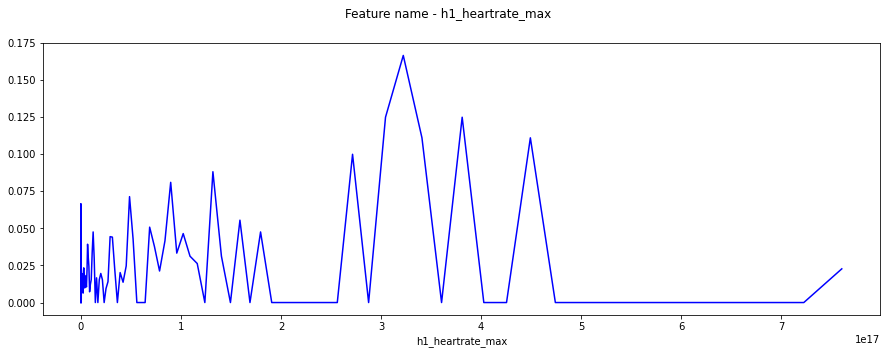

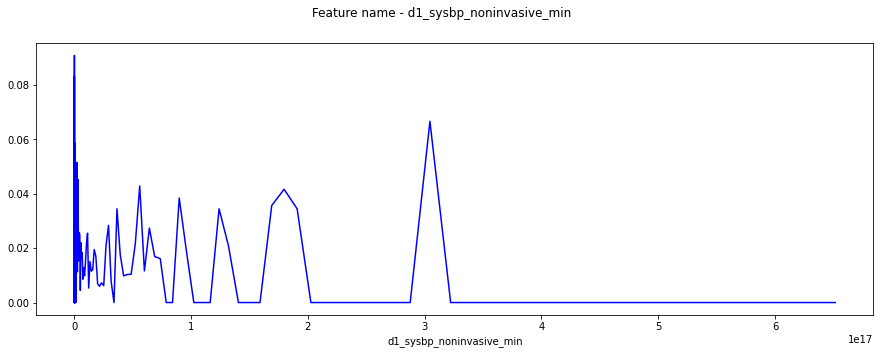

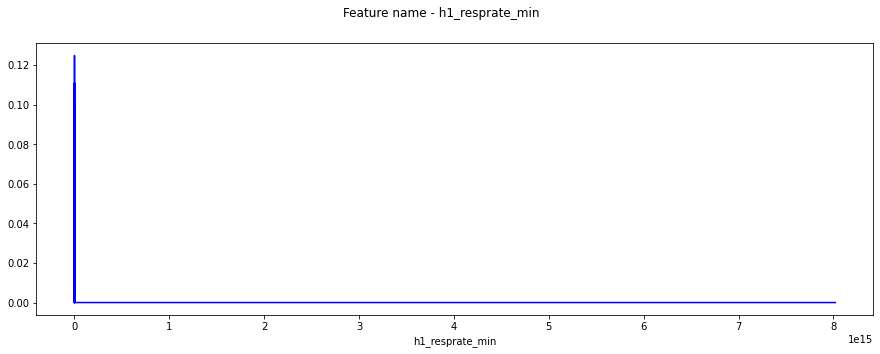

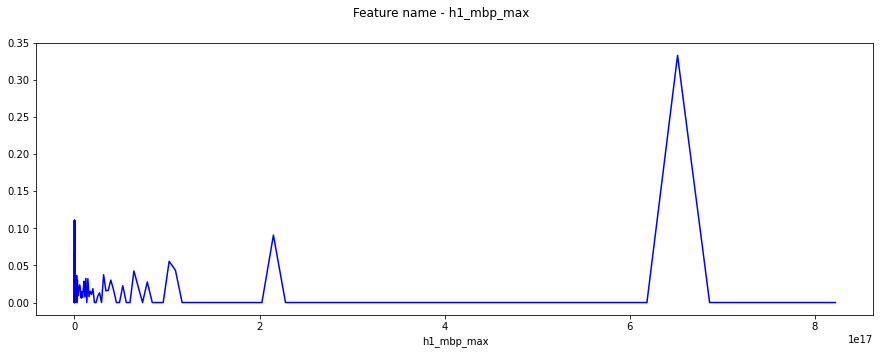

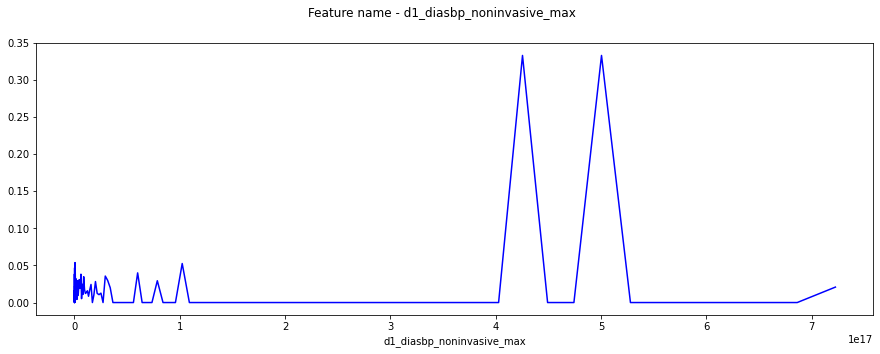

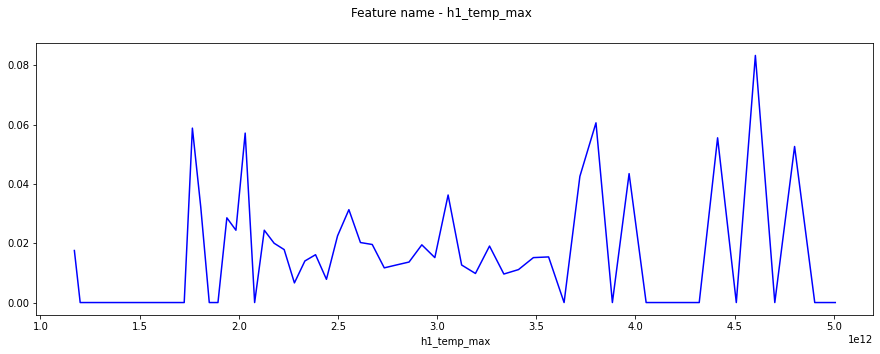

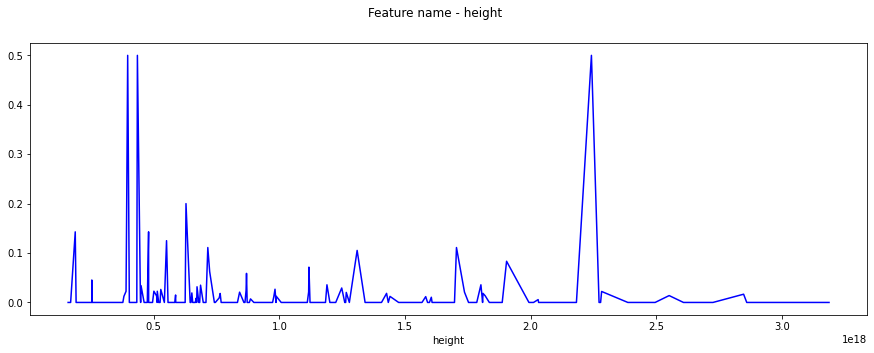

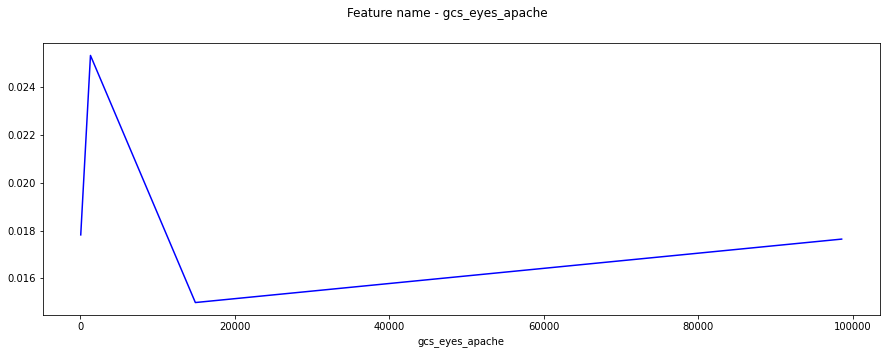

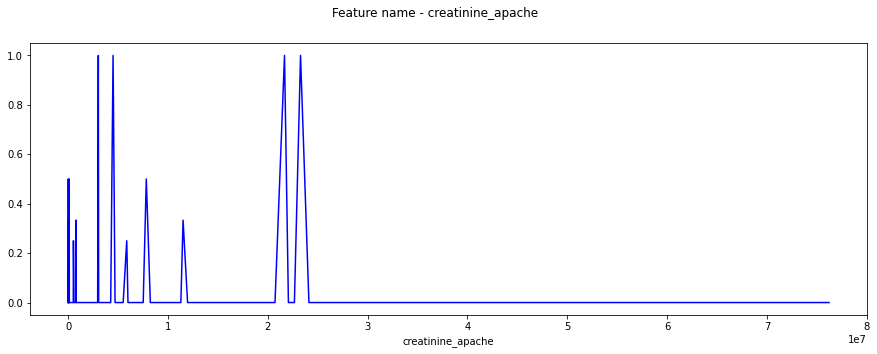

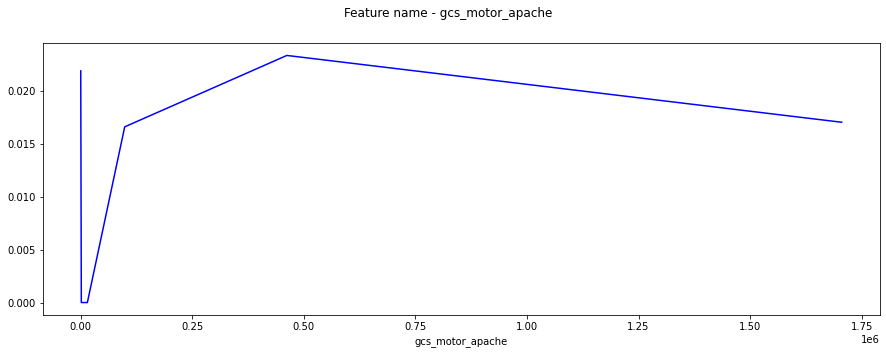

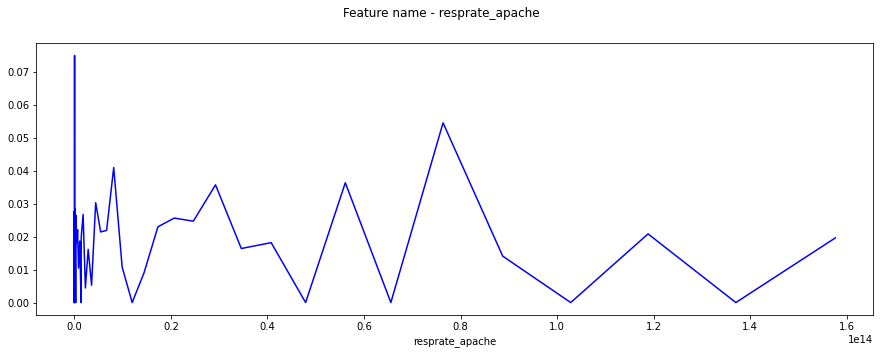

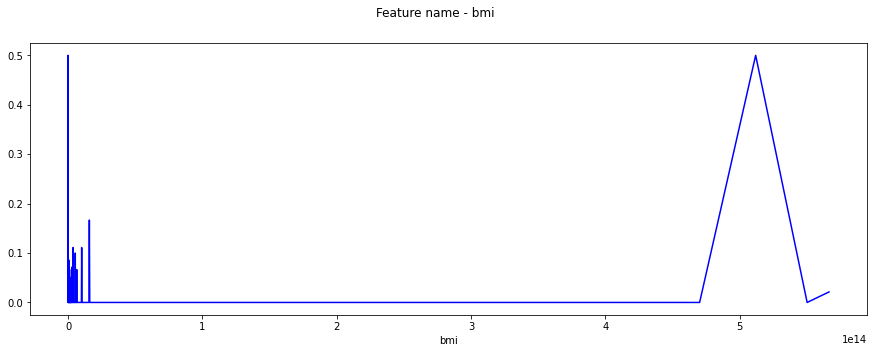

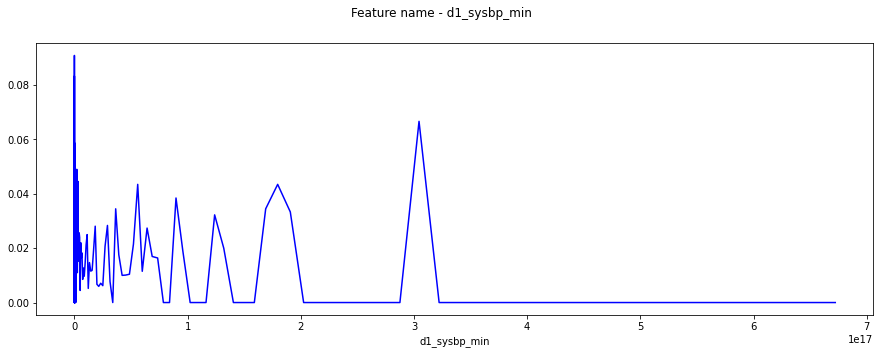

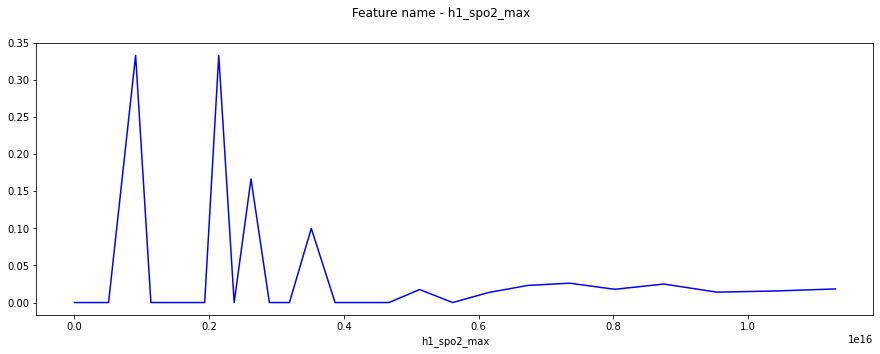

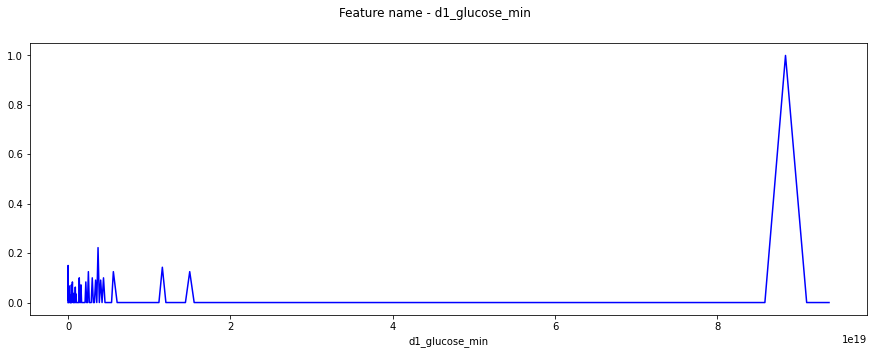

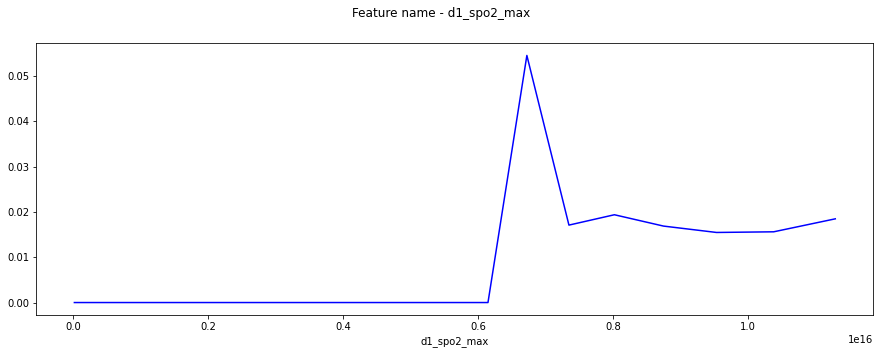

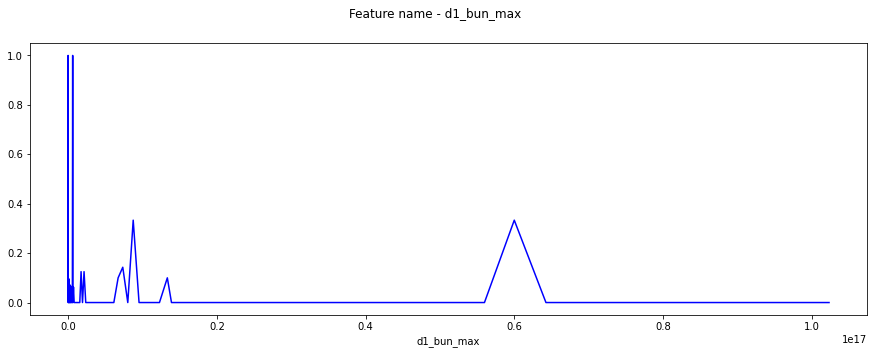

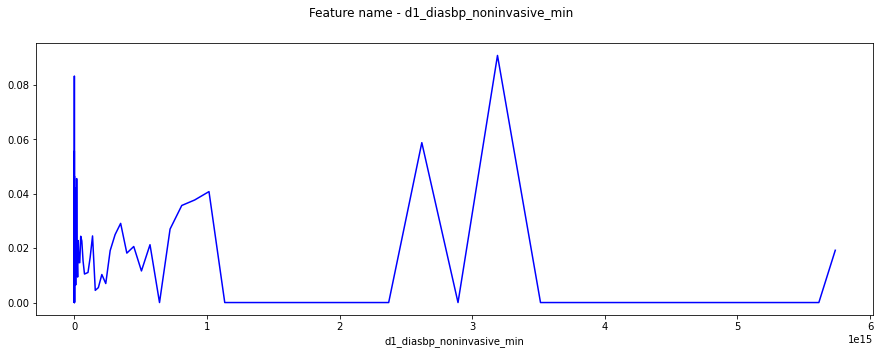

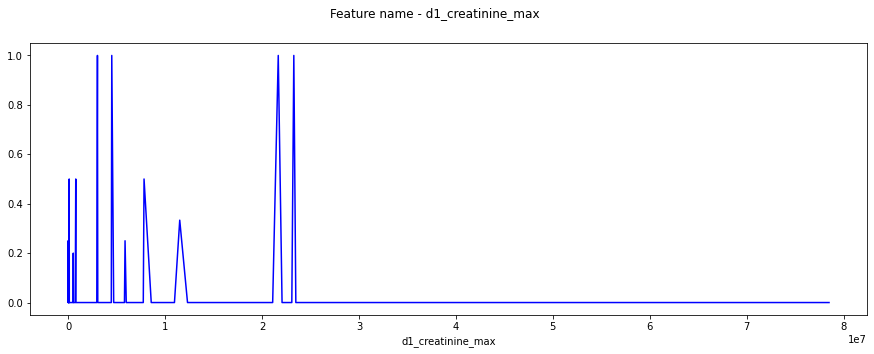

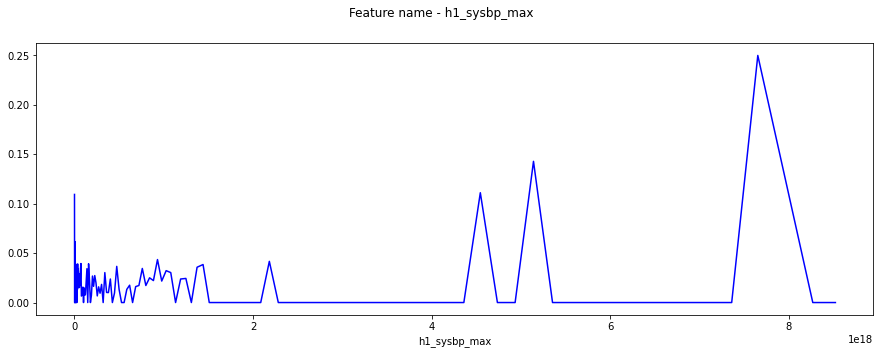

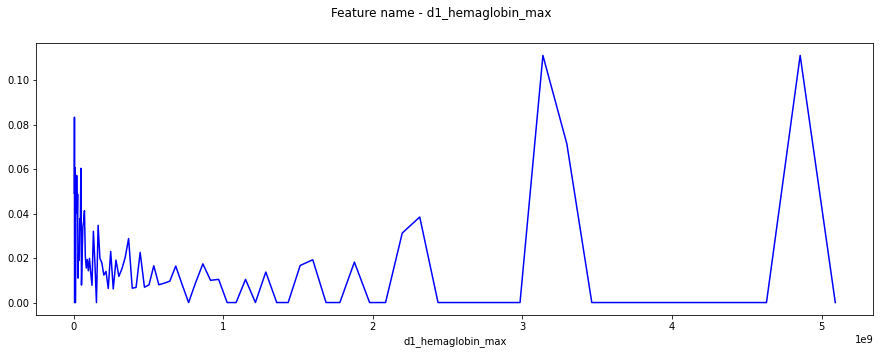

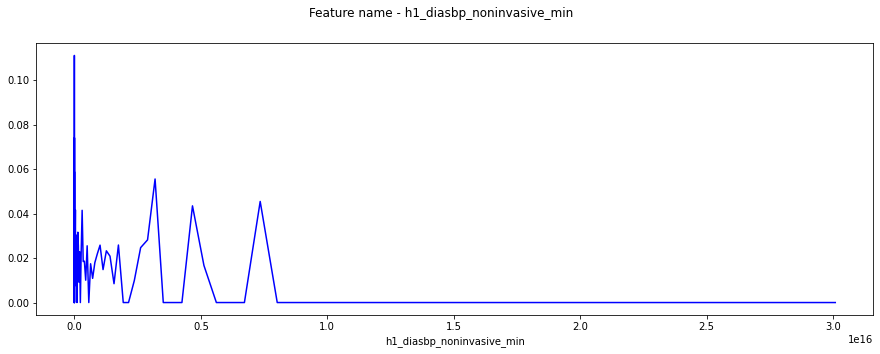

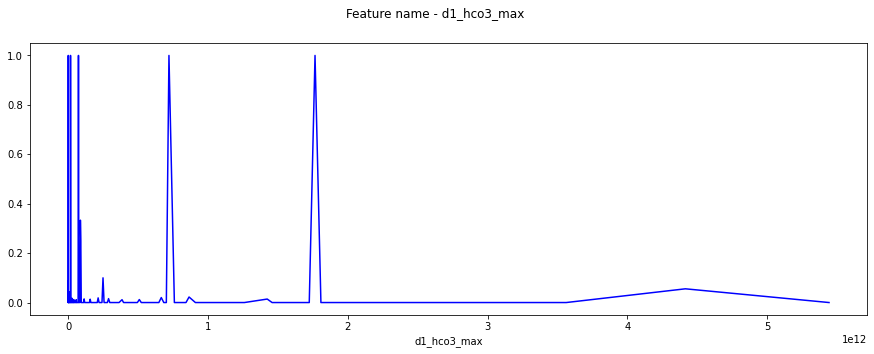

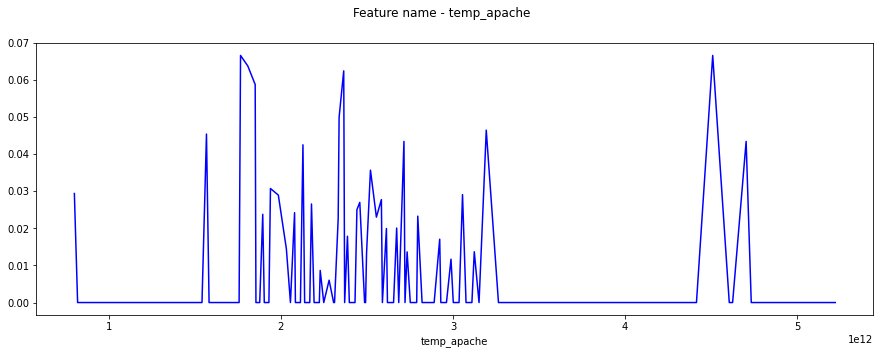

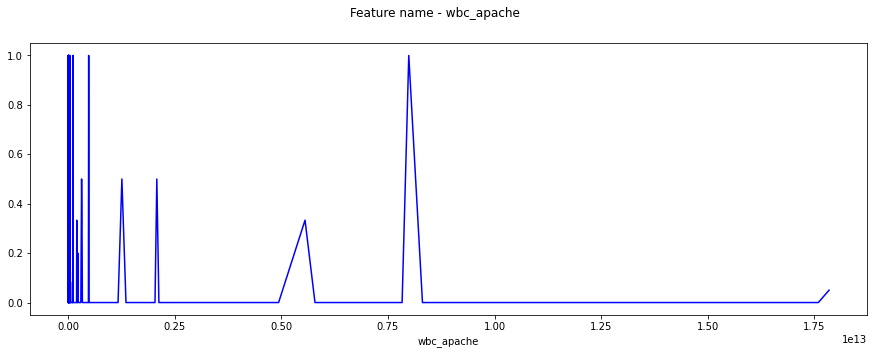

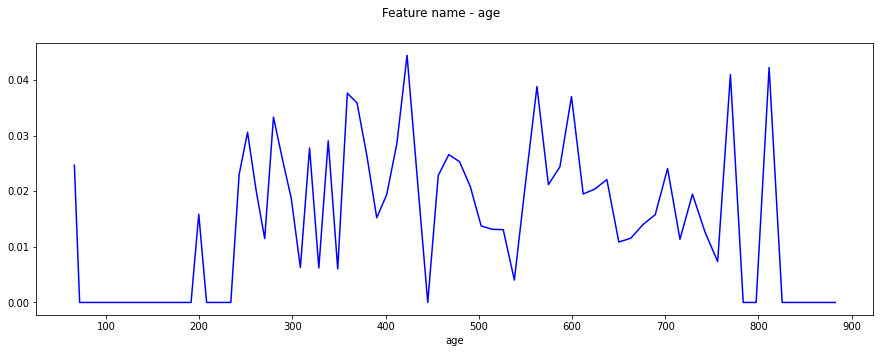

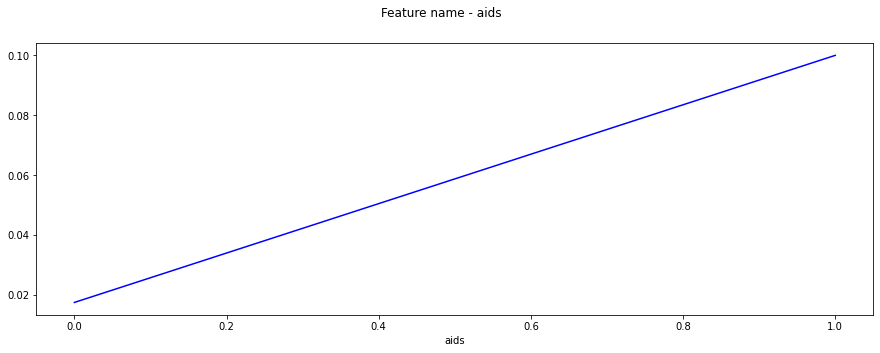

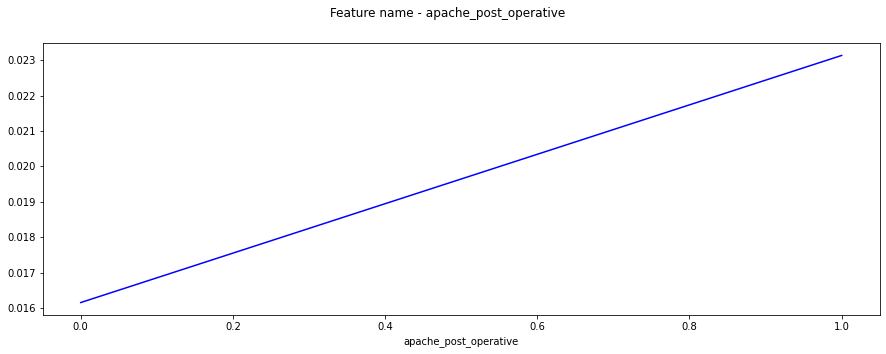

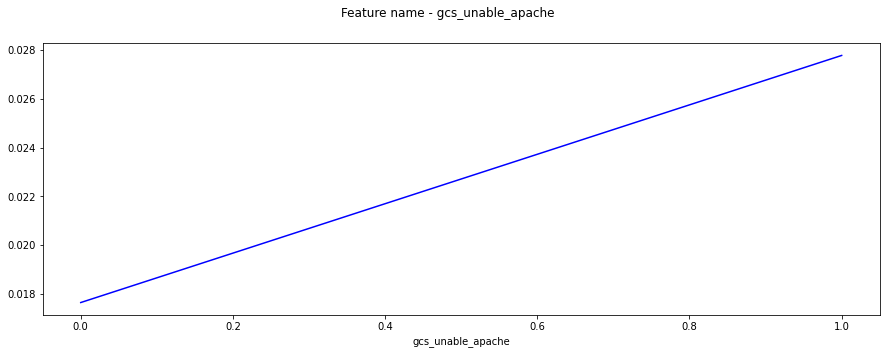

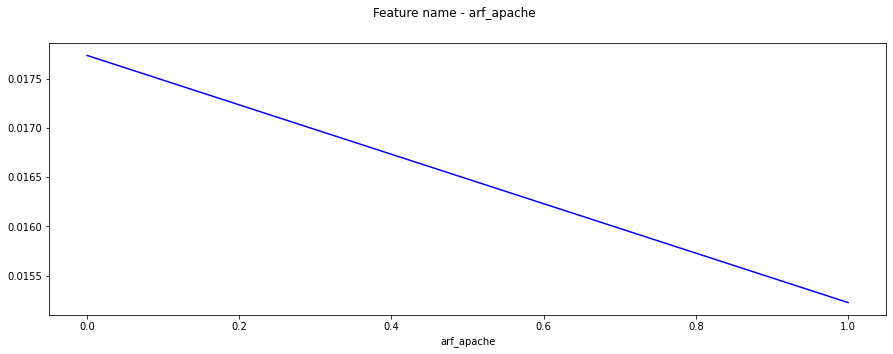

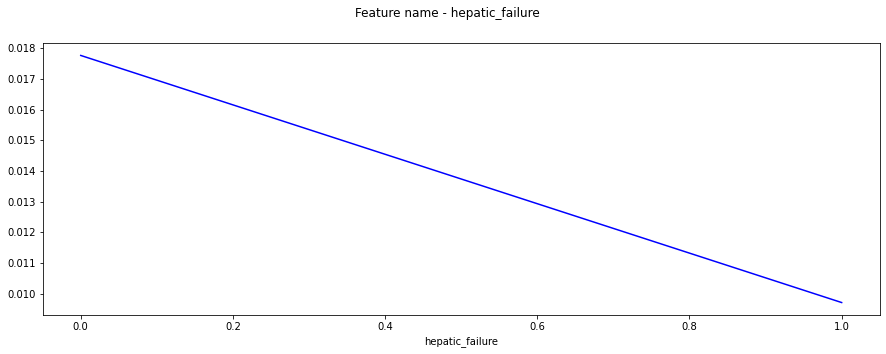

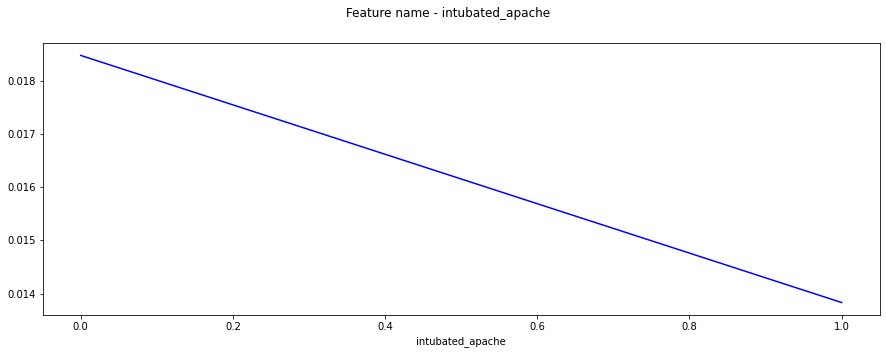

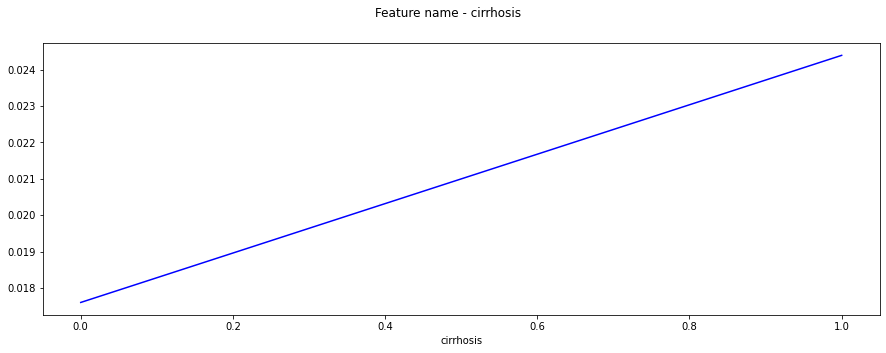

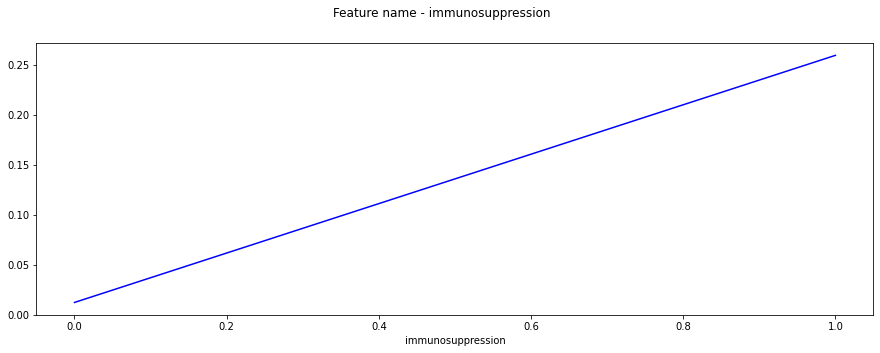

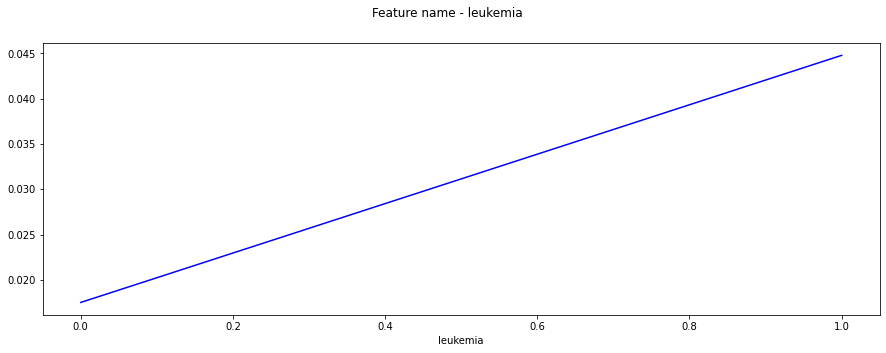

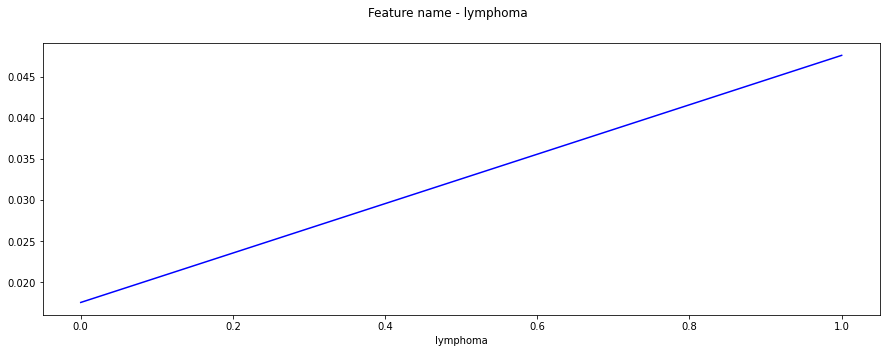

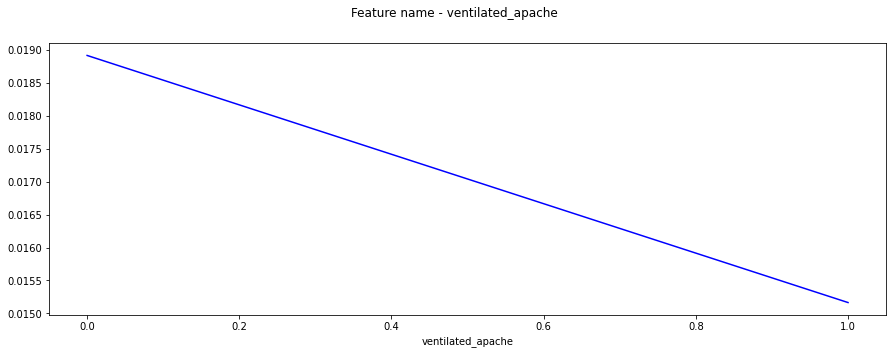

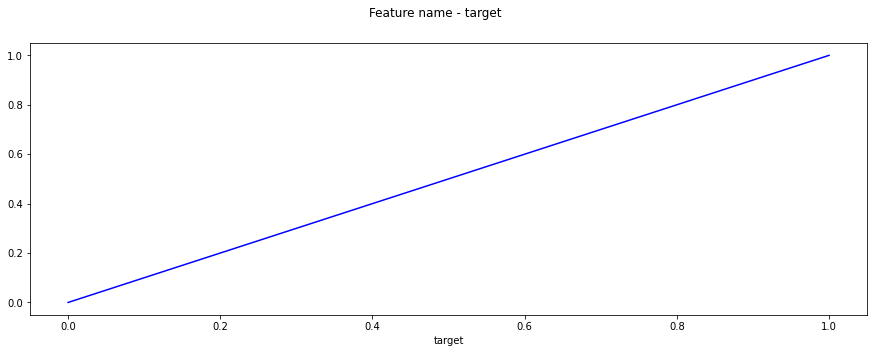

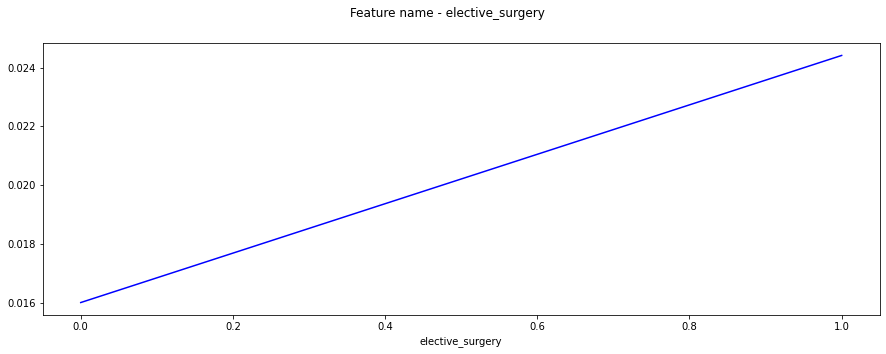

In [51]:
for col in data_linear:
    fig = plt.figure(figsize=(15, 5))
    plt.suptitle(f"Feature name - {col}")
#     print(col)
    data_linear.groupby([col])["target"].mean().plot(color="blue")

* преобладающее кол-во нелинейных связей с целевой переменной, если учесть, что до этого много признаков исключено, еще убирать много признаков для обучения линейной модели, при том, что в этом нету необходимости в данном датасете, не вижу смысла

# нелинейная связь признаков

In [53]:
"""
ф-я определяет нелинейную связь признаков, возвращает список из 20 наиболее важных
"""
def nonlianer_comun(data, numerical, target="class", num_sign=20)-> list:
    parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 2}
    data = data.copy()
    data = data[numerical]
    for i in data.columns:
        data[i] = data[i].fillna(data[i].median())
    forest = RandomForestClassifier(**parameters)
    forest.fit(data.drop(target, axis=1), data[target])
    
    # numerical original
    top = []
    n_top = num_sign
    importances = forest.feature_importances_
    idx = np.argsort(importances)[::-1][0:n_top]
    feature_names = data.drop(target, axis=1).columns

    plt.figure(figsize=(20, 5))
    sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
    top.append(feature_names[idx])
    plt.title(f"What {num_sign} are the top important features to start with?", size=14)
    plt.xticks(rotation=90)
    return top, idx, importances, feature_names

In [54]:
numerical_n = data_n.dtypes[data.dtypes != "object"].index

print(f"Всего числовых признаков: {len(numerical_n)}")

Всего числовых признаков: 99


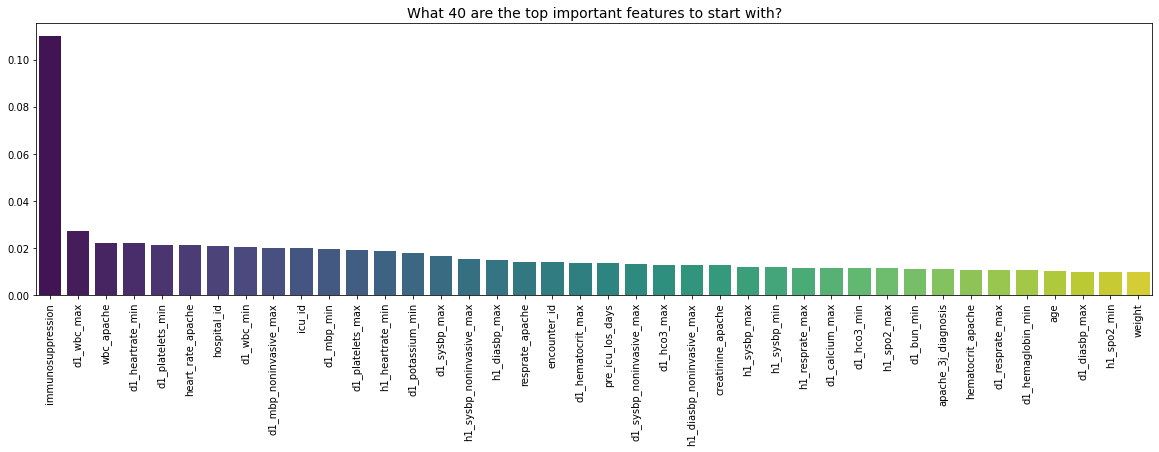

In [55]:
top_non_linear, idx, importances, feature_names = nonlianer_comun(data_n, numerical_n, "target", 40)

In [56]:
top_non_linear, idx, importances, feature_names

([Index(['immunosuppression', 'd1_wbc_max', 'wbc_apache', 'd1_heartrate_min',
         'd1_platelets_min', 'heart_rate_apache', 'hospital_id', 'd1_wbc_min',
         'd1_mbp_noninvasive_max', 'icu_id', 'd1_mbp_min', 'd1_platelets_max',
         'h1_heartrate_min', 'd1_potassium_min', 'd1_sysbp_max',
         'h1_sysbp_noninvasive_max', 'h1_diasbp_max', 'resprate_apache',
         'encounter_id', 'd1_hematocrit_max', 'pre_icu_los_days',
         'd1_sysbp_noninvasive_max', 'd1_hco3_max', 'h1_diasbp_noninvasive_max',
         'creatinine_apache', 'h1_sysbp_max', 'h1_sysbp_min', 'h1_resprate_max',
         'd1_calcium_max', 'd1_hco3_min', 'h1_spo2_max', 'd1_bun_min',
         'apache_3j_diagnosis', 'hematocrit_apache', 'd1_resprate_max',
         'd1_hemaglobin_min', 'age', 'd1_diasbp_max', 'h1_spo2_min', 'weight'],
        dtype='object')],
 array([95, 90, 29, 35, 85, 21,  1, 91, 38,  6, 37, 84, 55, 87, 44, 66, 50,
        25,  0, 82,  7, 46, 78, 52, 15, 64, 65, 60, 72, 79, 62, 71, 11, 2

# гистограммы распределений

In [57]:
len(continuous_feature_n)

82

In [58]:
data["encounter_id"].mean()

140498.77946062144

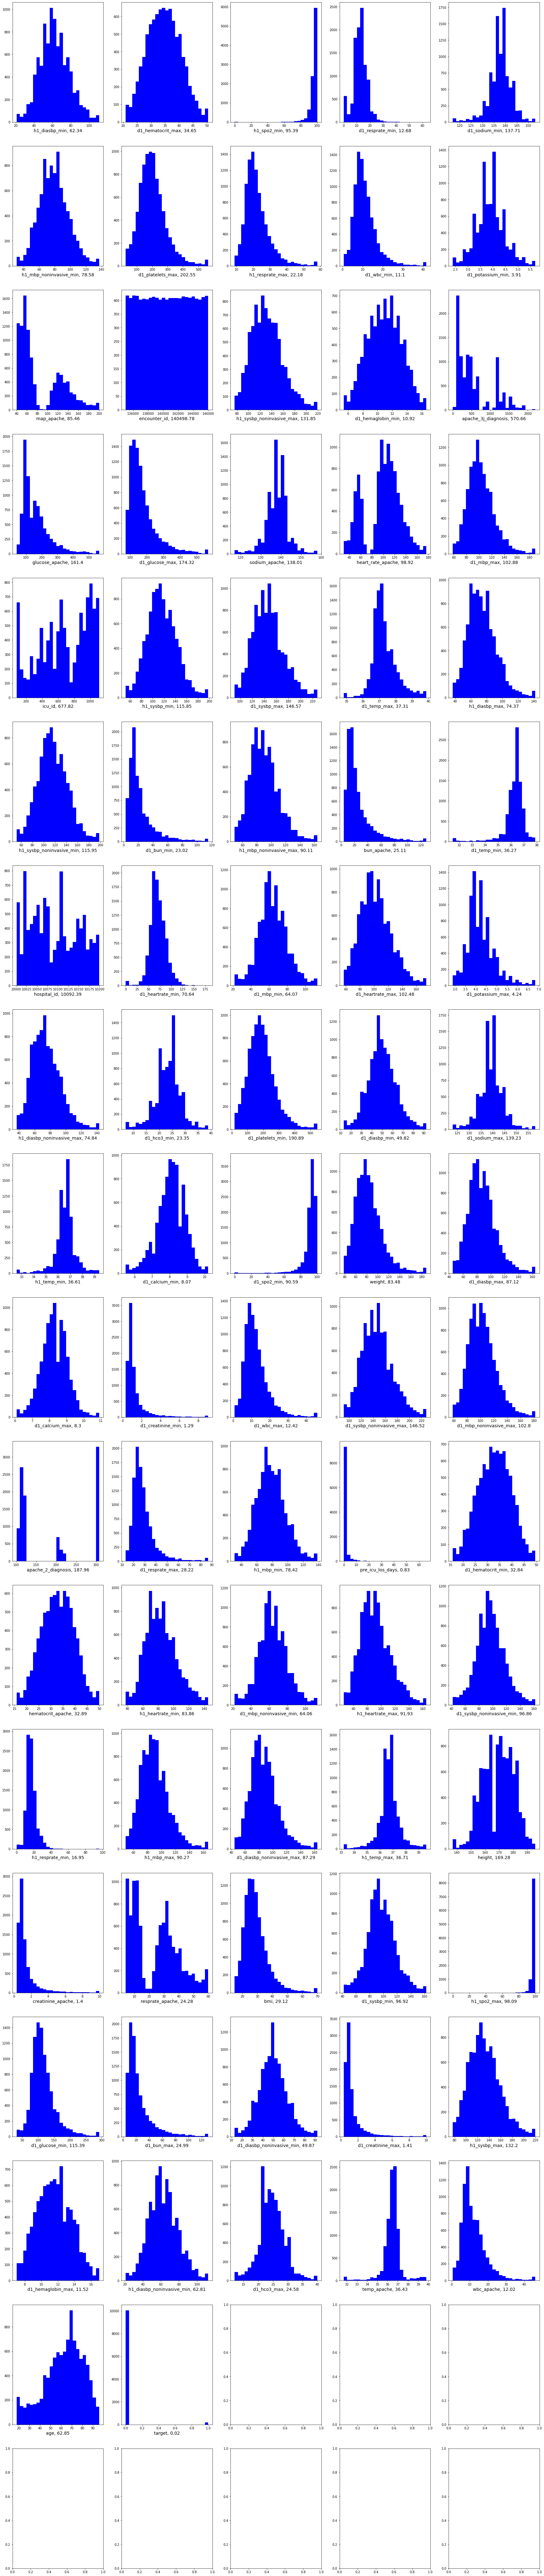

In [59]:
fig, axes = plt.subplots(18, 5,figsize=(30, 150))

for num, feature in enumerate(continuous_feature_n):
    df = data_n[feature].copy()
    mean_ = round(df.mean(), 2)
#     print(axes)
    axes[num//5, num%5].hist(df, bins=25, color="blue")
    axes[num//5, num%5].set_xlabel(f"{feature}, {mean_}", fontsize=14)

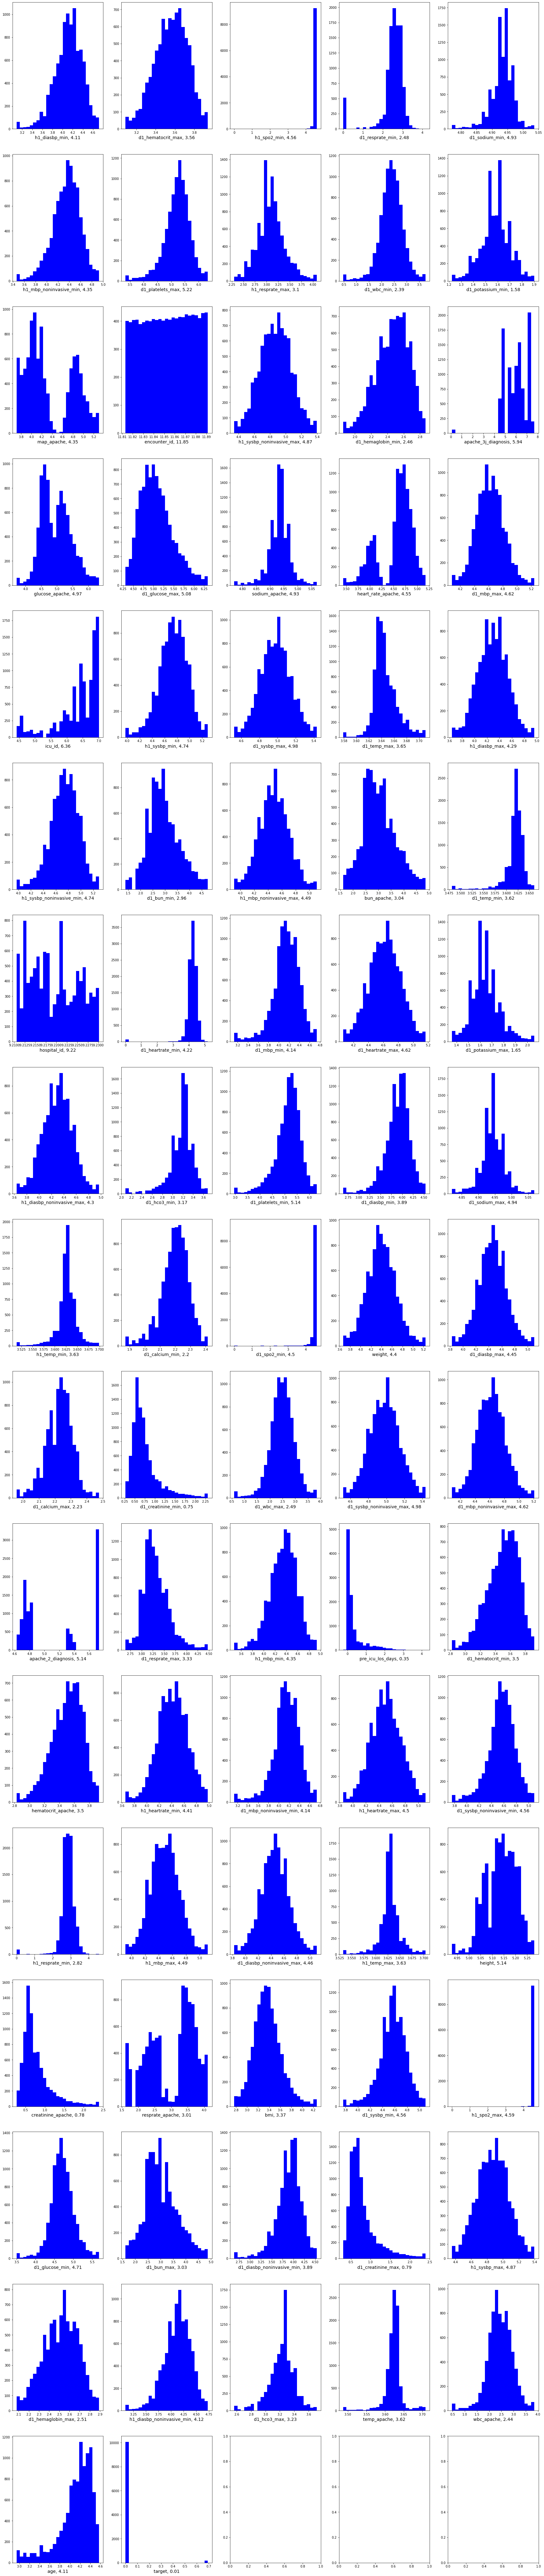

In [60]:
fig, axes = plt.subplots(17, 5,figsize=(30, 150))

for num, feature in enumerate(continuous_feature_n):
    df = np.log(data_n[feature].copy() + 1)
    mean_ = round(df.mean(), 2)
#     print(axes)
    axes[num//5, num%5].hist(df, bins=25, color="blue")
    axes[num//5, num%5].set_xlabel(f"{feature}, {mean_}", fontsize=14)

In [61]:
len(discrete_feature_n)

18

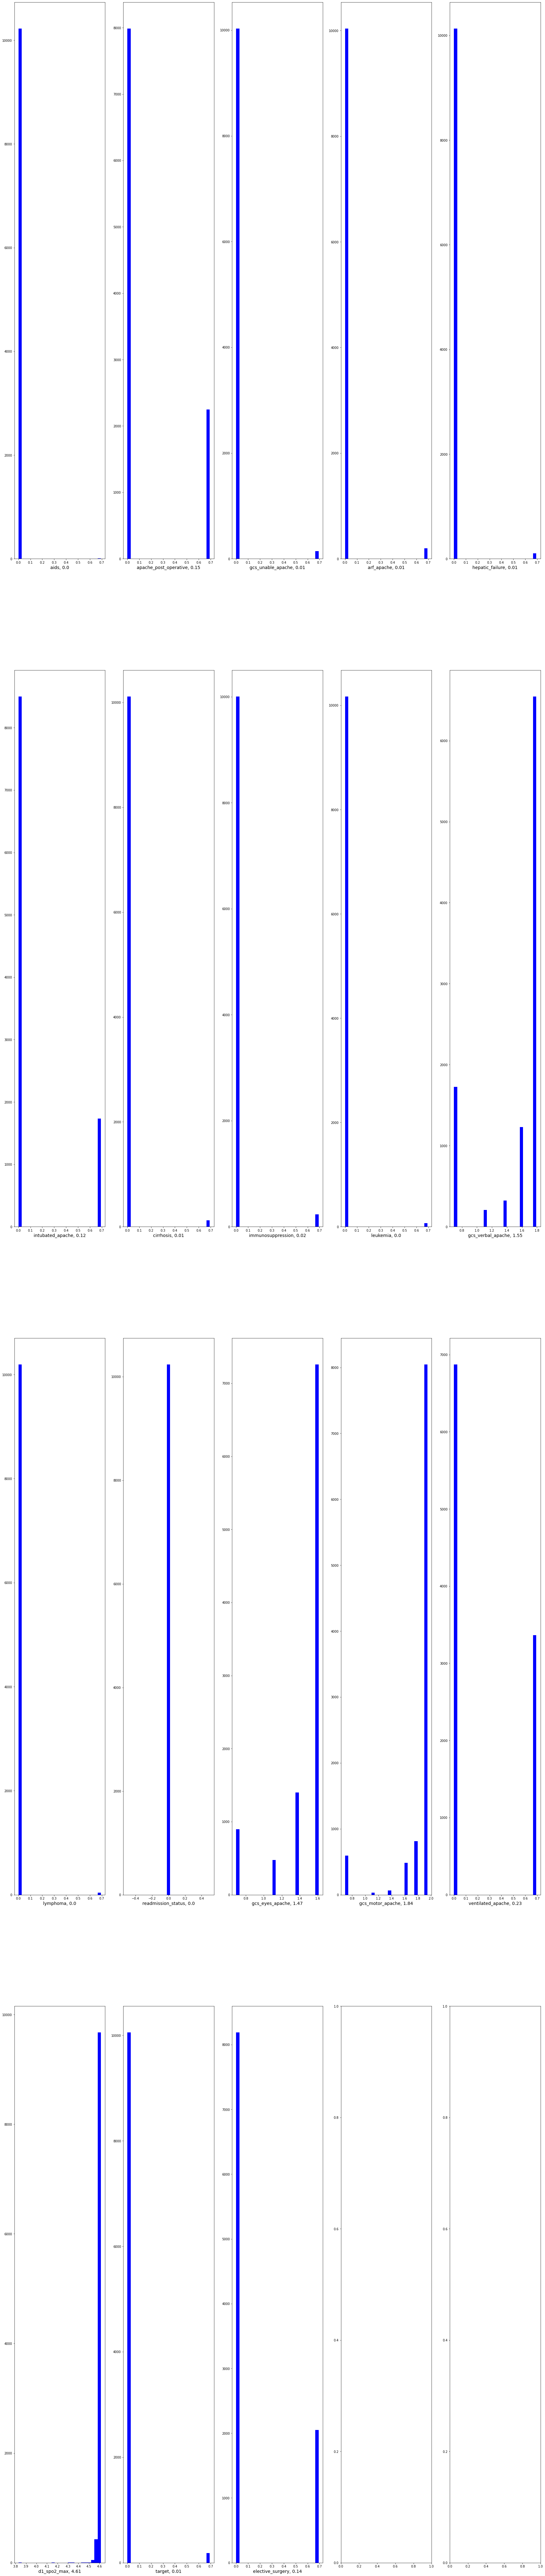

In [62]:
fig, axes = plt.subplots(4, 5,figsize=(30, 150))

for num, feature in enumerate(discrete_feature_n):
    df = np.log(data_n[feature].copy() + 1)
    mean_ = round(df.mean(), 2)
#     print(axes)
    axes[num//5, num%5].hist(df, bins=25, color="blue")
    axes[num//5, num%5].set_xlabel(f"{feature}, {mean_}", fontsize=14)

# зависимость между дескретными признаками и целевой переменной

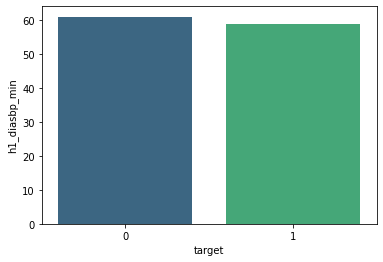

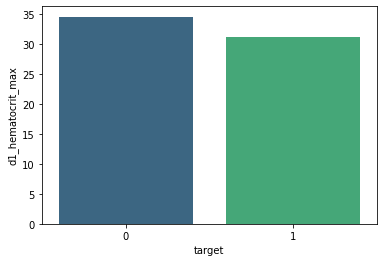

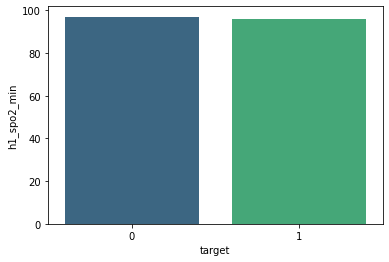

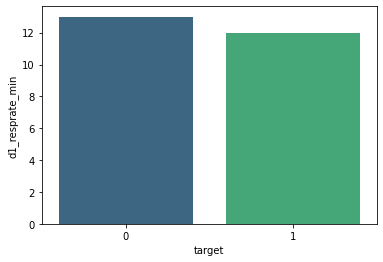

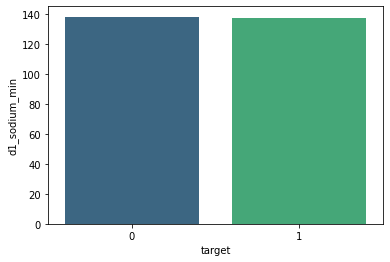

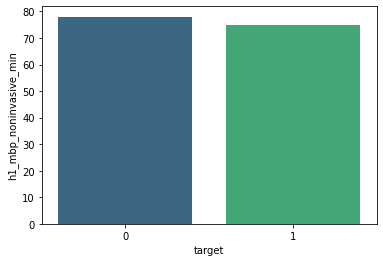

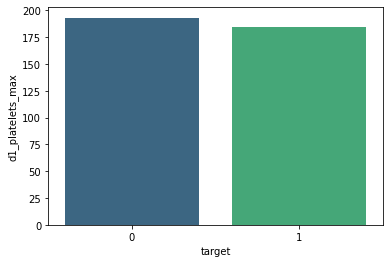

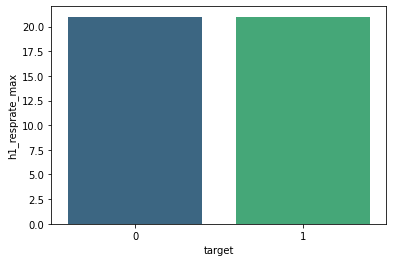

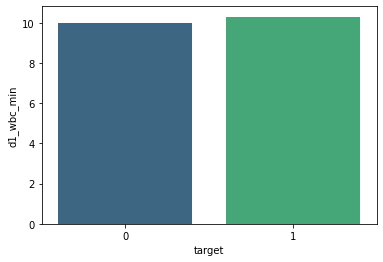

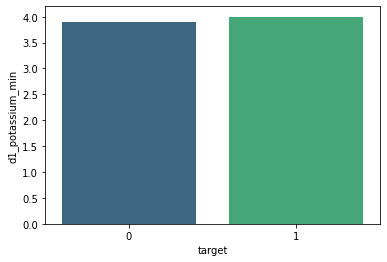

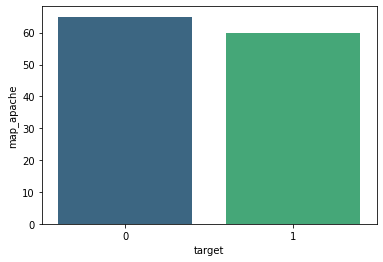

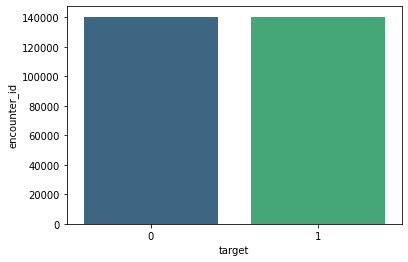

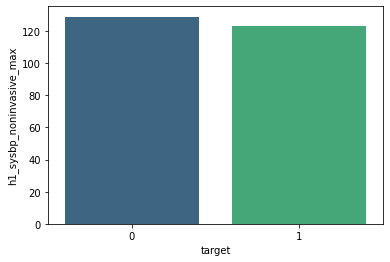

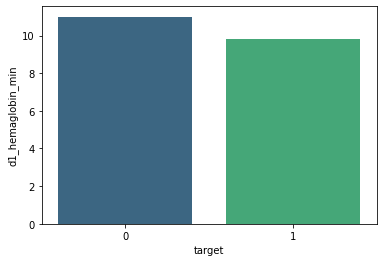

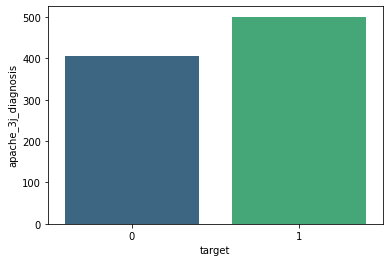

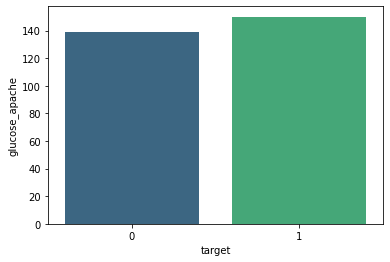

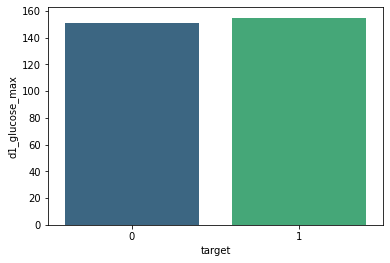

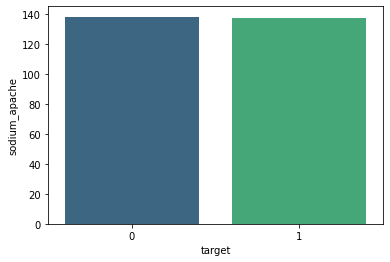

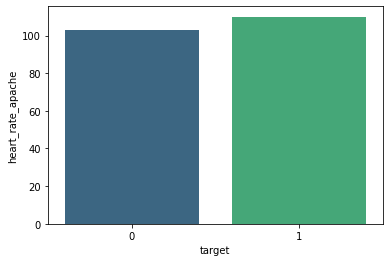

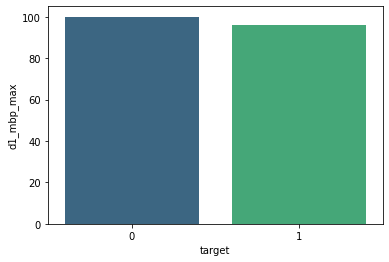

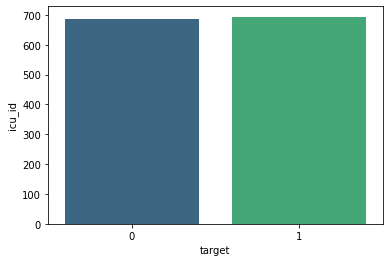

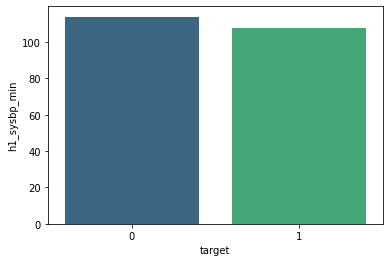

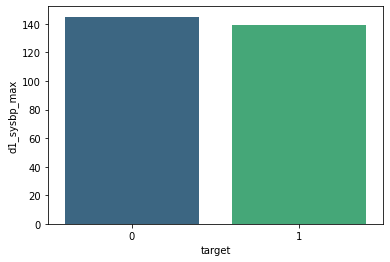

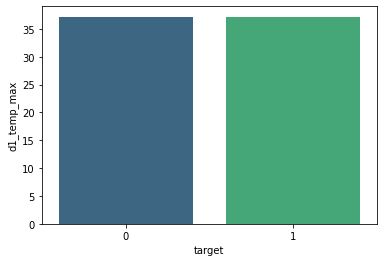

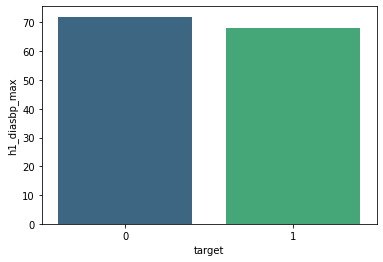

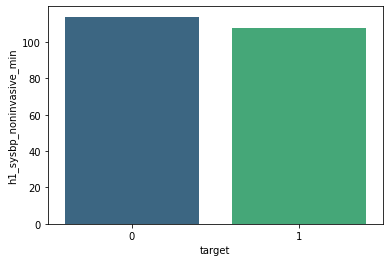

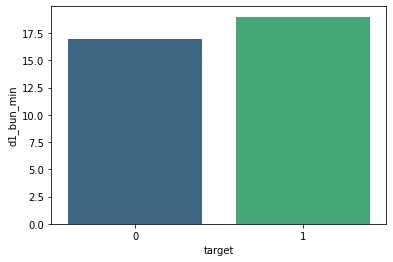

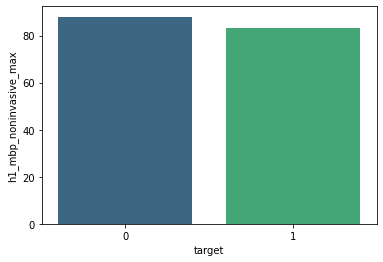

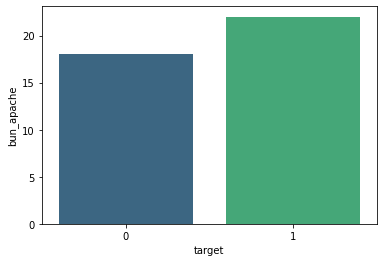

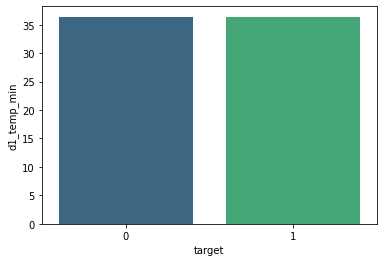

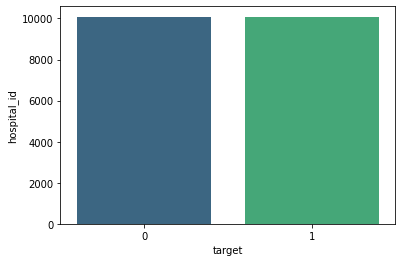

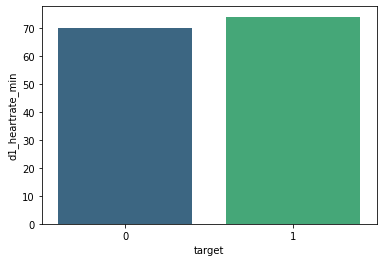

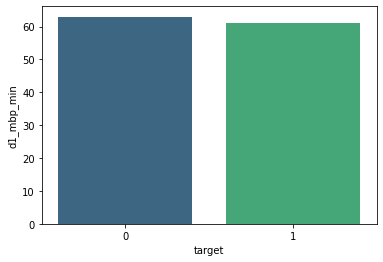

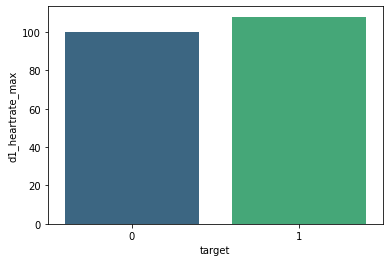

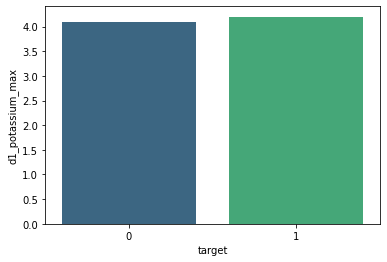

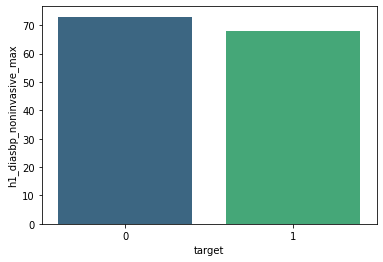

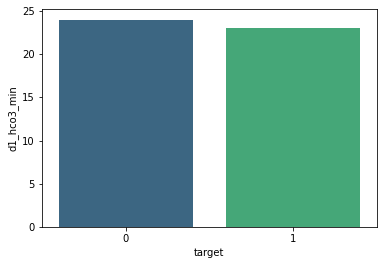

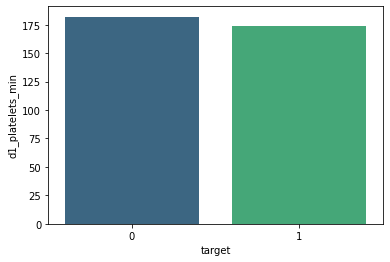

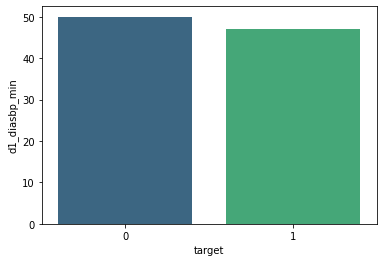

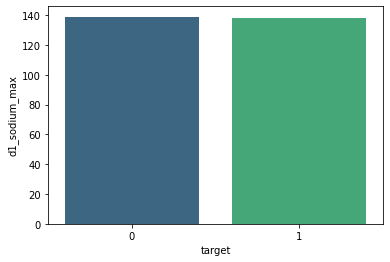

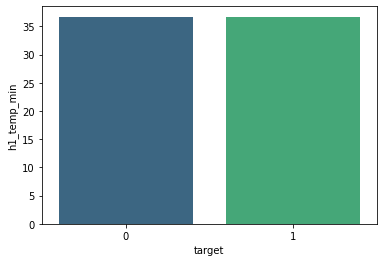

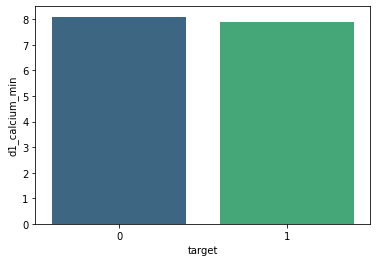

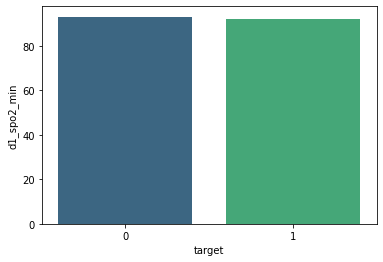

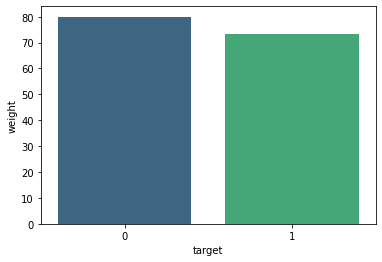

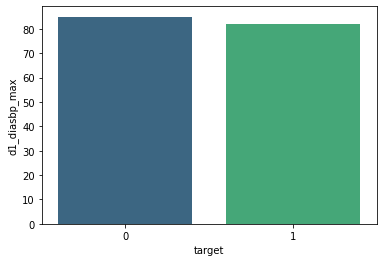

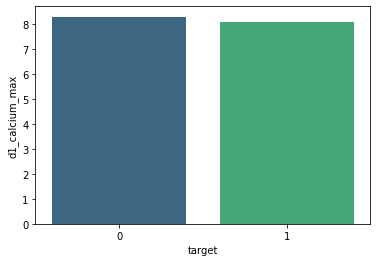

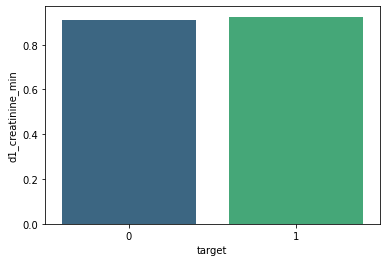

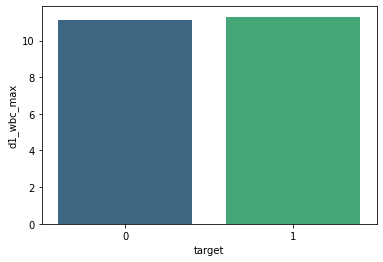

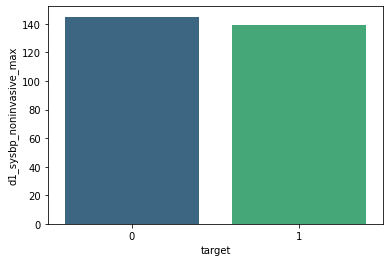

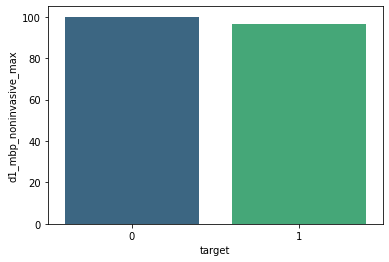

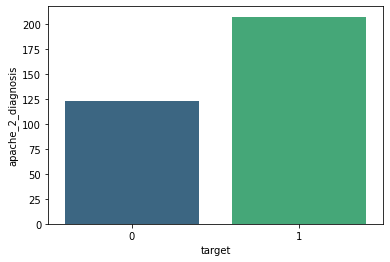

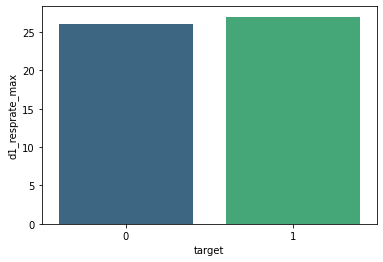

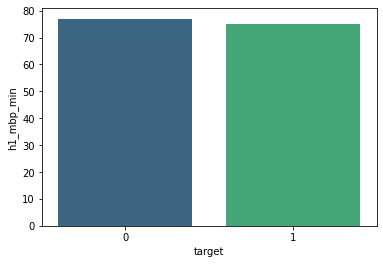

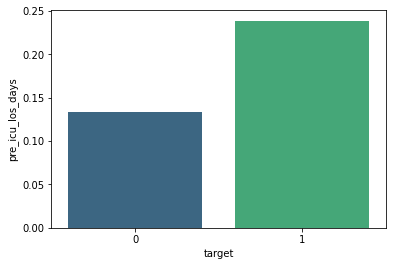

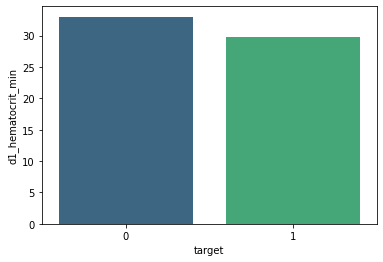

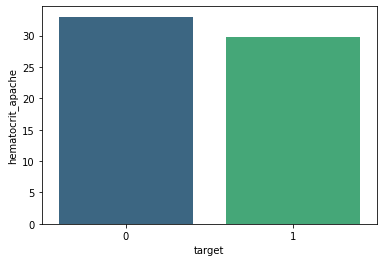

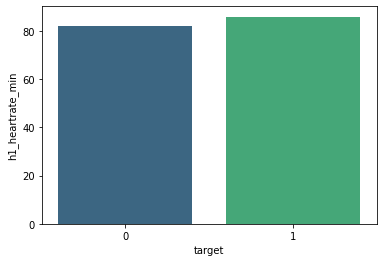

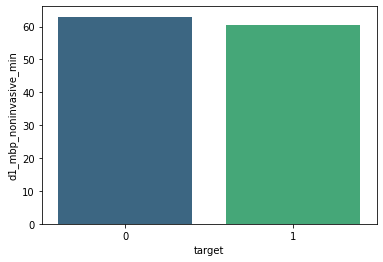

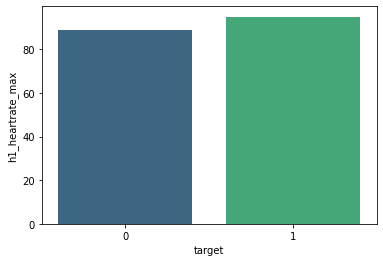

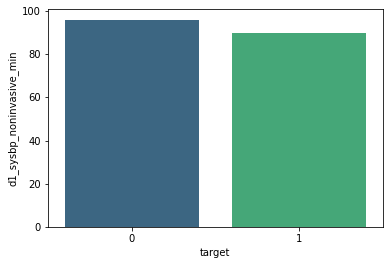

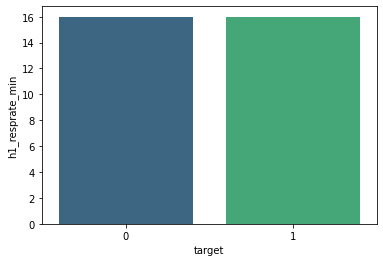

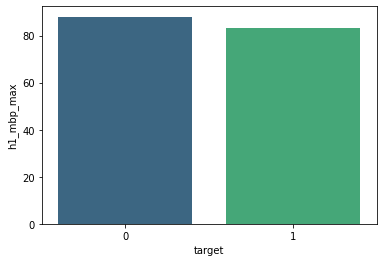

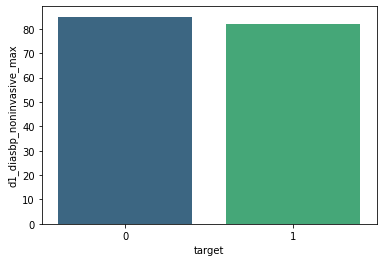

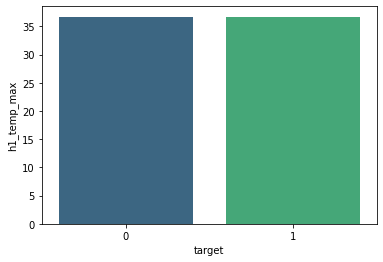

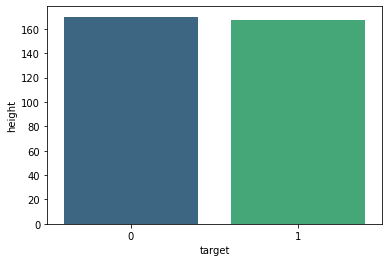

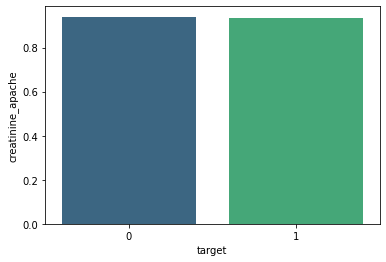

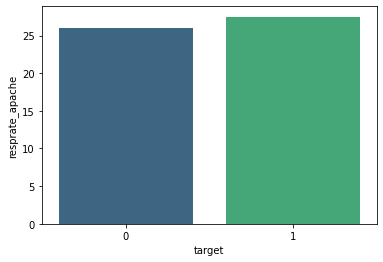

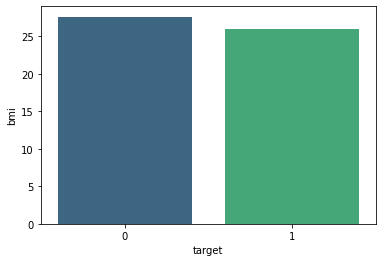

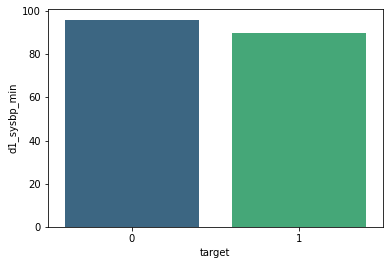

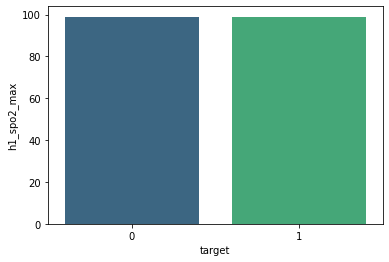

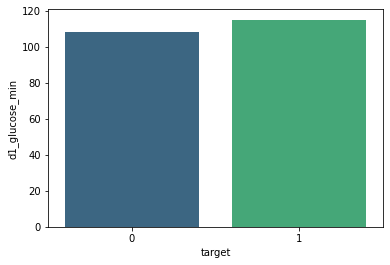

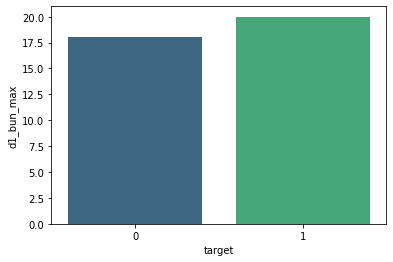

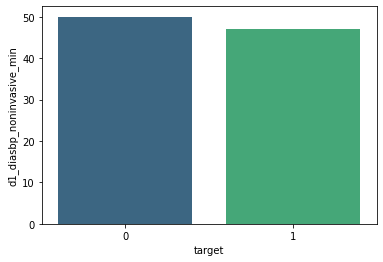

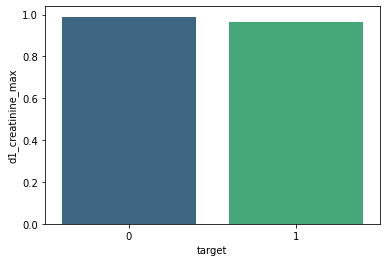

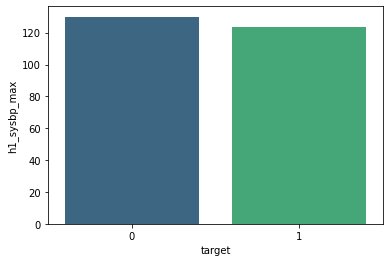

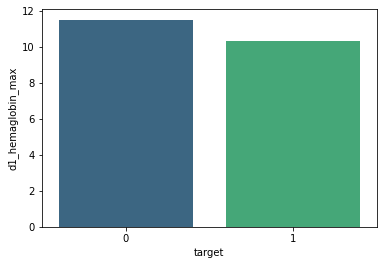

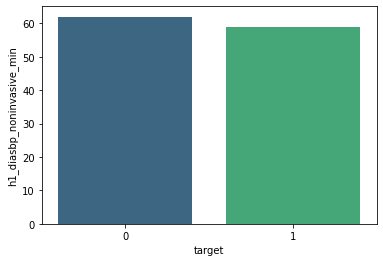

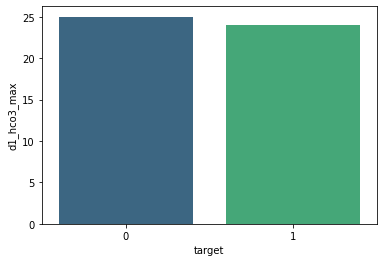

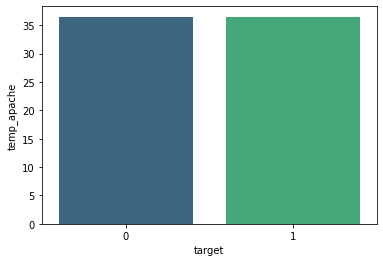

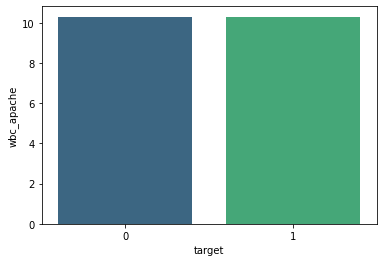

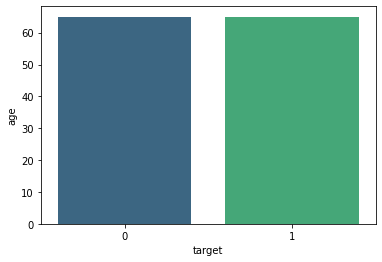

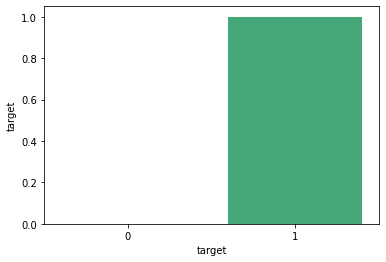

In [63]:
for num, feature in enumerate(continuous_feature_n):
    plt.figure() 
    df = data_n.copy()
    statistics = df.groupby(["target"])[feature].median()

    sns.barplot(
        x=statistics.index,
        y=statistics.values,
        palette="viridis",
    )
    plt.ylabel(feature)
    plt.show()

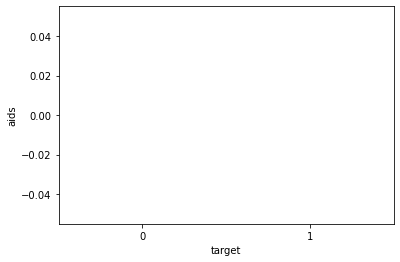

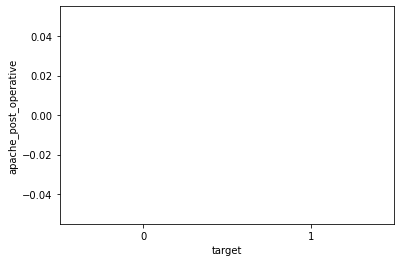

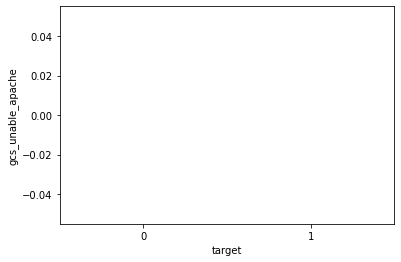

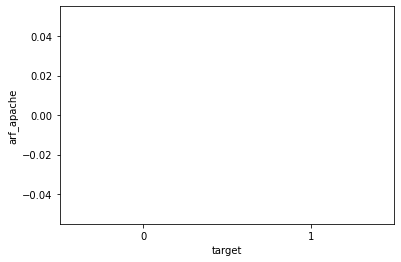

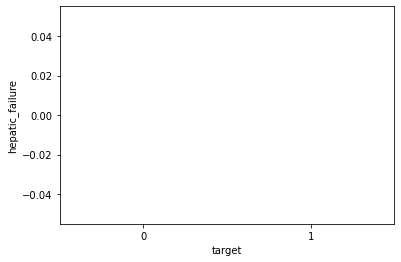

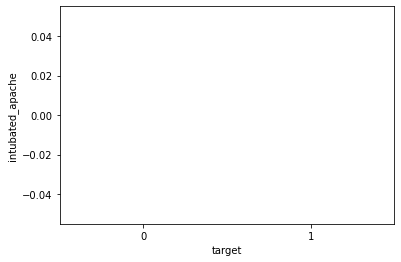

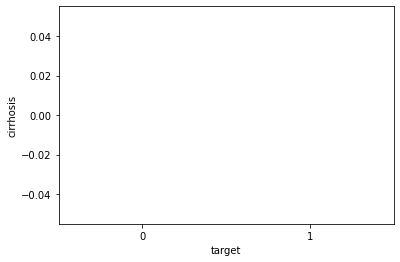

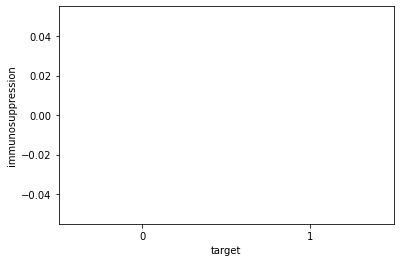

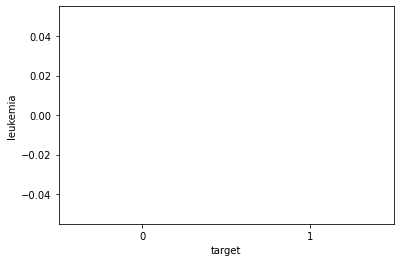

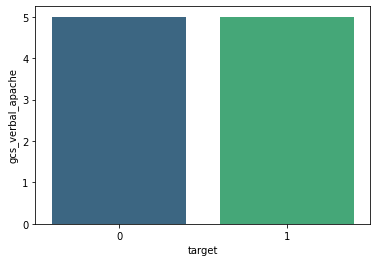

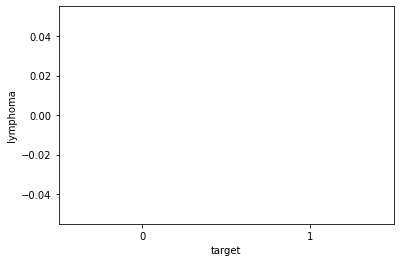

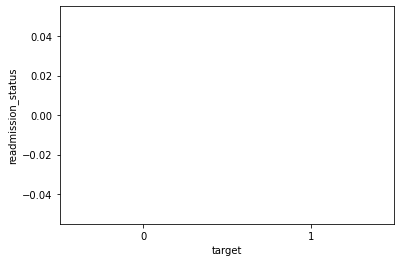

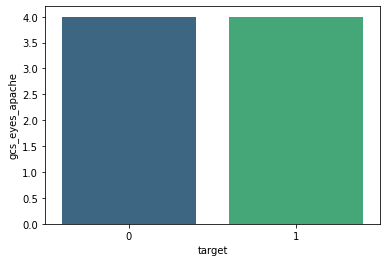

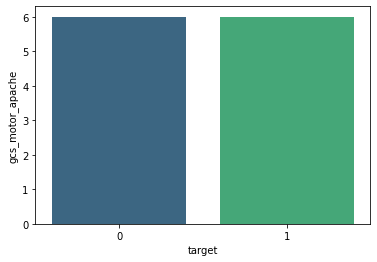

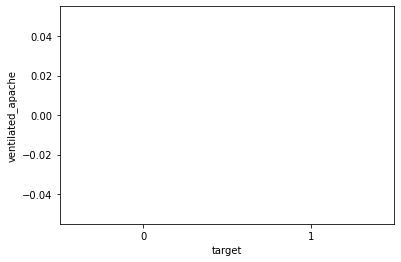

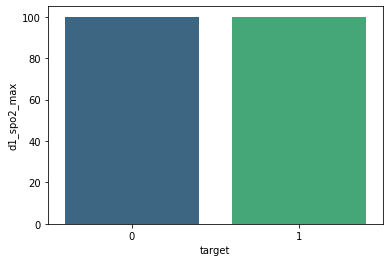

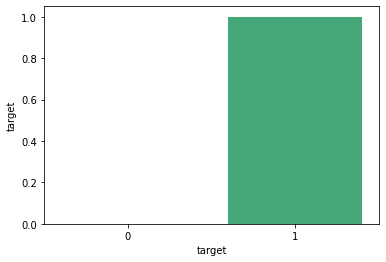

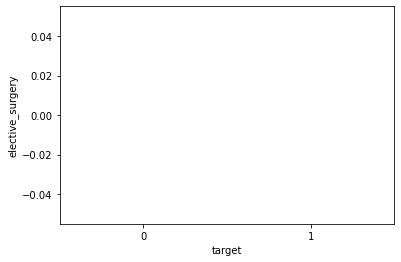

In [64]:
for num, feature in enumerate(discrete_feature_n):
    plt.figure() 
    df = data_n.copy()
    statistics = df.groupby(["target"])[feature].median()

    sns.barplot(
        x=statistics.index,
        y=statistics.values,
        palette="viridis",
    )
    plt.ylabel(feature)
    plt.show()

# box plot

In [65]:
df.groupby(["target"])["age"]

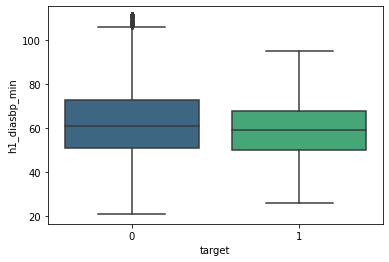

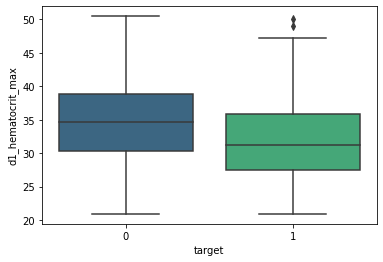

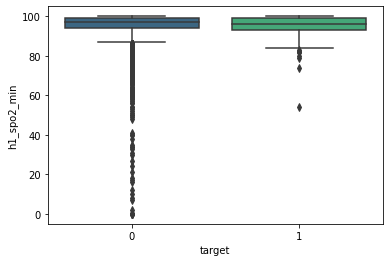

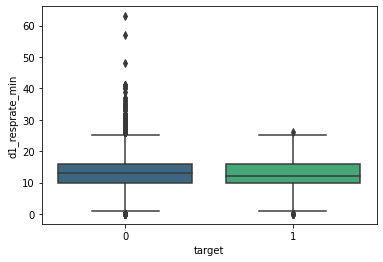

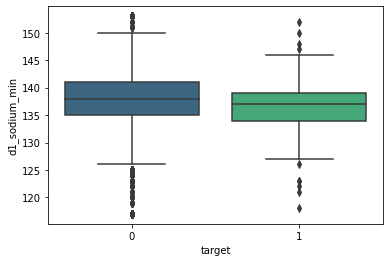

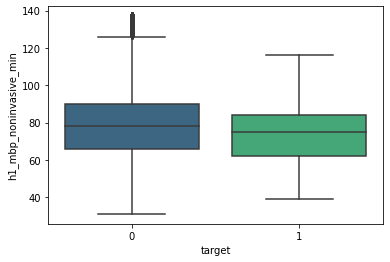

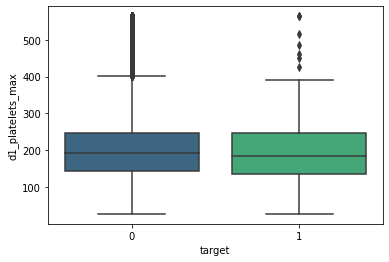

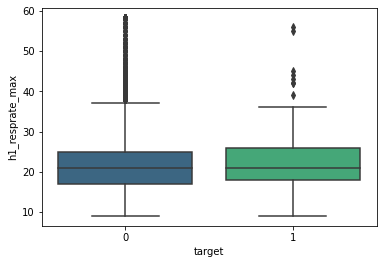

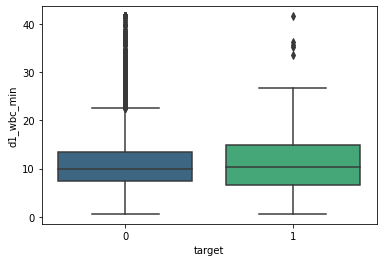

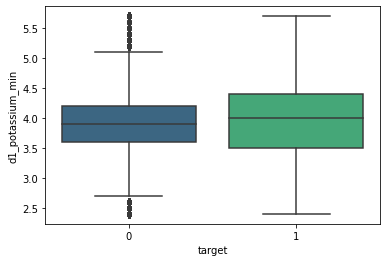

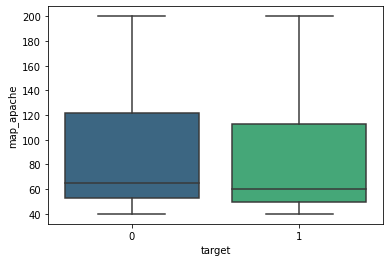

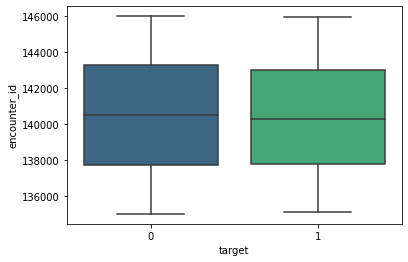

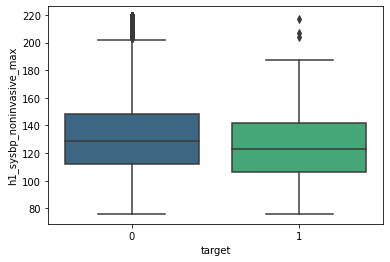

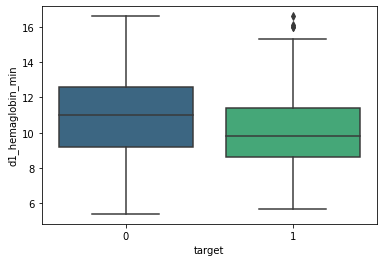

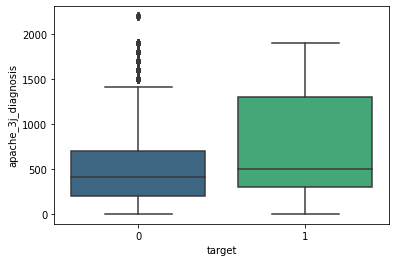

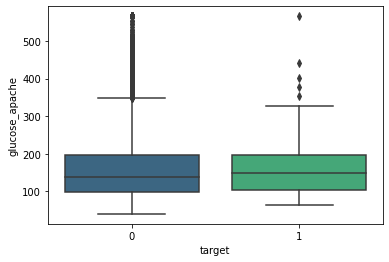

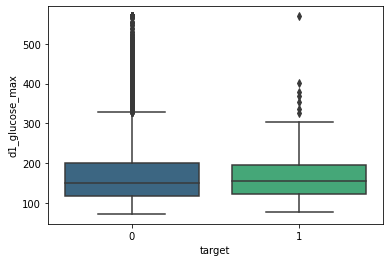

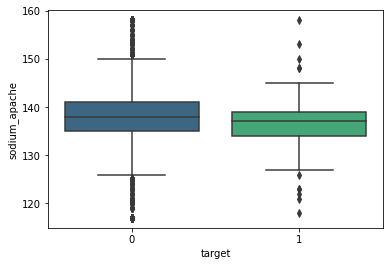

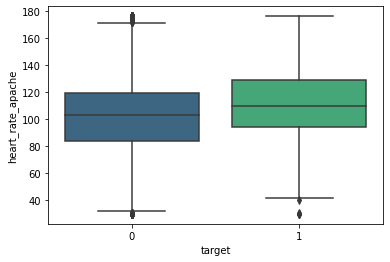

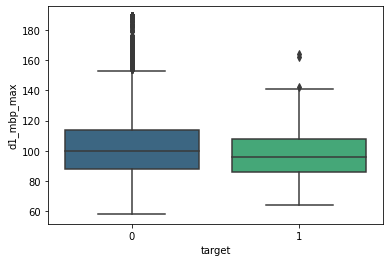

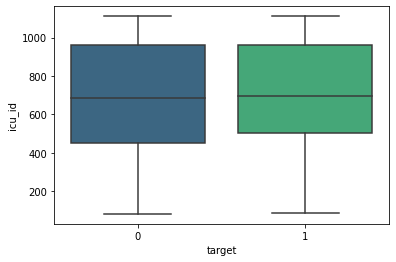

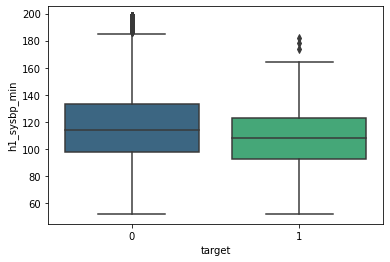

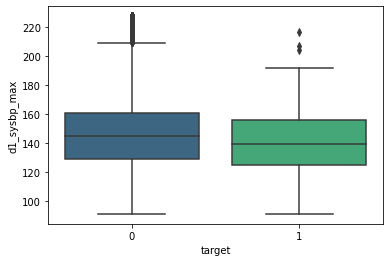

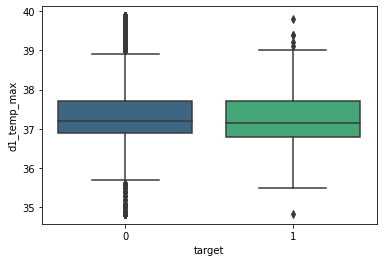

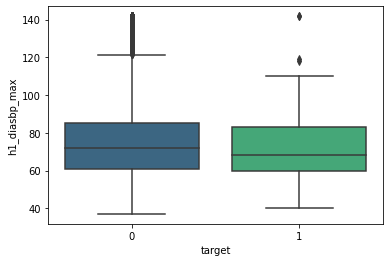

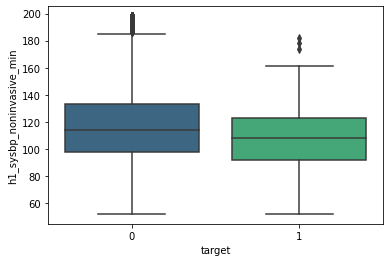

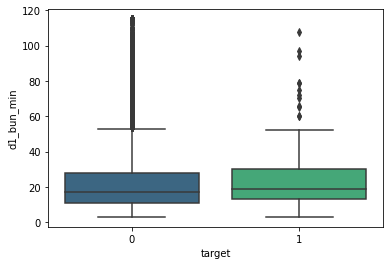

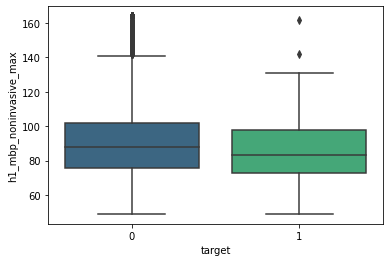

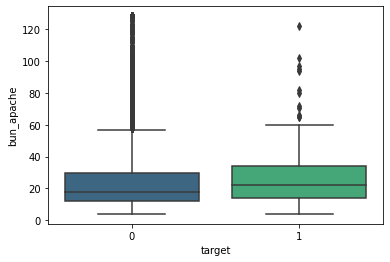

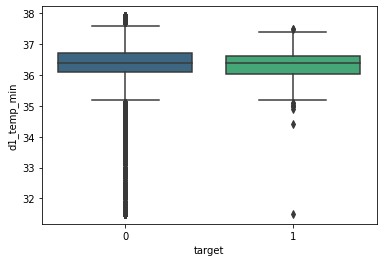

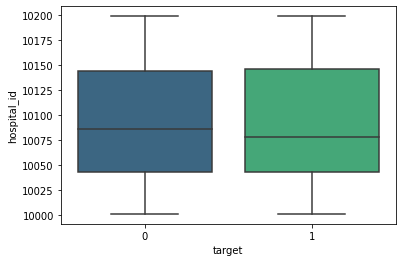

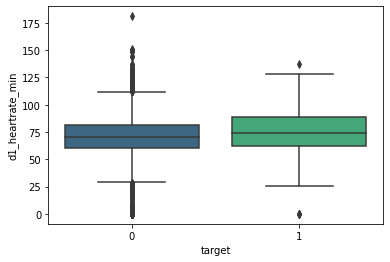

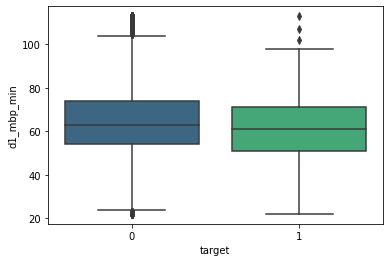

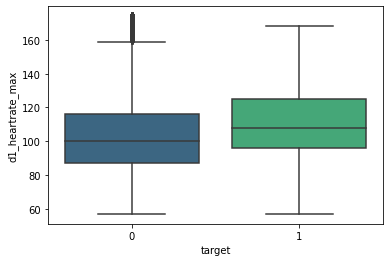

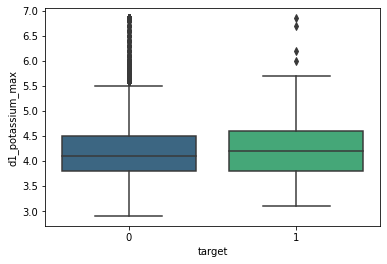

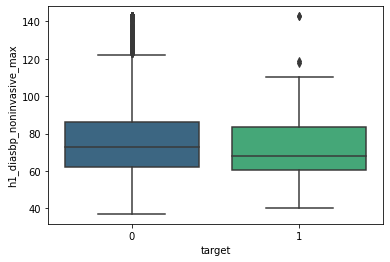

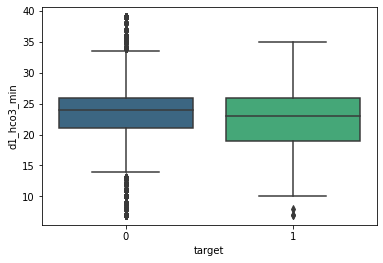

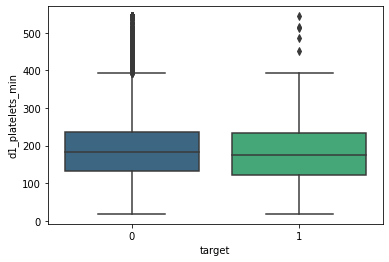

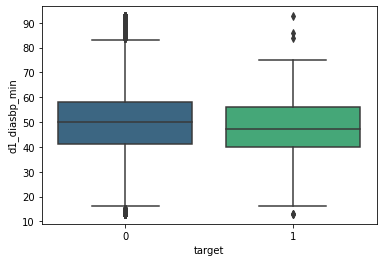

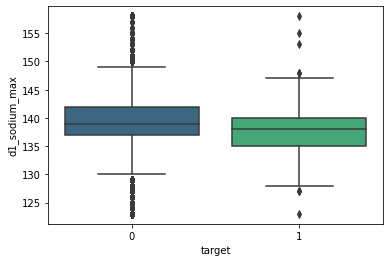

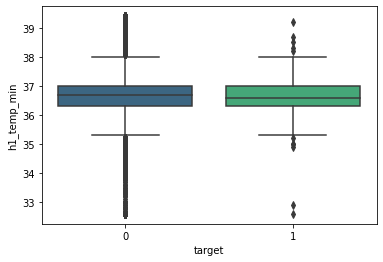

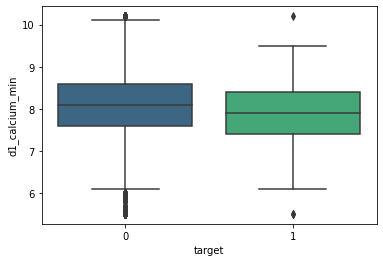

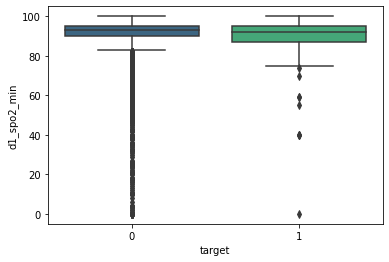

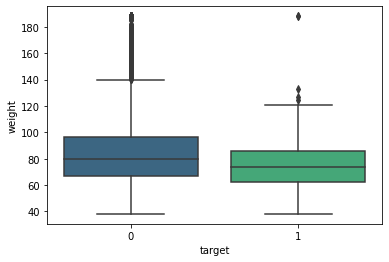

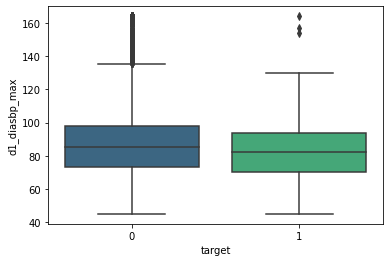

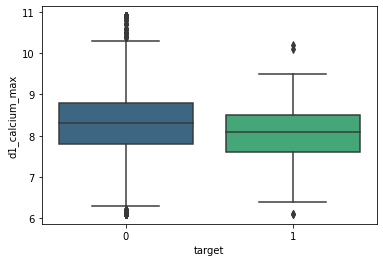

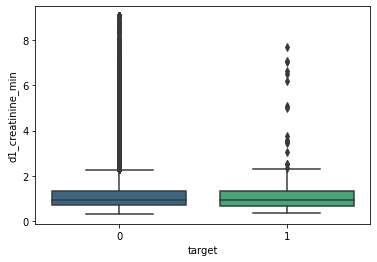

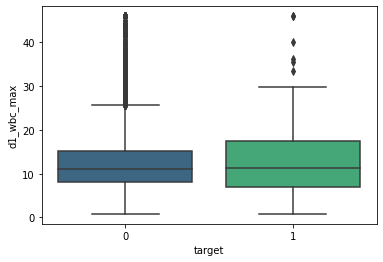

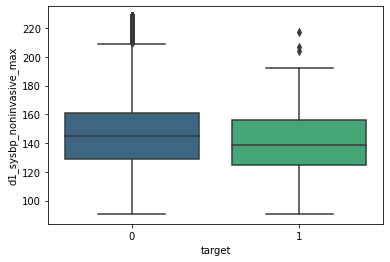

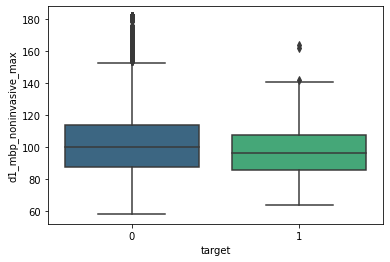

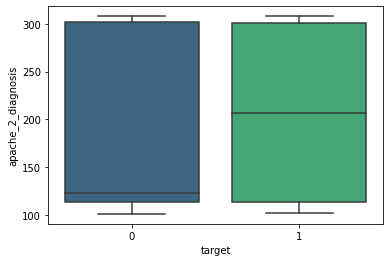

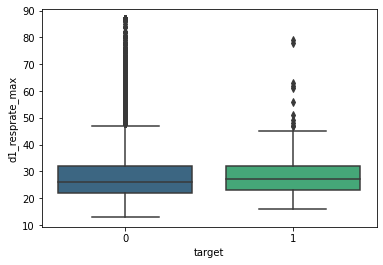

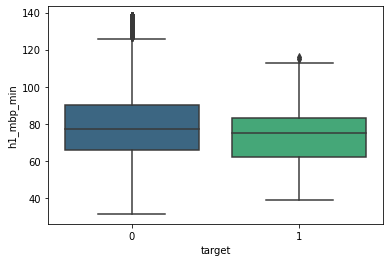

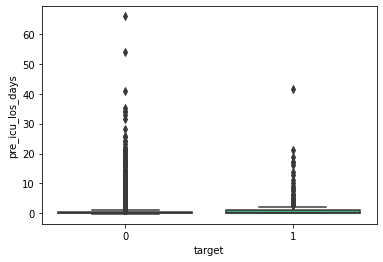

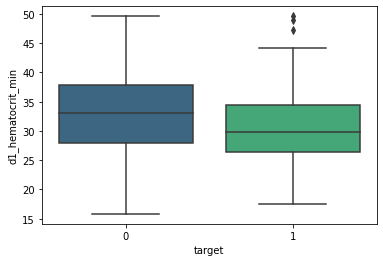

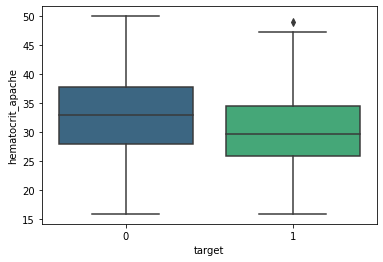

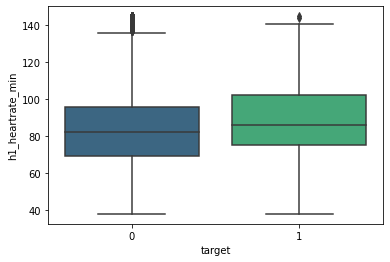

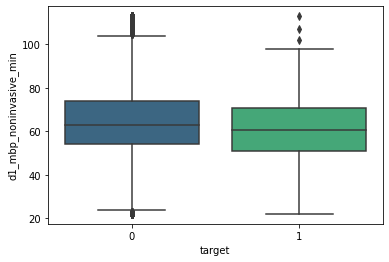

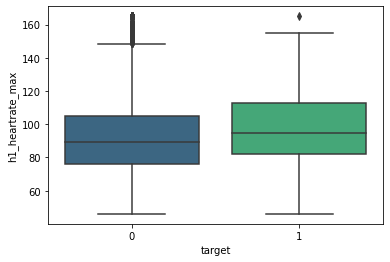

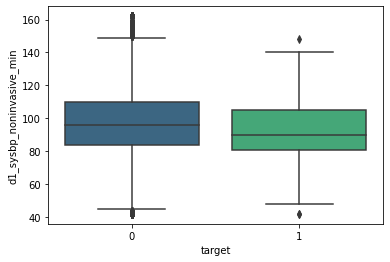

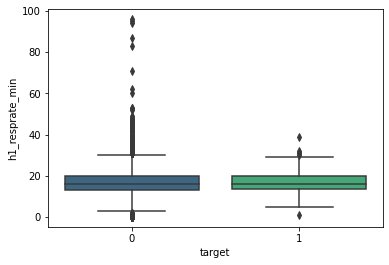

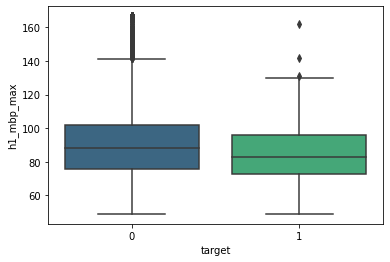

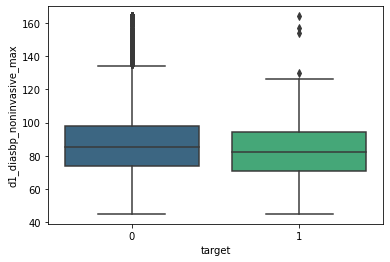

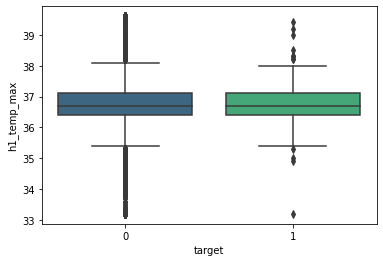

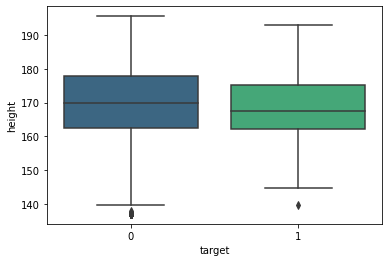

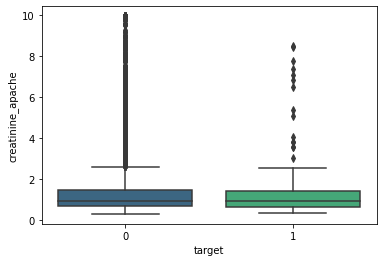

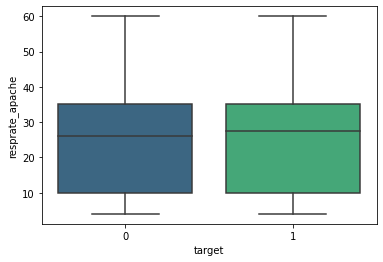

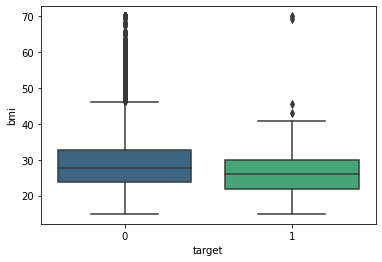

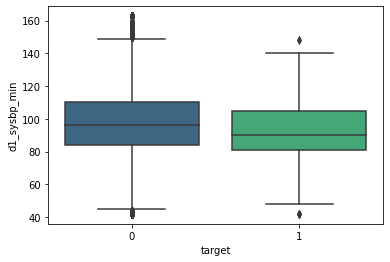

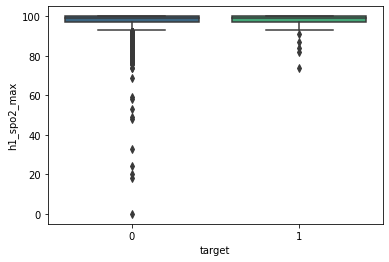

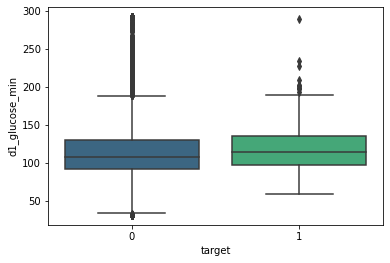

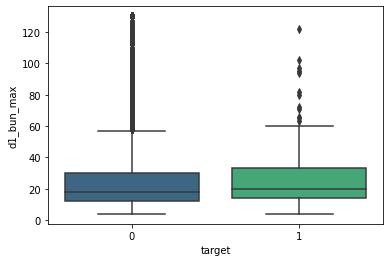

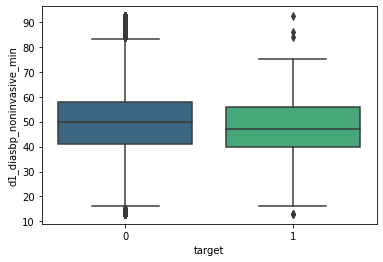

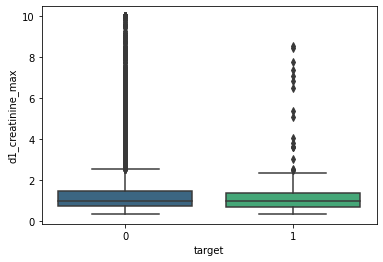

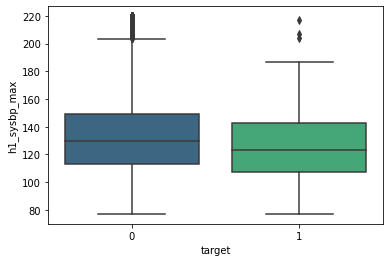

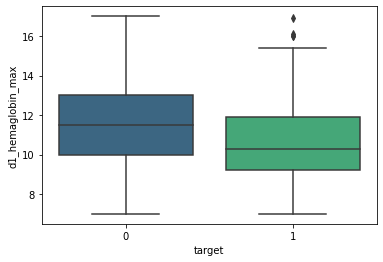

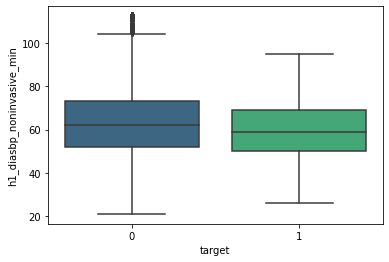

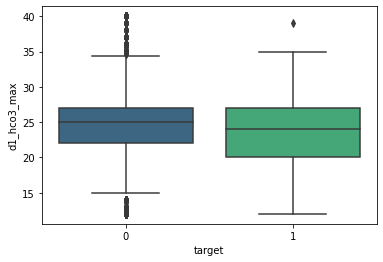

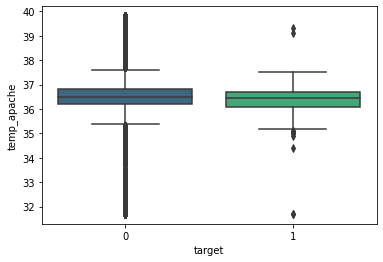

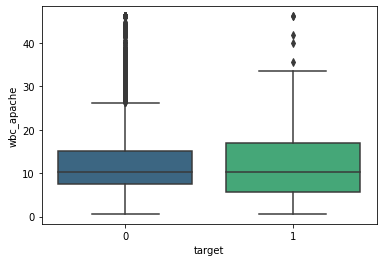

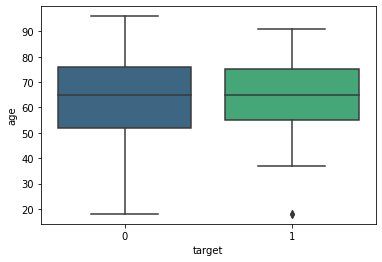

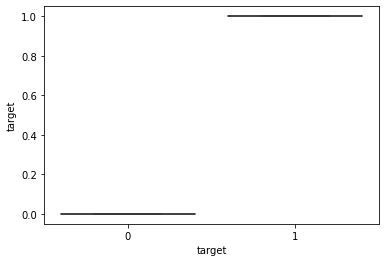

In [66]:
for num, feature in enumerate(continuous_feature_n):
    plt.figure() 
    df = data_n.copy()
#     statistics = df.groupby(["target"])[feature]

    sns.boxplot(
        x="target",
        y=feature,
        data = df,
        palette="viridis",
    )
    plt.ylabel(feature)
    plt.show()

# Доверительный интервал

In [67]:
# найдем среднее и стандартное отклонение
mu = data_n['age'].mean()
sigma = data_n['age'].std()

mu, sigma

(62.85362517099863, 17.85166063435276)

In [68]:
sigma/mu

0.2840195865518624

In [69]:
# стандартная ошибка среднего
sem = stats.sem(data_n['age'])

sem

0.17646391730388003

In [70]:
# доверительный интервал
confidence = 0.95
ci = stats.t.interval(confidence, len(data_n['age'])-1, loc=mu, scale=sem)

ci

(62.507721334904105, 63.19952900709316)

In [91]:
import scipy
scipy.__version__

'1.7.3'

In [97]:
def interv(df):
    for sign in df:
        mu = df[sign].mean()
        sigma = df[sign].std()
        sem = stats.sem(df[sign], nan_policy="omit")

        confidence = 0.95
        ci = stats.t.interval(confidence, len(df[sign])-1, loc=mu, scale=sem)
        
            
        print(sign)
        print("среднее: ", mu)
        print("стандартная ошибка: ", sem)
        print("интервал: ", ci)
        if mu < ci[0] or mu > ci[1]:
            print("среднее за пределами интервала")
        print("*" * 50)

In [98]:
interv(data_n[continuous_feature_n])

h1_diasbp_min
среднее:  62.34209977040284
стандартная ошибка:  0.16453643177199861
интервал:  (62.01957614179478, 62.6646233990109)
**************************************************
d1_hematocrit_max
среднее:  34.64779900055525
стандартная ошибка:  0.0630479765406236
интервал:  (34.52421261940378, 34.77138538170673)
**************************************************
h1_spo2_min
среднее:  95.38683214135465
стандартная ошибка:  0.06847453942991151
интервал:  (95.25260863421792, 95.52105564849137)
**************************************************
d1_resprate_min
среднее:  12.676196089989194
стандартная ошибка:  0.05194960778688024
интервал:  (12.574364685067227, 12.77802749491116)
**************************************************
d1_sodium_min
среднее:  137.71491055846423
стандартная ошибка:  0.051062576931479635
интервал:  (137.61481790773237, 137.81500320919608)
**************************************************
h1_mbp_noninvasive_min
среднее:  78.57637083097795
стандартная ошибка:  

wbc_apache
среднее:  12.017956986510562
стандартная ошибка:  0.07748456804190659
интервал:  (11.866072058796597, 12.169841914224527)
**************************************************
age
среднее:  62.85362517099863
стандартная ошибка:  0.17646391730388003
интервал:  (62.507721334904105, 63.19952900709316)
**************************************************
target
среднее:  0.017686144225131914
стандартная ошибка:  0.0013029874388364746
интервал:  (0.015132033671752462, 0.020240254778511366)
**************************************************



* стандартная ошибка каждой совокупности данных, не большпя и почти везде расхождение интервала не большое, но тк nan опущены при подсчете библиотекой stats, и получается в каждом признаке разное кол-во исследований, полностью опираться на эту статистику не стоит( чем больше исследований в совокупности, тем ближе к 0 стандартная ошибка)

* дальнейшую работу буду делать на данных, исключающих большое кол-пропусков в признаках

In [99]:
data_n.shape

(10234, 105)

In [101]:
data_n.to_csv("data/data_n.csv", index=False)